# Santa's 2019 : Original Genetic Algorithm method

This Notebook contains : 
- main fonction to optimize schedule of santa tour 2019 KAGGLE competition 
- all functions to make genetic algo works

VERSIONS :
- V2.1: 04/02/2020 : correction fun_vect_mut
- V2.0: 03/02/2020 : random path population generation
- V1.1: 03/02/2020 : @njit(parallel=True)
- V1.0: 03/02/2020 : update generate_crossing_prob (optimize perf.)




## Import

In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from datetime import datetime
import time 
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os
from numba import njit, jit, prange

# to get computer name
import platform
import re

# For Figures
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

## Definitions

In [136]:
# Paths to folders/files
# KAGGLE
#PATH_INPUT = '/kaggle/input' #for kaggle
#PATH_TO_SAVE_DATA = '/kaggle/working' #for kaggle

# LOCAL
PATH_INPUT = 'kaggle/input'
PATH_TO_SAVE_DATA = "../../data"

# PROB FILE PATH
PATH_SAVE_PROB_FAM = PATH_TO_SAVE_DATA + '/df_prob_fam.pkl'

## POP PATH
SAVE_POP = None
#SAVE_POP = '10R' # 10 ranges method
#SAVE_POP = 'RANDOM_PATH' # random ranges method
#SAVE_POP = 'RANDOM_CHOICE' # first random choices method

# path to pop df file id save pop is none.
#PATH_DF_POP = PATH_TO_SAVE_DATA + '/' + \
#   "df_pop_choices_10R_1000_fs10_rfm0.05_dc2.pkl"
PATH_DF_POP = PATH_TO_SAVE_DATA + '/' + "df_pop_choices_RANDOM_PATH_1000.pkl"
#PATH_DF_POP = PATH_TO_SAVE_DATA + '/' + \
#    "df_pop_choices_RANDOM_CHOICE_1000_dcr1.pkl"
# DAY information (useless ?)
DAY_RANGE = list(range(1, 101)) # day before Christmas
DAY_RANGE_MIN = np.min(DAY_RANGE) 
DAY_RANGE_MAX = np.max(DAY_RANGE) 

##########
## Hyper-parameters: DEFAULT

# from data 
CHOICE_RANGE_MIN = 0 # minimum choice number
CHOICE_RANGE_MAX = 10 # maximum choice number

# for POP 
NB_FIRST_SEED = 10 # best parent to create mutated first population
NB_FIRST_POP = 1000 # number of first population of choices 
DELTA_CHOICE_FIRST_POP = 2 # +/- delta choice of mutated first population 
R_FIRST_MUT = 0.05 # RATIO of mutation for first population
DELTA_CHOICE_RANDOM_POP = 1 # delta for first random choice pop
DELTA_RANDOM_MUT_POP = 1 # delta for first random mut pop
R_FIRST_RANDOM_MUT = 0.2 # RATIO of mutation for first population in random mut
# for all generations
R_POP_MUT = 0.05 # RATIO of population mutation after first generation
R_MUT = 0.01 # RATIO of number of family choices mutated
DELTA_DAYS = 1 # delta of days around previous best day for generation/mutation
R_POP_LOST = 0.01 # Ratio of lost individuals in population 
POW_SELECTION = 0.3 # power for slection during crossing
NB_BEST_KEEP = 10 # number of best indiv to keep at each epoch
NB_MAX_EPOCHS = 1000
DELTA_CHOICE = 1 # +/- delta choice of mutated for generation population
R_CROSSOVER = 1 # Crossover Ratio of pop for next generation 

# get computer name
COMPUTERNAME = platform.node()

# check if Google colab need Drive ?
if re.match("^/content", os.getcwd()):
    print("GOOGLE COLAB MODE")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    os.chdir("/content/drive/My Drive/OpenClassRooms/IML_projet_8"  + 
             "/code/santa-workshop-tour-2019")

# check DATA input folder
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Useful functions

In [58]:
def find_choice_range(choice_curr):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    '''
    choice_min = np.min([np.max([CHOICE_RANGE_MIN, choice_curr - DELTA_CHOICE]), 
                          CHOICE_RANGE_MAX - 2 * DELTA_CHOICE])
    choice_max = np.min([CHOICE_RANGE_MAX, 
                        np.max([CHOICE_RANGE_MIN + 2 * DELTA_CHOICE, 
                        choice_curr + DELTA_CHOICE])]) + 1
    range_choice = range(choice_min, choice_max)
    
    return range_choice

@njit
def find_choice_range_optim(choice_curr, delta_choice=DELTA_CHOICE):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    
    use external constant var : CHOICE_RANGE_MIN & CHOICE_RANGE_MAX
    '''
    #return max(choice_curr, CHOICE_RANGE_MIN)
    
    
    choice_min = min(max(CHOICE_RANGE_MIN, choice_curr - delta_choice), 
                          CHOICE_RANGE_MAX - 2 * delta_choice)
    choice_max = min(CHOICE_RANGE_MAX, 
                        max(CHOICE_RANGE_MIN + 2 * delta_choice, 
                        choice_curr + delta_choice)) + 1
    range_choice = np.arange(choice_min, choice_max)
    
    return range_choice


def find_choice_from_day(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    fam_days = data_choice.loc[fam_id]
    
    idx_choice_curr = fam_days[day_curr == fam_days].index
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    
    use external constant var : arr_choice
    '''
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]

    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

@njit
def find_choice_from_day_optim(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    
    use external constant var : arr_choice
    '''
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]

    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]
    
    
def choose_day_prob(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
  
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = data_choice.loc[fam_id, np.minimum(9, choice_curr)]
    vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = np.array(df_prob_fam.astype("float").loc[fam_id])/ \
            df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                ''' print("days_10: ", days_10)
                print("vect_days_choice: ", np.array(vect_days_choice))
                print("vect_days_choice[indice]: ", 
                      np.array(vect_days_choice)[indice])
                print("i_day: ", i_day)
                print("days_10[i_day]: ", days_10[i_day])
                print("indice : ", indice)'''

                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice
    
def choose_day_prob_arr(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = arr_choice[fam_id, np.minimum(9, choice_curr)]
    #vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = arr_prob_fam[fam_id]/arr_prob_fam[fam_id].sum()
        #np.array(df_prob_fam.astype("float").loc[fam_id])/ \
        #    df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice    

@njit
def choose_day_prob_optim(choice_curr, fam_id):
    #def choose_day_prob_optim(choice_curr, fam_id, arr_choice=arr_choice):
    '''
    V1.1 : correction about no selection of days choices for choice 10 
    
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    
    use external constant vars : arr_choice & arr_prob_fam
    '''
    #choice_curr = np.array(choice_curr)
        
    idx_choice_10 = []
    for I in np.arange(choice_curr.shape[0]):
        if choice_curr[I] == 10:
            idx_choice_10.append(I)
            
    idx_choice_10 = np.array(idx_choice_10)
    
    vect_days_choice = []
    for J in np.arange(choice_curr.shape[0]):
        vect_days_choice.append(arr_choice[fam_id, 
                                           np.minimum(9, choice_curr[J])])
        
    vect_days_choice = np.array(vect_days_choice)
    #print("idx_choice_10 " , idx_choice_10)
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.arange(1, 101)
        vect_prob_10 = arr_prob_fam[fam_id].copy()
        vect_prob_10[arr_choice[fam_id]] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        #print("vect_prob_10 ",vect_prob_10)
        days_10 = rand_choice_nb(vect_all_days, size=nb_10,
                                  prob=vect_prob_10)
        #print("days_10 ", days_10)
        for i_day, indice in enumerate(idx_choice_10):
            vect_days_choice[indice] = days_10[i_day]         
        return vect_days_choice
    else:
        return vect_days_choice 

def mutation_day(day_curr, fam_id, nb_mut=1, flag_prob=False):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    choice_curr = find_choice_from_day_arr(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range(choice_curr)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    #print("choice_new: ", choice_new)
    return choose_day_prob_arr(choice_new, fam_id)


def find_day_range(day_curr):
    '''
    select range of days from random between +/- delta day around day_curr
    
    return a range
    '''
    day_min = np.min([np.max([DAY_RANGE_MIN, day_curr-DELTA_DAYS]), 
                      DAY_RANGE_MAX - 2 * DELTA_DAYS])
    day_max = np.min([DAY_RANGE_MAX, np.max([DAY_RANGE_MIN + 2 * DELTA_DAYS, 
                                             day_curr + DELTA_DAYS])]) + 1
    range_day = range(day_min, day_max)

    return range_day


def generate_pop(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        # find range around day curr +/- DELTA
        range_curr = find_day_range(day_curr)
        # retrict probabilities to range. use df_prob_fam = f(fam_id, day)
        day_prob = df_prob_fam.astype("float").loc[fam_id, range_curr]/ \
            df_prob_fam.loc[fam_id, range_curr].sum()
        # choose randomly with probabilities days around old best day
        vect_pop_mutated = np.random.choice(np.array(range_curr), 
                                size=nb_pop, 
                                p=np.array(day_prob))

        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

@njit
def generate_crossing(arr_pop_in):
    '''
    function to generate crossing
    2 parents give 2 children
    Crossing point is randomly chosen
    
    input the current poulation array
    
    return new array of whole population
    '''
    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    arr_pop = arr_pop_in.copy()
    vect_indiv = np.arange(arr_pop.shape[0])
    vect_fam = np.arange(arr_pop.shape[1])
    vect_fam = vect_fam[2:-2]
    
    # method 1 : each 2 parents create 2 children (by replacement)
    arr_pairs = np.random.choice(vect_indiv, replace=False,
                        size=(int(arr_pop.shape[0]/2), 2))
    
    
    # loop over pairs of indiv.
    for indice in np.arange(arr_pairs.shape[0]):
        id_0 = arr_pairs[indice, 0]
        id_1 = arr_pairs[indice, 1]
        
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(vect_fam)
        
        # find parts of first new indiv    
        vect_id_0_part_0 = arr_pop[id_0].take(np.arange(fam_id_cross))
        vect_id_0_part_1 = arr_pop[id_1].take(np.arange(fam_id_cross, 
                                                   arr_pop.shape[1]))
    
        # find parts of second new indiv
        vect_id_1_part_0 = arr_pop[id_1].take(np.arange(fam_id_cross))
        vect_id_1_part_1 = arr_pop[id_0].take(np.arange(fam_id_cross, 
                                                  arr_pop.shape[1])) 
    
        # replace 2 parents by 2 children
        arr_pop[id_0,:] = np.concatenate((vect_id_0_part_0, vect_id_0_part_1))
        arr_pop[id_1,:] = np.concatenate((vect_id_1_part_0, vect_id_1_part_1))
      
    return arr_pop



def create_df_prob_day_fam(df_prob_day, df_prob):
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
    for fam_id in df_prob_fam.index:
        # give at first to each families the same day probabilities
        df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        # and add prob for each day choosen by families
        for choice in list_choice_all: 
            prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
            day_curr = data.at[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            df_prob_fam.loc[fam_id, day_curr] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        df_prob_fam.loc[fam_id] = \
            df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    return df_prob_fam

def create_df_prob_day_fam_optim(df_prob_day, df_prob):
    '''
    Creation of probabilities for each families and each days
    
    info : Optimized version
    
    input : df_prob_day, df_prob
    ouput : df_prob_fam
    '''
    
    arr_prob_fam = np.zeros([data.shape[0], df_prob_day.shape[0]])
    arr_prob = np.array(df_prob)
    list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
    arr_data = np.array(data.filter(items=list_choice_all))
    for fam_id in np.arange(data.shape[0]):
        # give at first to each families the same day probabilities
        
        #df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        arr_prob_fam[fam_id] = df_prob_day["prob"].values
        # and add prob for each day choosen by families
        for choice in np.arange(df_prob.shape[1]-1): 
            prob_curr = arr_prob[family_size_dict[fam_id]-2, choice]
            day_curr = arr_data[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            arr_prob_fam[fam_id, day_curr-1] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        arr_prob_fam[fam_id] = \
            arr_prob_fam[fam_id] / arr_prob_fam[fam_id].sum()
        
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index, 
                              data = arr_prob_fam)
    
    return df_prob_fam



@njit#(parallel=True, fastmath=True)
def rand_choice_nb(arr, size=1, prob=None):
    """
    numba compatible vesrion of np.random.choice(arr, size=size, prob=prob)
    
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    
    source : https://github.com/numba/numba/issues/2539
    """
    if prob is not None:
        list_value=[]
        for I in prange(size):
            list_value.append(arr[np.searchsorted(np.cumsum(prob), 
                                                  np.random.random(), 
                                                  side="right")])
        return np.array(list_value)
    else:
        return np.random.choice(arr, size=size)




def find_max_same_indiv(arr_pop):
    '''
    Counts max number of same indiv among population
    return only max number of same indiv
    '''
    arr_unique, arr_counts = np.unique(arr_pop, axis=0, return_counts=True)
    nb_same_indiv = np.max(arr_counts) - 1
    return nb_same_indiv



def selection_prob(df_cost, df_pop=None, pow_selection=0.3, flag_ouput=False,
                   nb_best_keep = NB_BEST_KEEP):
    '''
    Calculate prob for selection of best indiv. among pop
    Can return also best individuates : df_best, and their cost : df_cost_best
    '''
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(df_cost.shape[0]+1,1,-1 )
    arr_select_prob = np.zeros(df_cost_sort.shape[0])
    arr_select_prob[df_cost_sort.index] = df_cost_sort["rank"].values
    arr_select_prob = (arr_select_prob)**POW_SELECTION
    arr_select_prob = arr_select_prob / np.sum(arr_select_prob)

    if flag_ouput:
        list_index_best = df_cost_sort.iloc[range(0,nb_best_keep)].index
        df_best = df_pop.loc[list_index_best]
        df_cost_best = df_cost.loc[list_index_best]
        return arr_select_prob, df_best, df_cost_best
    else:
        return arr_select_prob

def pop_choices_info(df_pop):
    '''
    
    Show information about population df_pop
    
    outputs :
    - df_choices  : assignation day for each families for all pop
    - df_des_choices : describe of df_dhoices
    -  std_mean = Mean Standard deviation over families for whole population 
    
    '''
    
    @njit
    def find_pop_choices(arr_pop):
        '''
        Determine all choices of the population, from days
        '''
        arr_choices = np.zeros((arr_pop.shape[0], arr_pop.shape[1]))*np.nan
        for fam_id in range(arr_pop.shape[1]):
            for indice in range(arr_pop.shape[0]):
                arr_choices[indice, fam_id] = \
                    find_choice_from_day_optim(arr_pop[indice, fam_id], fam_id)
        return arr_choices
    
    arr_choices = find_pop_choices(df_pop.values)   
    df_choices = pd.DataFrame(arr_choices.astype(np.int64), 
                              index = df_pop.index,
                              columns=df_pop.columns) 
    arr_choices = find_pop_choices(df_pop.values)   
    df_choices = pd.DataFrame(arr_choices.astype(np.int64), 
                              index = df_pop.index,
                              columns=df_pop.columns) 
    df_des_choices = df_choices.describe()
    std_mean = df_des_choices.loc["std"].mean()
    print("Mean Standard deviation over families for whole population : ", 
         std_mean)
    print("Info about std: ",df_des_choices.loc["std"].describe())
    return df_choices, df_des_choices, std_mean

def create_seek_ranges(nb_first_seed=NB_FIRST_SEED):
    
    '''create df_range : contains all path to seek optimum'''
    
    df_range = pd.DataFrame(index=range(0, nb_first_seed), 
                            columns=range(0, submission.shape[0]))

    df_range.loc[0] = np.array(range(0, submission.shape[0]))

    df_range.loc[1] = np.array(range(submission.index.max(), 
                                     submission.index.min()-1, -1))  
    # generate start points
    start_pt = np.linspace(0, submission.shape[0], 
                           num=int((NB_FIRST_SEED)/2)+1, dtype="int")
    start_pt = start_pt[1:-1]
    start_pt

    # create range order for seeking
    indice = 2
    for st_id, _ in enumerate(start_pt):
        df_range.loc[indice+st_id] = np.concatenate((np.array(range(start_pt[st_id], 
                                                    submission.shape[0])), 
                   np.array(range(0, start_pt[st_id]))))

    indice = 6
    for st_id, _ in enumerate(start_pt):
        df_range.loc[indice+st_id] = \
            np.concatenate((range(start_pt[st_id], 0-1, -1), 
                    range(submission.shape[0]-1, start_pt[st_id], -1)))

    return df_range  

In [59]:
@njit(parallel=True, fastmath=True)
def generate_crossing_prob(arr_pop_in, p=None , n_indiv=None, r_cross=1):
    '''
    function to generate crossing indiv  (version with probabilities)
    V1.1 : add force create new child if same parents by changing parent
           and limitation to start - 1 end end - 1 for crossing point.
           
    time exec : 3.5ms 1000 children
    
    2 parents give 1 child
    
    Crossing point is randomly chosen
    
    input the current population array
    
    return new array of whole population
    
    r_cross is more a target of ratio of crossover individuates.
    if not enough children, then generate more than the ratio
    
    EXAMPLE : 
    arr_test = np.array([[1,2,3,4,5,6,7,8,9,1], [2,5,8,9,5,5,5,5,5,2],
                [3,1,1,1,5,5,5,5,5,3], [4,6,6,6,6,9,9,9,9,4], 
                [5,6,6,6,6,9,9,9,9,5]])
    arr_prob_test = 1 / np.array([1,2,3,4,5])
    arr_prob_test = arr_prob_test / np.sum(arr_prob_test)
    arr_test_new = generate_crossing_prob(arr_test, p=arr_prob_test, n_indiv=11)
    plt.plot(arr_test_new[0]-arr_test[1])
    
    '''
    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly

    # check number of indiv : 
    nb_pop = arr_pop_in.shape[0]
    # calculate number of new children
    n_indiv_cross = int(n_indiv*r_cross)
    if n_indiv_cross == 0:
        n_indiv_cross = 1
    # if not enough to create n_indiv, add crossover indiv:
    if n_indiv > nb_pop + n_indiv_cross:
        n_indiv_cross = n_indiv - nb_pop
    #print("n_indiv_cross : ", n_indiv_cross) 
    # initialize output
    arr_pop = np.zeros((int(n_indiv), arr_pop_in.shape[1]), dtype=np.int64)
    #print('arr_pop.shape :', arr_pop.shape)
    
    # preparation for loop over pairs : 
    vect_parents = np.arange(arr_pop_in.shape[0])
    vect_fam = np.arange(arr_pop.shape[1])
    # NOT replacing all part of parents : limit range
    vect_fam = vect_fam[1:-1]
    arr_pairs = np.zeros((int(n_indiv_cross), 2), dtype=np.int64)
    # create pairs : select best ones more frequently first
    for I in prange(int(arr_pairs.shape[0])):
        arr_pairs[I] = rand_choice_nb(vect_parents, size=2, prob=p)
        #arr_pairs[I] = np.random.choice(vect_parents, size=2)
        K=0
        # check and force to new children from same parents
        # patch dirty ! but njit doenst work with random choice prob 
        # & non replace...
        while (arr_pairs[I,0] == arr_pairs[I,1]) & (K < 1000):
            arr_pairs[I] = rand_choice_nb(vect_parents, size=2, prob=p)
            # test if same indiv : 
            while not(np.any(arr_pop_in[arr_pairs[I,0]] - \
                             arr_pop_in[arr_pairs[I,1]])) & (K < 1000):
                arr_pairs[I] = rand_choice_nb(vect_parents, size=2, prob=p)
                K=K+1
            K=K+1
            
    # for all pairs wanted as output  
    for indice in prange(int(arr_pairs.shape[0])):
        # indice of 2 parents
        id_0 = arr_pairs[indice, 0]
        id_1 = arr_pairs[indice, 1]
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(vect_fam)
        # find parts of first new indiv    
        vect_id_0_part_0 = arr_pop_in[id_0].take(np.arange(fam_id_cross))
        vect_id_0_part_1 = arr_pop_in[id_1].take(np.arange(fam_id_cross, 
                                                   arr_pop_in.shape[1]))
        # create 1 children 
        arr_pop[indice] = np.concatenate((vect_id_0_part_0, 
                                            vect_id_0_part_1))
    # if crossing not all pop
    if r_cross < 1:
        # keep some of best parents 
        nb_parents_keep = n_indiv - n_indiv_cross
        #print("nb_parents_keep: ", nb_parents_keep)
        #vect_parent_keep = rand_choice_nb(vect_parents, size=nb_parents_keep, 
        #                                  prob=p)
        # we keep only the best parents
        inv_ind_best = np.argsort(p)
        arr_pop_ranked = arr_pop_in[inv_ind_best, :]
        
        #print('inv_ind_best.shape: ', inv_ind_best.shape)
        #print('arr_pop_in red: ', arr_pop[n_indiv_cross:, :].shape)
        #print('arr_pop_ranked.shape red: ',  arr_pop_ranked[-nb_parents_keep:, :].shape)
        #print('arr_pop_ranked.shape: ', arr_pop_ranked.shape)
        arr_pop[n_indiv_cross:, :] = \
            arr_pop_ranked[-nb_parents_keep:, :]
        
        return arr_pop
    else:  
        return arr_pop
    
def boost_diff_browsing(arr_choice, best, arr_range):
    '''
    Boosting simple by seeking by ranges 
    Simple baseline optimisation following different path range of families.
    Forward/Backward
    
    input : arr_choice : array of choice days by families
            best : best submission
            arr_range : ranges of paths into families
    return :  arr_sub : array of submissions
            arr_score : array of their score/cost
    
    example :
    arr_sub, arr_score = boost_diff_browsing(arr_choice, best, arr_range)
    
    '''
    # Create baselines # optimized version
    t_fit_0 = time.time()
    # Create baselines # optimized version
    start_cost = cost_function_optim(best)
    print("Start cost: ", start_cost)
    
    # prepare output : best submission seeking in different range walk around
    arr_sub = np.zeros((arr_range.shape[0], best.shape[0])).astype(np.int64)
    arr_score = np.zeros(arr_range.shape[0])
    
    #new = best.copy()
    
    for indice in np.arange(arr_range.shape[0]):
    #for indice in df_range.index:
        # choose current range in df_range
        range_optim = arr_range[indice]
        #range_optim = df_range.loc[indice]

        # initiate first inviduate 
        new = best.copy()
        cost_best = start_cost

        # loop over each family with this current range       
        for fam_id in range_optim:
            # loop over each family choice
            for pick in range(10):
                day = arr_choice[fam_id, pick]
                temp = new.copy()
                temp[fam_id] = day # add in the new pick
                cost_curr = cost_function_optim(temp) # test cost
                if cost_curr < cost_best:
                    new = temp.copy()
                    cost_best = cost_curr
                    #print(f'...Baseline #{indice} current best Score: {cost_best}')
                
        print(f'Baseline #{indice} Score: {cost_best}')
        arr_sub[indice] = new
        arr_score[indice] = cost_best
        
        
    # timing
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)
        
    return arr_sub, arr_score

def generate_pop_choices(seed_indiv=None, nb_pop=None, r_mut=None, 
                         delta_choice=DELTA_CHOICE_FIRST_POP):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    
    external argument : data & 
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    #if seed_indiv is None:
    #    seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    #df_pop = pd.DataFrame(index=range(0, nb_pop), 
    #                      columns=seed_indiv["family_id"])
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=range(seed_indiv.shape[0]))
    #print("df_pop.shape ", df_pop.shape)
    #for fam_id in seed_indiv["family_id"]:
    for fam_id in range(seed_indiv.shape[0]):
        #df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']
        df_pop[fam_id] = seed_indiv[fam_id]

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        #day_curr = seed_indiv.at[fam_id, 'assigned_day']
        day_curr = seed_indiv[fam_id]
        vect_pop_mutated = mutation_day_optim(day_curr, fam_id, nb_mut=nb_pop, 
                                        flag_prob=True, 
                                        delta_choice=delta_choice)
        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))
        #range_mut = rand_choice_nb(range(0, nb_pop), size=int(r_mut*nb_pop))
        #print("df_pop.shape: ", df_pop.shape)
        #print("range_mut.shape: ", range_mut.shape)
        #print("fam_id ", fam_id)
        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    #df_pop.loc[0] = seed_indiv['assigned_day']
    df_pop.loc[0] = seed_indiv
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

@njit
def generate_pop_choices_optim(seed_indiv=None, 
                               nb_pop=NB_FIRST_POP, 
                               r_mut=R_FIRST_MUT, 
                               delta_choice=DELTA_CHOICE_FIRST_POP):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return array population
    '''
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    print("delta choice: ", delta_choice)
    # initialize with same previous best indiv.
    arr_pop = np.zeros((nb_pop, seed_indiv.shape[0]), dtype=np.int64)
    
    for fam_id in range(seed_indiv.shape[0]):
        arr_pop[:, fam_id] = seed_indiv[fam_id]
        
    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in range(seed_indiv.shape[0]): # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv[fam_id]
        vect_pop_mutated = mutation_day_optim(day_curr, fam_id, nb_mut=nb_pop, 
                                        flag_prob=True, 
                                        delta_choice=delta_choice)
        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(np.arange(nb_pop), 
                                     size=int(r_mut*nb_pop))
        arr_pop[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    arr_pop[0] = seed_indiv
    
    print("Generation population is done.")
    
    return arr_pop

In [60]:
'''%timeit generate_crossing_prob(arr_pop, p=arr_select_prob, n_indiv=1000, r_cross=R_CROSSOVER)'''

'%timeit generate_crossing_prob(arr_pop, p=arr_select_prob, n_indiv=1000, r_cross=R_CROSSOVER)'

In [61]:
'''%timeit generate_crossing_prob(arr_pop, p=arr_select_prob, n_indiv=1000, r_cross=R_CROSSOVER)'''

'%timeit generate_crossing_prob(arr_pop, p=arr_select_prob, n_indiv=1000, r_cross=R_CROSSOVER)'

In [62]:
'''arr_test = np.array([[1,2,3,4,5,6,7,8,9,1], [2,5,8,9,5,5,5,5,5,2],
            [3,1,1,1,5,5,5,5,5,3], [4,6,6,6,6,9,9,9,9,4], 
            [5,6,6,6,6,9,9,9,9,5]])
arr_prob_test = 1 / np.array([1,2,3,4,5])
arr_prob_test = arr_prob_test / np.sum(arr_prob_test)
%timeit arr_test_new = generate_crossing_prob(arr_test, p=arr_prob_test, n_indiv=1000)'''


'arr_test = np.array([[1,2,3,4,5,6,7,8,9,1], [2,5,8,9,5,5,5,5,5,2],\n            [3,1,1,1,5,5,5,5,5,3], [4,6,6,6,6,9,9,9,9,4], \n            [5,6,6,6,6,9,9,9,9,5]])\narr_prob_test = 1 / np.array([1,2,3,4,5])\narr_prob_test = arr_prob_test / np.sum(arr_prob_test)\n%timeit arr_test_new = generate_crossing_prob(arr_test, p=arr_prob_test, n_indiv=1000)'

In [63]:
'''print('NUMBA NUM THREADS')
try:
    print(os.environ['NUMBA_NUM_THREADS'])
except:
    print(numba.config.NUMBA_DEFAULT_NUM_THREADS)'''

"print('NUMBA NUM THREADS')\ntry:\n    print(os.environ['NUMBA_NUM_THREADS'])\nexcept:\n    print(numba.config.NUMBA_DEFAULT_NUM_THREADS)"

In [64]:
'''@njit(parallel=False, fastmath=False)
def do_sum_parallel_fast(A):
    n = len(A)
    acc = 0.
    for i in prange(n):
        acc += np.sqrt(A[i])
    return acc

@njit(parallel=True)
def two_d_array_reduction_prod(n):
    shp = (13, 17)
    result1 = 2 * np.ones(shp, np.int_)
    tmp = 2 * np.ones_like(result1)

    for i in prange(n):
        result1 *= tmp

    return result1
'''

'@njit(parallel=False, fastmath=False)\ndef do_sum_parallel_fast(A):\n    n = len(A)\n    acc = 0.\n    for i in prange(n):\n        acc += np.sqrt(A[i])\n    return acc\n\n@njit(parallel=True)\ndef two_d_array_reduction_prod(n):\n    shp = (13, 17)\n    result1 = 2 * np.ones(shp, np.int_)\n    tmp = 2 * np.ones_like(result1)\n\n    for i in prange(n):\n        result1 *= tmp\n\n    return result1\n'

In [65]:
'''%timeit do_sum_parallel_fast(np.array([0,1,2,3]))'''

'%timeit do_sum_parallel_fast(np.array([0,1,2,3]))'

In [66]:
'''%timeit two_d_array_reduction_prod(10)'''

'%timeit two_d_array_reduction_prod(10)'

In [67]:
'''%timeit two_d_array_reduction_prod(10)'''

'%timeit two_d_array_reduction_prod(10)'

In [68]:
'''two_d_array_reduction_prod.parallel_diagnostics(level=4)'''

'two_d_array_reduction_prod.parallel_diagnostics(level=4)'

## Read in the family information and sample submission

In [69]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

data_choice = data.iloc[:,range(0,10)]
data_choice.columns = range(0,10)
# patch for optimization
arr_choice = np.array(data_choice)
data_choice.head()


,0,1,2,3,4,5,6,7,8,9
family_id,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28
1,26,4,82,5,11,47,38,6,66,61
2,100,54,25,12,27,82,10,89,80,33
3,2,95,1,96,32,6,40,31,9,59
4,53,1,47,93,26,3,46,16,42,39


In [70]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [71]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Prepare mutation function

In [72]:
#family_size_dict[fam_id]
arr_n_people = data["n_people"].values

@njit
def mutation_day_optim(day_curr, fam_id, nb_mut=1, flag_prob=False, 
                       arr_n_people=arr_n_people, delta_choice=DELTA_CHOICE):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    # time cpu = #1=4us & 1000=191us
    choice_curr = find_choice_from_day_optim(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range_optim(choice_curr, 
                                            delta_choice=delta_choice)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        #vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = arr_prob[arr_n_people[fam_id]-2].take(range_choices)
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = rand_choice_nb(range_choices, size=nb_mut, 
                                    prob=vect_prob)
                        #np.random.choice(range_choices, size=nb_mut,
                        #             p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    #print("type choice_new: ", type(choice_new))
    return choose_day_prob_optim(choice_new, fam_id)



In [73]:
@njit#(parallel=True, fastmath=True)
def fun_vect_mut(arr_pop_in, r_pop_mut=R_POP_MUT, r_mut=R_MUT, 
                 delta_choice=DELTA_CHOICE):
    '''
    Mutation of all population
    
    input arr_pop
    output new arr_pop
    
    Example : 
    
    arr_test = np.array([[1,2,3,4,5,6,7,8,9,10], [4,5,8,9,5,5,5,5,5,5],
                    [1,1,1,1,5,5,5,5,5,5], [6,6,6,6,6,9,9,9,9,9]])
    arr_test = np.concatenate((arr_test, np.minimum(10,arr_test+1)))

    R_POP_MUT =1
    R_MUT =1
    DELTA_CHOICE = 2
    print("R_POP_MUT ", R_POP_MUT)
    print("R_MUT ", R_MUT)
    print("DELTA_CHOICE ", DELTA_CHOICE)
    %timeit arr_test_mut = fun_vect_mut(arr_test, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)
    
    # timeit : 342 µs ± 31.9 µs
    
    # timeit : 32 ms on pop = 1000,  R_POP=0.1 R_MUT=0.01 DELTA_CHOICE=2
    '''
    #print("fun_vect_mut : r_pop_mut: ", r_pop_mut)
    #print("fun_vect_mut : r_pop_mut: ", r_mut)
    #print("fun_vect_mut : delta_choice: ", delta_choice)
    arr_pop = arr_pop_in.copy()
    nb_fam = arr_pop.shape[1]
    np_pop = arr_pop.shape[0]
    nb_mut = int(r_pop_mut*arr_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(np.arange(np_pop), size=nb_mut, 
                                  replace=False)
    #indice_mut = np.random.permutation(arr_pop.shape[0])
    #indice_mut = indice_mut[0:nb_mut]
    
    # number of family who mutate for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(r_mut*nb_fam)
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    #print("nb_mut: ", nb_mut)
    #print("nb_fam_mut: ", nb_fam_mut)
    # for each indiv to mutate, select a random group of families to mutate
    for idx_mut in prange(indice_mut.shape[0]):
        indice = indice_mut[idx_mut]
        # faster version : multiple mutation of same fam is possible
        #fam_mut = np.random.choice(np.arange(arr_pop.shape[1]), size=nb_fam_mut)
        # slower version : one familly can mutate only once
        #fam_mut = np.random.permutation(nb_fam) # better but slower
        #fam_mut = fam_mut[0:nb_fam_mut] # better but slower
        # new version
        fam_mut = np.random.choice(np.arange(nb_fam), replace=False, 
                                   size=nb_fam_mut)
        # for each family to mutate, find a new day among their choices
        for idx_fam in np.arange(nb_fam_mut):
            fam_id = fam_mut[idx_fam]
            arr_pop[indice, fam_id] = mutation_day_optim(
                            arr_pop[indice, fam_id], fam_id, nb_mut=1, 
                            flag_prob=True, delta_choice=delta_choice)[0]

    return arr_pop


In [74]:

'''%timeit fun_vect_mut(arr_pop, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)'''


'%timeit fun_vect_mut(arr_pop, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)'

In [75]:
'''print(R_POP_MUT)
print(R_MUT)
print(DELTA_CHOICE)'''

'print(R_POP_MUT)\nprint(R_MUT)\nprint(DELTA_CHOICE)'

In [76]:
'''fun_vect_mut.parallel_diagnostics(level=4)'''

'fun_vect_mut.parallel_diagnostics(level=4)'

In [77]:

'''arr_test = np.array([[1,2,3,4,5,6,7,8,9,10], [4,5,8,9,5,5,5,5,5,5],
                    [1,1,1,1,5,5,5,5,5,5], [6,6,6,6,6,9,9,9,9,9]])
arr_test = np.concatenate((arr_test, np.minimum(10,arr_test+1)))

R_POP_MUT =1
R_MUT =1
DELTA_CHOICE = 2
print("R_POP_MUT ", R_POP_MUT)
print("R_MUT ", R_MUT)
print("DELTA_CHOICE ", DELTA_CHOICE)
%timeit arr_test_mut = fun_vect_mut(arr_test, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)'''

'arr_test = np.array([[1,2,3,4,5,6,7,8,9,10], [4,5,8,9,5,5,5,5,5,5],\n                    [1,1,1,1,5,5,5,5,5,5], [6,6,6,6,6,9,9,9,9,9]])\narr_test = np.concatenate((arr_test, np.minimum(10,arr_test+1)))\n\nR_POP_MUT =1\nR_MUT =1\nDELTA_CHOICE = 2\nprint("R_POP_MUT ", R_POP_MUT)\nprint("R_MUT ", R_MUT)\nprint("DELTA_CHOICE ", DELTA_CHOICE)\n%timeit arr_test_mut = fun_vect_mut(arr_test, r_pop_mut=R_POP_MUT, r_mut=R_MUT, delta_choice=DELTA_CHOICE)'

In [78]:
'''fam_id = 0
day_curr = 100
%timeit mutation_day(day_curr, fam_id, 1)'''

'fam_id = 0\nday_curr = 100\n%timeit mutation_day(day_curr, fam_id, 1)'

In [79]:
'''try:
    arr_pop_mut = fun_vect_mut(arr_pop)
except:
    pass'''

'try:\n    arr_pop_mut = fun_vect_mut(arr_pop)\nexcept:\n    pass'

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [80]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function

### First version : from baseline

In [81]:
def cost_function(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost
    
    if flag_prompt:
        return penalty, accounting_cost, daily_occupancy
    else:
        return penalty

### Optimized numba version



Reference : 
Adapted version of https://www.kaggle.com/xhlulu/santa-s-2019-faster-cost-function-24-s

In [82]:
"""
V 2.0 : 17/01/2020 : G.LANG : limitation when use  accounting_matrix
# About this kernel

The `cost_function` in this kernel is roughly 600x faster compared to the original kernel. 
Each function call takes roughly 24 µs.

## Quick Start

1. Import this utility file: File > Add utility script > Search Notebooks > *Type this notebook name*

2. Copy the code below to get started:
```
# Imports
import pandas as pd
import numpy as np

# The name of the kernel might change, so update this if needed
from santa_s_2019_faster_cost_function_24_s import build_cost_function

# Load Data
base_path = '/kaggle/input/santa-workshop-tour-2019/'
data = pd.read_csv(base_path + 'family_data.csv', index_col='family_id')
submission = pd.read_csv(base_path + 'sample_submission.csv', index_col='family_id')

# Build your "cost_function"
cost_function = build_cost_function(data)

# Run it on default submission file
best = submission['assigned_day'].values
start_score = cost_function(best)
```

A longer example is provided at the end.


## Note

Starting in V12, I decided to make this an utility script instead of a regular notebook.
I think this is a better use of this kernel, since you can now directly import this into
your project and use it just like an API, instead of copy-pasting the lengthy code.

I think that make this into a script forces me to keep the code cleaner.

## Reference

* (Excellent) Original Kernel: https://www.kaggle.com/inversion/santa-s-2019-starter-notebook
* First kernel that had the idea to use Numba: https://www.kaggle.com/nickel/250x-faster-cost-function-with-numba-jit
* Another great cost function optimization: https://www.kaggle.com/sekrier/fast-scoring-using-c-52-usec
* More modular output for intermediate function: https://www.kaggle.com/nickel/santa-s-2019-fast-pythonic-cost-23-s
"""

from functools import partial

## Intermediate Helper Functions
def _build_choice_array(data, n_days):
    choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values
    choice_array_num = np.full((data.shape[0], n_days + 1), -1)

    for i, choice in enumerate(choice_matrix):
        for d, day in enumerate(choice):
            choice_array_num[i, day] = d
    
    return choice_array_num


def _precompute_accounting(max_day_count, max_diff):
    accounting_matrix = np.zeros((max_day_count+1, max_diff+1))
    # Start day count at 1 in order to avoid division by 0
    for today_count in range(1, max_day_count+1):
        for diff in range(max_diff+1):
            accounting_cost = (today_count - 125.0) / 400.0 * today_count**(0.5 + diff / 50.0)
            accounting_matrix[today_count, diff] = max(0, accounting_cost)
    
    return accounting_matrix


def _precompute_penalties(choice_array_num, family_size):
    penalties_array = np.array([
        [
            0,
            50,
            50 + 9 * n,
            100 + 9 * n,
            200 + 9 * n,
            200 + 18 * n,
            300 + 18 * n,
            300 + 36 * n,
            400 + 36 * n,
            500 + 36 * n + 199 * n,
            500 + 36 * n + 398 * n
        ]
        for n in range(family_size.max() + 1)
    ])
    
    penalty_matrix = np.zeros(choice_array_num.shape)
    N = family_size.shape[0]
    for i in range(N):
        choice = choice_array_num[i]
        n = family_size[i]
        
        for j in range(penalty_matrix.shape[1]):
            penalty_matrix[i, j] = penalties_array[n, choice[j]]
    
    return penalty_matrix


@njit
def _compute_cost_fast(prediction, family_size, days_array, 
                       penalty_matrix, accounting_matrix, 
                       MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS):
    """
    Do not use this function. Please use `build_cost_function` instead to 
    build your own "cost_function".
    """
    N = family_size.shape[0]
    # We'll use this to count the number of people scheduled each day
    daily_occupancy = np.zeros(len(days_array)+1, dtype=np.int64)
    penalty = 0
    
    # Looping over each family; d is the day, n is size of that family
    for i in range(N):
        n = family_size[i]
        d = prediction[i]
        
        daily_occupancy[d] += n
        penalty += penalty_matrix[i, d]

    # for each date, check total occupancy 
    # (using soft constraints instead of hard constraints)
    # Day 0 does not exist, so we do not count it
    relevant_occupancy = daily_occupancy[1:]
    
    # patch : G.L. 12/01/2020 - begins
    incorrect_occupancy =  (relevant_occupancy > MAX_OCCUPANCY) | \
        (relevant_occupancy < MIN_OCCUPANCY)
    for inc_curr in incorrect_occupancy:
        if inc_curr:
            #print("inc_curr", inc_curr)
            penalty += 100000000
    #print(incorrect_occupancy)
    # patch : G.L. 12/01/2020 - ends

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    init_occupancy = daily_occupancy[days_array[0]]
    accounting_cost = (init_occupancy - 125.0) / 400.0 * init_occupancy**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days_array, keeping track of previous count
    yesterday_count = init_occupancy
    for day in days_array[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        # patch G.L. : 17/01/2020 : limit inputs
        today_count_lim = max(MIN_OCCUPANCY, min(MAX_OCCUPANCY, today_count))
        diff_lim = max(0, min(N_DAYS, diff))
        accounting_cost += accounting_matrix[today_count_lim, diff_lim]

        yesterday_count = today_count
    #print("penalty: ", penalty)   
    #print("accounting_cost: ", accounting_cost)
    return penalty, accounting_cost, daily_occupancy

def build_cost_function(data, N_DAYS=100, MAX_OCCUPANCY=300, MIN_OCCUPANCY=125):
    """
    data (pd.DataFrame): 
        should be the df that contains family information. Preferably load it from "family_data.csv".
    """
    family_size = data.n_people.values
    days_array = np.arange(N_DAYS, 0, -1)

    # Precompute matrices needed for our cost function
    choice_array_num = _build_choice_array(data, N_DAYS)
    penalty_matrix = _precompute_penalties(choice_array_num, family_size)
    # patch G.L. 12/01/2020 - begins
    accounting_matrix = _precompute_accounting(max_day_count=MAX_OCCUPANCY, 
                                               max_diff=MAX_OCCUPANCY)
    # patch G.L. 12/01/2020 - ends
    
    # Partially apply `_compute_cost_fast` so that the resulting partially applied
    # function only requires prediction as input. E.g.
    # Non partial applied: score = _compute_cost_fast(prediction, family_size, days_array, ...)
    # Partially applied: score = cost_function(prediction)
    def cost_function(prediction: np.ndarray) -> float:
        penalty, accounting_cost, daily_occupancy = _compute_cost_fast(
            prediction=prediction,
            family_size=family_size, 
            days_array=days_array, 
            penalty_matrix=penalty_matrix, 
            accounting_matrix=accounting_matrix,
            MAX_OCCUPANCY=MAX_OCCUPANCY,
            MIN_OCCUPANCY=MIN_OCCUPANCY,
            N_DAYS=N_DAYS
        )
        #print('penalty', penalty)
        #print('accounting_cost', accounting_cost)
        return penalty + accounting_cost
    
    return cost_function  

# Build your "cost_function"
cost_function_optim = build_cost_function(data)

In [83]:
'''%timeit cost_function_optim(arr_pop[0])'''

'%timeit cost_function_optim(arr_pop[0])'

### eval_cost_vect_optim (build)

In [84]:
# version build : AVEC les parametres dans le build 

@njit(parallel=True, fastmath=False)
def _eval_cost_vect_optim(arr_pop, family_size, days_array, 
                       penalty_matrix, accounting_matrix, 
                       MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS):
    '''
    Boosting simple by seeking by ranges 
    Simple baseline optimisation following different path range of families.
    
    info : speed up to max prop to cost optim  : 24e-6s by cost calculation.
    
    input : arr_choice : array of choice days by families
            best : best submission
            arr_range : ranges of paths into families
    return :  arr_sub : array of submissions
            arr_score : array of their score/cost
    
    example :
    arr_sub, arr_score = boost_diff_browsing(arr_choice, best, arr_range)
    
    # time execution : parallel 17 ms ald 24ms for 1000 cost evaluation 

    '''
    #@njit
    def _compute_cost_fast_intern(prediction):
        """
        Do not use this function. Please use `build_cost_function` instead to 
        build your own "cost_function".
        """
        N = family_size.shape[0]
        # We'll use this to count the number of people scheduled each day
        daily_occupancy = np.zeros(len(days_array)+1, dtype=np.int64)
        penalty = 0

        # Looping over each family; d is the day, n is size of that family
        for i in range(N):
            n = family_size[i]
            d = prediction[i]

            daily_occupancy[d] += n
            penalty += penalty_matrix[i, d]

        # for each date, check total occupancy 
        # (using soft constraints instead of hard constraints)
        # Day 0 does not exist, so we do not count it
        relevant_occupancy = daily_occupancy[1:]

        # patch : G.L. 12/01/2020 - begins
        a = (relevant_occupancy > MAX_OCCUPANCY)
        b = (relevant_occupancy < MIN_OCCUPANCY)
        incorrect_occupancy = a | b 
        for inc_curr in incorrect_occupancy:
            if inc_curr:
                #print("inc_curr", inc_curr)
                penalty += 100000000
        #print(incorrect_occupancy)
        # patch : G.L. 12/01/2020 - ends

        # Calculate the accounting cost
        # The first day (day 100) is treated special
        init_occupancy = daily_occupancy[days_array[0]]
        accounting_cost = (init_occupancy - 125.0) / \
            400.0 * init_occupancy**(0.5)
        # using the max function because the soft constraints 
        # might allow occupancy to dip below 125
        accounting_cost = max(0, accounting_cost)

        # Loop over the rest of the days_array, keeping track of previous count
        yesterday_count = init_occupancy
        for day in days_array[1:]:
            today_count = daily_occupancy[day]
            diff = abs(today_count - yesterday_count)
            # patch G.L. : 17/01/2020 : limit inputs
            today_count_lim = max(MIN_OCCUPANCY, 
                                  min(MAX_OCCUPANCY, today_count))
            diff_lim = max(0, min(N_DAYS, diff))
            accounting_cost += accounting_matrix[today_count_lim, diff_lim]

            yesterday_count = today_count
        #print("penalty: ", penalty)   
        #print("accounting_cost: ", accounting_cost)
        return penalty, accounting_cost, daily_occupancy
    
    
    arr_score = np.zeros(arr_pop.shape[0])
    
    for indice in prange(arr_pop.shape[0]):
        # patch to accelerate _compute_cost_fast_intern fct (do a copy)
        arr_curr = arr_pop[indice].copy()
        penalty, accounting_cost, daily_occupancy  = \
            _compute_cost_fast_intern(arr_curr)
        arr_score[indice] = penalty + accounting_cost
         
    return  arr_score


def build_eval_cost_vect_optim(data, N_DAYS=100, MAX_OCCUPANCY=300, 
                                    MIN_OCCUPANCY=125):
    family_size = data.n_people.values
    days_array = np.arange(N_DAYS, 0, -1)
    # Precompute matrices needed for our cost function
    choice_array_num = _build_choice_array(data, N_DAYS)
    penalty_matrix = _precompute_penalties(choice_array_num, family_size)
    # patch G.L. 12/01/2020 - begins
    accounting_matrix = _precompute_accounting(max_day_count=MAX_OCCUPANCY,
                                       max_diff=MAX_OCCUPANCY)
    
    def my_eval_cost_vect_optim(arr_pop):
        
        arr_score = _eval_cost_vect_optim(arr_pop, 
            family_size=family_size, 
            days_array=days_array, 
            penalty_matrix=penalty_matrix, 
            accounting_matrix=accounting_matrix,
            MAX_OCCUPANCY=MAX_OCCUPANCY,
            MIN_OCCUPANCY=MIN_OCCUPANCY,
            N_DAYS=N_DAYS)
    
        return arr_score
    
    return my_eval_cost_vect_optim

eval_cost_vect_optim = build_eval_cost_vect_optim(data)

In [85]:
'''%timeit eval_cost_vect_optim(arr_pop)'''

'%timeit eval_cost_vect_optim(arr_pop)'

In [86]:
'''%timeit eval_cost_vect_optim(arr_pop)'''

'%timeit eval_cost_vect_optim(arr_pop)'

In [87]:

'''arr_pop = np.array(df_pop)
t_0 = time.time()
arr_score = eval_cost_vect_optim(arr_pop)
print("Timing: ", time.time()-t_0)
df_cost_test = pd.DataFrame(data=arr_score, columns=["cost"])
df_cost_test.sort_values(by="cost").head(10)'''



'arr_pop = np.array(df_pop)\nt_0 = time.time()\narr_score = eval_cost_vect_optim(arr_pop)\nprint("Timing: ", time.time()-t_0)\ndf_cost_test = pd.DataFrame(data=arr_score, columns=["cost"])\ndf_cost_test.sort_values(by="cost").head(10)'

In [88]:
'''np.count_nonzero(df_cost_test["cost"].values - df_cost["cost"].values)'''

'np.count_nonzero(df_cost_test["cost"].values - df_cost["cost"].values)'

In [89]:
'''%timeit arr_score = eval_cost_vect_optim(arr_pop)'''

'%timeit arr_score = eval_cost_vect_optim(arr_pop)'

In [90]:
'''t_0 = time.time()
arr_curr = arr_pop[0].copy()
for indice in range(1000):
    cost_function_optim(arr_curr)
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\narr_curr = arr_pop[0].copy()\nfor indice in range(1000):\n    cost_function_optim(arr_curr)\nprint("Timing: ", time.time()-t_0)'

In [91]:
'''t_0 = time.time()
for indice in range(1000):
    cost_function_optim(arr_pop[indice])
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\nfor indice in range(1000):\n    cost_function_optim(arr_pop[indice])\nprint("Timing: ", time.time()-t_0)'

In [92]:
'''t_0 = time.time()
for indice in range(1000):
    cost_function_optim(arr_pop[indice,:])
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\nfor indice in range(1000):\n    cost_function_optim(arr_pop[indice,:])\nprint("Timing: ", time.time()-t_0)'

In [93]:
'''t_0 = time.time()
for indice in range(1000):
    arr_curr = arr_pop[indice].copy()
    cost_function_optim(arr_curr)
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\nfor indice in range(1000):\n    arr_curr = arr_pop[indice].copy()\n    cost_function_optim(arr_curr)\nprint("Timing: ", time.time()-t_0)'

In [94]:
'''t_0 = time.time()
for arr_curr in arr_pop:
    cost_function_optim(arr_curr)
print("Timing: ", time.time()-t_0)'''

't_0 = time.time()\nfor arr_curr in arr_pop:\n    cost_function_optim(arr_curr)\nprint("Timing: ", time.time()-t_0)'

In [95]:
'''arr_pop_0 = arr_pop[0].copy()'''

'arr_pop_0 = arr_pop[0].copy()'

In [96]:
'''arr_pop_0.dtype'''

'arr_pop_0.dtype'

In [97]:
'''%timeit cost_function_optim(arr_pop_0)'''

'%timeit cost_function_optim(arr_pop_0)'

In [98]:
'''%timeit cost_function_optim(arr_best)'''

'%timeit cost_function_optim(arr_best)'

### Boost optim (build)

In [99]:
# version build : AVEC les parametres dans le build 

@njit
def _boost_diff_browsing_optim(best, arr_range, family_size, days_array, 
                               penalty_matrix, accounting_matrix, 
                               MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS, flag_seq,
                               flag_prompt):
    '''
    Boosting simple by seeking by ranges 
    Simple baseline optimisation following different path range of families.
    
    info : speed up to max prop to cost optim  : 24e-6s by cost calculation.
    
    input : arr_choice : array of choice days by families
            best : best submission
            arr_range : ranges of paths into families
    return :  arr_sub : array of submissions
            arr_score : array of their score/cost
    
    example :
    arr_sub, arr_score = boost_diff_browsing(arr_choice, best, arr_range)
    
    speed exec : 10.8 s for 10 ranges.

    '''
    #@njit
    def _compute_cost_fast_intern(prediction):
        """
        Do not use this function. Please use `build_cost_function` instead to 
        build your own "cost_function".
        """
        N = family_size.shape[0]
        # We'll use this to count the number of people scheduled each day
        daily_occupancy = np.zeros(len(days_array)+1, dtype=np.int64)
        penalty = 0

        # Looping over each family; d is the day, n is size of that family
        for i in range(N):
            n = family_size[i]
            d = prediction[i]

            daily_occupancy[d] += n
            penalty += penalty_matrix[i, d]

        # for each date, check total occupancy 
        # (using soft constraints instead of hard constraints)
        # Day 0 does not exist, so we do not count it
        relevant_occupancy = daily_occupancy[1:]

        # patch : G.L. 12/01/2020 - begins
        a = (relevant_occupancy > MAX_OCCUPANCY)
        b = (relevant_occupancy < MIN_OCCUPANCY)
        incorrect_occupancy = a | b 
        for inc_curr in incorrect_occupancy:
            if inc_curr:
                #print("inc_curr", inc_curr)
                penalty += 100000000
        #print(incorrect_occupancy)
        # patch : G.L. 12/01/2020 - ends

        # Calculate the accounting cost
        # The first day (day 100) is treated special
        init_occupancy = daily_occupancy[days_array[0]]
        accounting_cost = (init_occupancy - 125.0) / \
            400.0 * init_occupancy**(0.5)
        # using the max function because the soft constraints 
        # might allow occupancy to dip below 125
        accounting_cost = max(0, accounting_cost)

        # Loop over the rest of the days_array, keeping track of previous count
        yesterday_count = init_occupancy
        for day in days_array[1:]:
            today_count = daily_occupancy[day]
            diff = abs(today_count - yesterday_count)
            # patch G.L. : 17/01/2020 : limit inputs
            today_count_lim = max(MIN_OCCUPANCY, 
                                  min(MAX_OCCUPANCY, today_count))
            diff_lim = max(0, min(N_DAYS, diff))
            accounting_cost += accounting_matrix[today_count_lim, diff_lim]

            yesterday_count = today_count
        #print("penalty: ", penalty)   
        #print("accounting_cost: ", accounting_cost)
        return penalty, accounting_cost, daily_occupancy
    
    
    # Create baselines # optimized version
    penalty, accounting_cost, daily_occupancy  = _compute_cost_fast_intern(best)
    start_cost = penalty + accounting_cost
    #start_cost = cost_function_optim(best)
    if flag_prompt:
        print("Start cost: ", start_cost)
    
    # prepare output : best submission seeking in different range walk around
    arr_sub = np.zeros((arr_range.shape[0], best.shape[0])).astype(np.int64)
    arr_score = np.zeros(arr_range.shape[0])
    new = best.copy() # TEST
    for indice in prange(arr_range.shape[0]):

        # initiate first inviduate
        if flag_seq == False:
            # if mode where each range is treated independently (no seq)
            # we reset the best to the first best as input arg.
            new = best.copy() 
        
        cost_best = start_cost
        
        # choose current range in df_range
        range_optim = arr_range[indice]
        # loop over each family with this current range       
        for fam_id in range_optim:
            # loop over each family choice
            for pick in range(10):
                day = arr_choice[fam_id, pick]
                temp = new.copy()
                temp[fam_id] = day # add in the new pick
        
                penalty, accounting_cost, daily_occupancy = \
                    _compute_cost_fast_intern(temp) #test cost
                cost_curr =  penalty + accounting_cost
                #cost_curr = cost_function_optim(temp)
                # if best cost found save it
                if cost_curr < cost_best:
                    new = temp.copy()
                    cost_best = cost_curr
                    #print("Current best cost: ", cost_best)

        arr_sub[indice] = new
        arr_score[indice] = cost_best
        if flag_prompt:
            print("Score: ", cost_best)
          
    return arr_sub, arr_score


def build_boost_diff_browsing_optim(data, flag_seq=True, flag_prompt=True,
                                    N_DAYS=100, 
                                    MAX_OCCUPANCY=300, 
                                    MIN_OCCUPANCY=125):
    family_size = data.n_people.values
    days_array = np.arange(N_DAYS, 0, -1)
    # Precompute matrices needed for our cost function
    choice_array_num = _build_choice_array(data, N_DAYS)
    penalty_matrix = _precompute_penalties(choice_array_num, family_size)
    # patch G.L. 12/01/2020 - begins
    accounting_matrix = _precompute_accounting(max_day_count=MAX_OCCUPANCY,
                                       max_diff=MAX_OCCUPANCY)
    
    def my_boost_diff_browsing_optim(best, arr_range):
        
        arr_sub, arr_score = _boost_diff_browsing_optim(best, arr_range, 
                                                        family_size=family_size, 
            days_array=days_array, 
            penalty_matrix=penalty_matrix, 
            accounting_matrix=accounting_matrix,
            MAX_OCCUPANCY=MAX_OCCUPANCY,
            MIN_OCCUPANCY=MIN_OCCUPANCY,
            N_DAYS=N_DAYS,
            flag_seq=flag_seq,
            flag_prompt=flag_prompt)
    
        return arr_sub, arr_score
    
    return my_boost_diff_browsing_optim

boost_diff_browsing_optim = build_boost_diff_browsing_optim(data)

In [123]:
family_size = data.n_people.values
days_array = np.arange(N_DAYS, 0, -1)
# Precompute matrices needed for our cost function
choice_array_num = _build_choice_array(data, N_DAYS)
penalty_matrix = _precompute_penalties(choice_array_num, family_size)
# patch G.L. 12/01/2020 - begins
accounting_matrix = _precompute_accounting(max_day_count=MAX_OCCUPANCY,
                                   max_diff=MAX_OCCUPANCY)

@njit(parallel=True, fastmath=True)
def boost_optim_one_by_one(best, arr_range):
    '''
    Calculation optim cost from one best indiv (submission) seeking along 
    several ranges (arr_range).
    '''
    arr_pop = np.zeros((arr_range.shape[0], best.shape[0]), dtype=np.int64)
    arr_score = np.zeros(arr_range.shape[0], dtype=np.float64)
    for indice in prange(arr_range.shape[0]):
        arr_pop_curr, arr_score_curr = \
            _boost_diff_browsing_optim(best, 
                                       arr_range[indice:indice+1], 
                                       family_size, 
                                       days_array, 
                                       penalty_matrix, 
                                       accounting_matrix, 
                       MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS, flag_seq=False, 
                                      flag_prompt=False)
        arr_pop[indice] = arr_pop_curr
        arr_score[indice] = arr_score_curr[0]
    return arr_pop, arr_score

@njit(parallel=True, fastmath=True)
def boost_optim_one_by_one_multi(arr_pop_in, arr_range):
    '''
    Calculation optim cost from several best indiv (arr_pop_in) seeking along 
    arr_range.
    '''
    arr_pop = arr_pop_in.copy()#np.zeros((arr_pop_in.shape[0], best.shape[0]), dtype=np.int64)
    arr_score = np.zeros(arr_pop.shape[0], dtype=np.float64)
    for indice in prange(arr_pop_in.shape[0]):
        arr_pop_curr, arr_score_curr = \
            _boost_diff_browsing_optim(arr_pop_in[indice], 
                                       arr_range, 
                                       family_size, 
                                       days_array, 
                                       penalty_matrix, 
                                       accounting_matrix, 
                       MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS, flag_seq=False, 
                                      flag_prompt=False)
        arr_pop[indice] = arr_pop_curr
        arr_score[indice] = arr_score_curr[0]
    return arr_pop, arr_score

@njit(parallel=True, fastmath=True)
def boost_optim_one_by_one_epochs(arr_pop_in, n_epochs=100, nb_epoch_check=10,
                                  nb_try_not_best_max=2):
    '''
    Calculation simple optim cost from several best indiv (arr_pop_in) seeking 
    along random range several times sequentially (n_epochs).
    '''
    arr_pop = arr_pop_in.copy()#np.zeros((arr_pop_in.shape[0], best.shape[0]), dtype=np.int64)
    nb_pop = arr_pop.shape[0]
    nb_fam = arr_pop.shape[1]
    arr_score = np.zeros(nb_pop, dtype=np.float64)
    if n_epochs < nb_epoch_check:
        nb_epoch_check = n_epochs
    nb_check = int(np.ceil(n_epochs/nb_epoch_check))   
    print("nb_check: ", nb_check)
    for indice in prange(nb_pop):
        # For each check
        best = arr_pop_in[indice].copy()
        nb_try_not_best = 0
        for i_check in np.arange(nb_check):
            print("Indiv #", indice)
            print("         check #", i_check)
            # calculate number of ranges to test
            if (i_check + 1)* nb_epoch_check > n_epochs:
                nb_epochs_curr = n_epochs - (i_check * nb_epoch_check)
            else:
                nb_epochs_curr = nb_epoch_check
            #print("nb_epochs_curr: ", nb_epochs_curr)    
            # create nb_epochs_curr ranges    
            arr_range = np.empty((nb_epochs_curr, nb_fam), dtype=np.int64) 
            for i_epoch in np.arange(nb_epochs_curr):
                arr_range[i_epoch] = np.random.permutation(np.arange(nb_fam))
                
            # optimize sequentially to find best for one indiv
            arr_pop_curr, arr_score_curr = \
                _boost_diff_browsing_optim(best, 
                                           arr_range, 
                                           family_size, 
                                           days_array, 
                                           penalty_matrix, 
                                           accounting_matrix, 
                           MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS, flag_seq=True, 
                                          flag_prompt=False)
            #print("arr_score_curr: ", arr_score_curr)
            
            best_score_curr = arr_score_curr.min()
            
            if i_check > 0:
                if best_score_curr >= arr_score[indice]:
                    print("Not better for Indiv #", indice)
                    nb_try_not_best +=1 
                    if nb_try_not_best > nb_try_not_best_max:
                        print("Early stop for Indiv #", indice)
                        break
            arr_score[indice] = arr_score_curr.min()
            arr_pop[indice] = arr_pop_curr[np.argmin(arr_score_curr)].copy()
            best = arr_pop[indice].copy()
        print("Best cost for indiv #", indice, ":", arr_score[indice])
    return arr_pop, arr_score

In [101]:
'''arr_pop = df_pop.values
boost_optim_one_by_one_epochs(arr_pop[0:1].copy(), n_epochs=100)'''

'arr_pop = df_pop.values\nboost_optim_one_by_one_epochs(arr_pop[0:1].copy(), n_epochs=100)'

In [102]:
'''%time boost_optim_one_by_one_multi(arr_pop[0:10].copy(), arr_range[0:1])'''

'%time boost_optim_one_by_one_multi(arr_pop[0:10].copy(), arr_range[0:1])'

In [103]:
'''%time arr_pop, arr_score = boost_optim_one_by_one(best, arr_range)
arr_pop'''

'%time arr_pop, arr_score = boost_optim_one_by_one(best, arr_range)\narr_pop'

In [104]:
'''submission = pd.read_csv(fpath, index_col='family_id')
best = submission['assigned_day'].values
%time boost_diff_browsing_optim(best, arr_range)'''

"submission = pd.read_csv(fpath, index_col='family_id')\nbest = submission['assigned_day'].values\n%time boost_diff_browsing_optim(best, arr_range)"

## Explore day occupancy

In [73]:
# show how people choose days : 
# 5 first choices 
# 5 last choices
#data
df_day = pd.DataFrame(index=range(1,101))
df_day["all_choices"] = 0
df_day["first_choices"] = 0
df_day["mid_choices"] = 0
df_day["last_choices"] = 0
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
list_choice_first = ['choice_{}'.format(n) for n in range(0, 3)]
list_choice_mid = ['choice_{}'.format(n) for n in range(3, 7)]
list_choice_last = ['choice_{}'.format(n) for n in range(7, 10)]

# for each first choices, add to each days the number of people
for choice in list_choice_all:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "all_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_first:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "first_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_mid:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "mid_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_last:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "last_choices"] += data.at[indice, "n_people"]
        
df_day.head()

,all_choices,first_choices,mid_choices,last_choices
1,11568,4391,4449,2728
2,1806,501,729,576
3,3607,1021,1526,1060
4,3872,1148,1585,1139
5,3907,1181,1544,1182


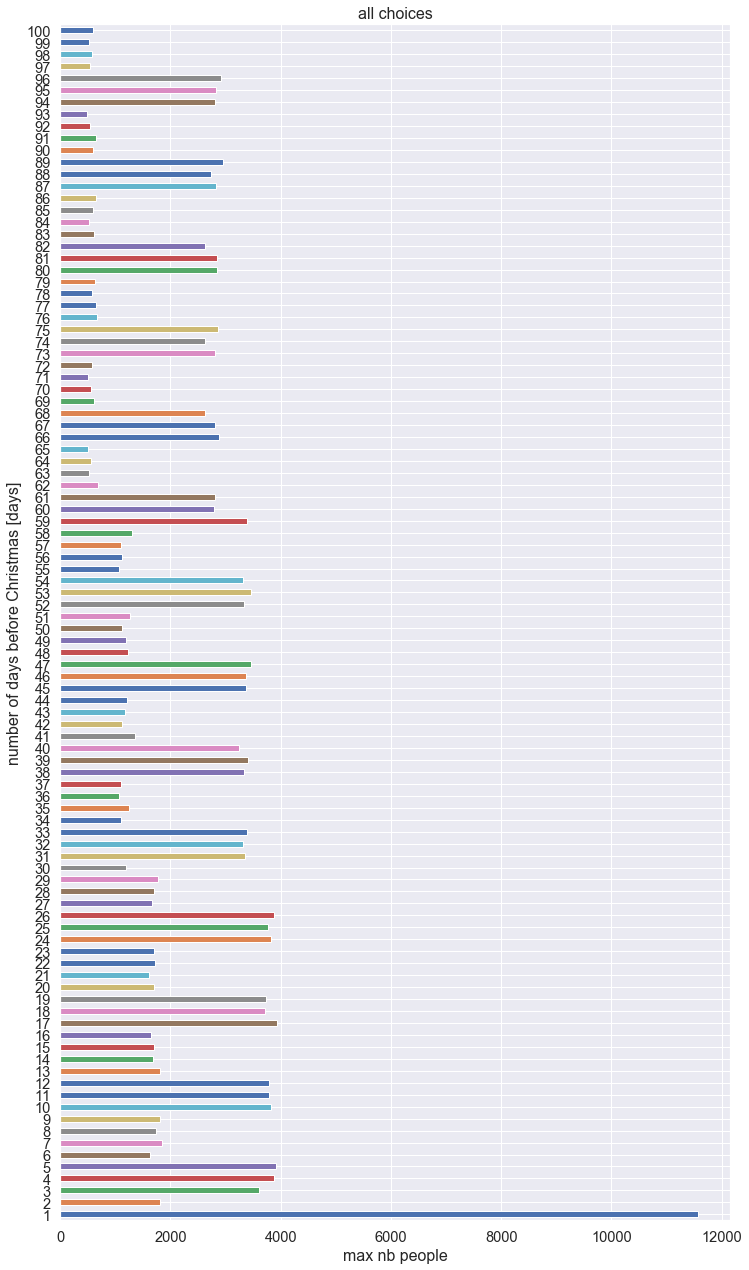

In [74]:
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_day["all_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("all choices");

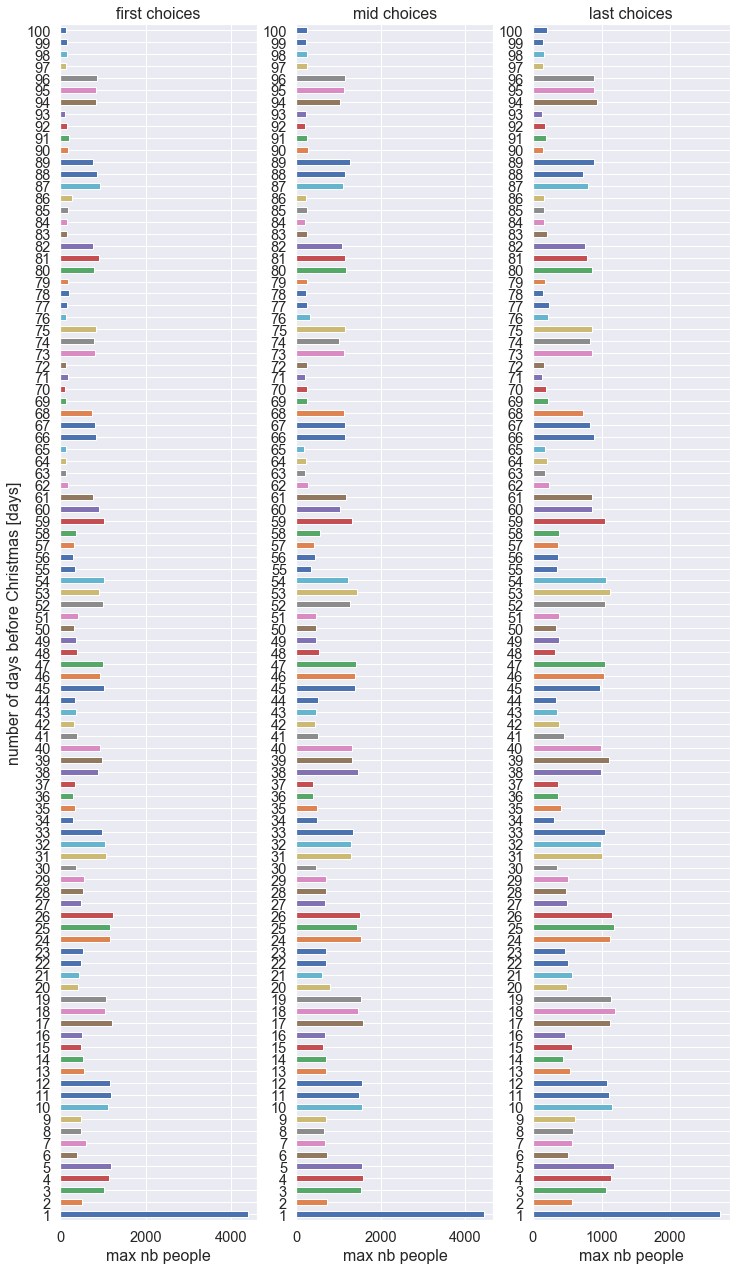

In [75]:
fig = plt.figure(figsize=(12, 22)) 
#plt.title("potential people vs choices")

ax1 = fig.add_subplot(1,3,1)
df_day["first_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("first choices")

ax2 = fig.add_subplot(1,3,2)
df_day["mid_choices"].plot.barh(ax=ax2)
ax2.set_xlabel("max nb people")
ax2.set_title("mid choices")

ax3 = fig.add_subplot(1,3,3)
df_day["last_choices"].plot.barh(ax=ax3)
ax3.set_xlabel("max nb people")
ax3.set_title("last choices");

### Creation of probality matrix

In [76]:
df_prob_day = pd.DataFrame(df_day["all_choices"])
df_prob_day["prob"] = 1/df_prob_day["all_choices"]
df_prob_day["prob"] = df_prob_day["prob"] / df_prob_day["prob"].sum()
df_prob_day["prob"].sum()

1.0

In [77]:
df_prob_day.head()

,all_choices,prob
1,11568,0.001098
2,1806,0.007036
3,3607,0.003523
4,3872,0.003282
5,3907,0.003252


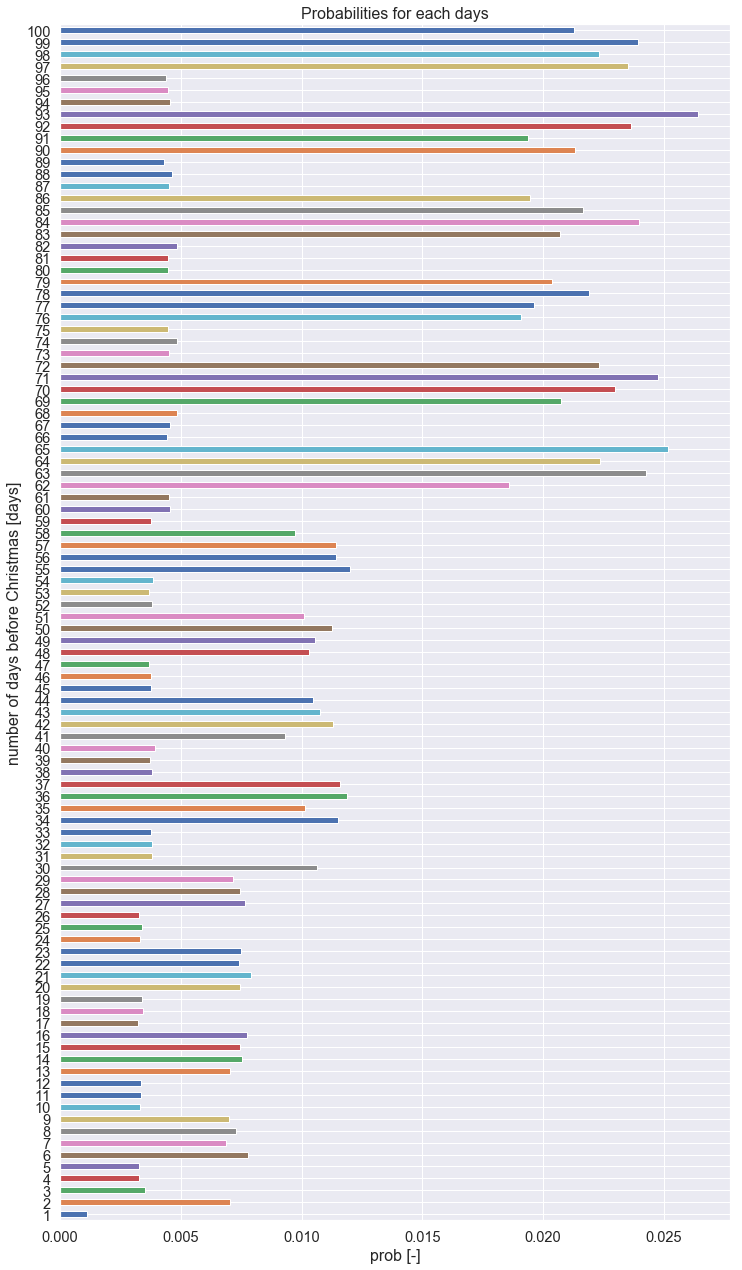

In [78]:
#df_prob_day["prob"].plot.barh()
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_prob_day["prob"].plot.barh(ax=ax1)
ax1.set_xlabel("prob [-]")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");

## Explore family choice cost

In [79]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

### Evolution of cost by number of people into family

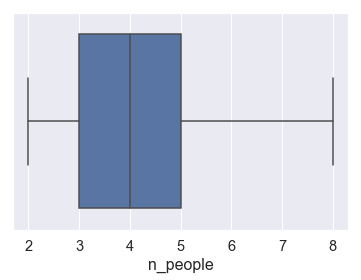

In [80]:
ax = sns.boxplot(x=data["n_people"])


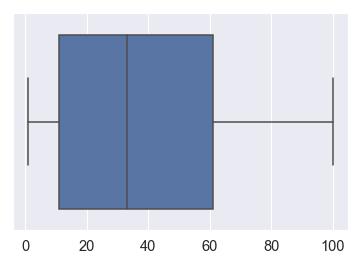

In [81]:
ax = sns.boxplot(data)

In [82]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [83]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,0,50,68,118,218,236,336,372,472,970,1368,2
3,0,50,77,127,227,254,354,408,508,1205,1802,3
4,0,50,86,136,236,272,372,444,544,1440,2236,4
5,0,50,95,145,245,290,390,480,580,1675,2670,5
6,0,50,104,154,254,308,408,516,616,1910,3104,6
7,0,50,113,163,263,326,426,552,652,2145,3538,7
8,0,50,122,172,272,344,444,588,688,2380,3972,8


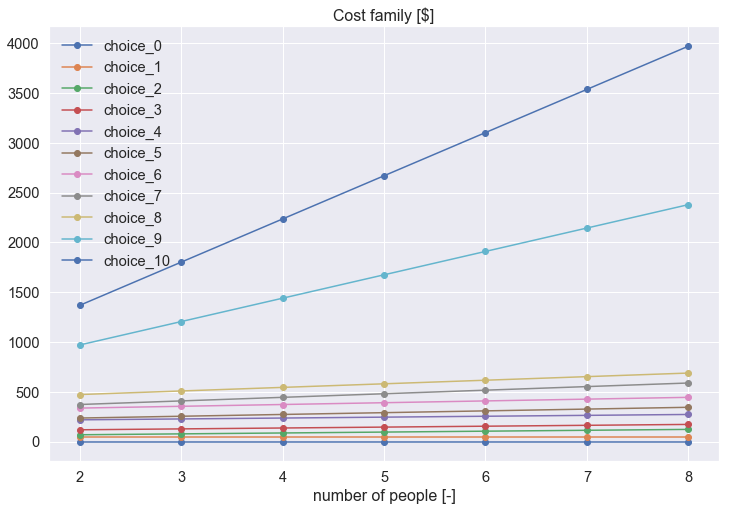

In [84]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

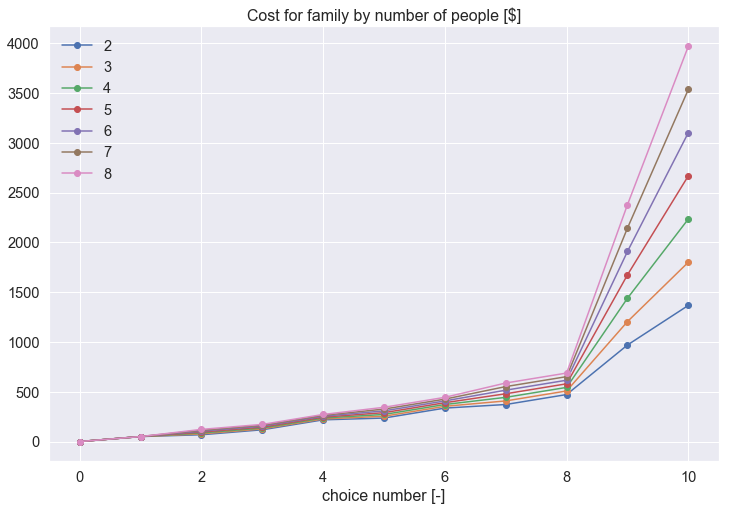

In [85]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [86]:
def create_df_fam_cost_prob(df_fam_cost, p_min=0.03, p_max=0.1):
    # For genetic algo, for start population or mutation,
    # try to assign probabilities of choice for each possibilities : 
    # from  choice 0 to 10.
    list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 
                                                        CHOICE_RANGE_MAX + 1)]
    df_prob = df_fam_cost.filter(items=list_choice)
    vect_penalty = [0, np.max(np.max(df_prob))]
    print("vect_penalty: ", vect_penalty)
    vect_prob = [p_max, p_min]
    print("vect_prob", vect_prob)
    # family : number of people
    df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
    for indice in df_prob.index:
        df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()
    return df_prob  



#### p max = 0.1, p min = 0.03

In [87]:
#df_prob = create_df_fam_cost_prob(df_fam_cost)
#df_prob

#### p max = 1, p min = 0.01

In [88]:
df_prob = create_df_fam_cost_prob(df_fam_cost, p_min=0.01, p_max=1)
df_prob

vect_penalty:  [0, 3972]
vect_prob [1, 0.01]


,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.100491,0.099238,0.098787,0.097535,0.095030,0.094580,0.092075,0.091173,0.088669,0.076195,0.066227
3,0.102556,0.101278,0.100588,0.099310,0.096753,0.096063,0.093507,0.092127,0.089571,0.071754,0.056494
4,0.104708,0.103403,0.102463,0.101158,0.098549,0.097609,0.094999,0.093120,0.090511,0.067127,0.046353
5,0.106952,0.105619,0.104419,0.103087,0.100421,0.099221,0.096556,0.094156,0.091491,0.062301,0.035777
6,0.109294,0.107932,0.106461,0.105099,0.102375,0.100904,0.098180,0.095238,0.092514,0.057264,0.024738
7,0.111742,0.110349,0.108594,0.107202,0.104417,0.102662,0.099877,0.096368,0.093583,0.052001,0.013205
8,0.114301,0.112877,0.110825,0.109401,0.106552,0.104501,0.101652,0.097550,0.094701,0.046497,0.001143


In [89]:
# save
joblib.dump(df_prob, PATH_TO_SAVE_DATA + '/df_prob.pkl')

['../../data/df_prob.pkl']

## Creation of days probabilities by family

In [90]:
df_prob_fam = create_df_prob_day_fam_optim(df_prob_day, df_prob)

In [91]:
df_prob_fam.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
family_id,,,,,,,,,,,,,,,,,,,,,
0,0.000562,0.003601,0.001803,0.001680,0.001665,0.003993,0.003516,0.003738,0.003578,0.048027,...,0.009930,0.012112,0.013522,0.002321,0.002294,0.002234,0.012045,0.011431,0.012249,0.010895
1,0.000562,0.003601,0.001803,0.054608,0.053444,0.051658,0.003516,0.003738,0.003578,0.001698,...,0.009930,0.012112,0.013522,0.002321,0.002294,0.002234,0.012045,0.011431,0.012249,0.010895
2,0.000565,0.003620,0.001813,0.001689,0.001673,0.004014,0.003534,0.003757,0.003596,0.049819,...,0.009982,0.012175,0.013593,0.002333,0.002306,0.002246,0.012107,0.011490,0.012313,0.063720
3,0.051653,0.055604,0.001822,0.001697,0.001682,0.052943,0.003552,0.003776,0.049467,0.001715,...,0.010032,0.012236,0.013661,0.002345,0.053636,0.052695,0.012168,0.011548,0.012375,0.011007
4,0.053490,0.003601,0.051766,0.001680,0.001665,0.003993,0.003516,0.003738,0.003578,0.001698,...,0.009930,0.012112,0.065301,0.002321,0.002294,0.002234,0.012045,0.011431,0.012249,0.010895


In [92]:
# save
joblib.dump(df_prob_fam, PATH_SAVE_PROB_FAM)

['../../data/df_prob_fam.pkl']

## Generate first population

### Load

In [115]:
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob.pkl')
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))

### Random mutation method

In [133]:
#SAVE_POP = 'RANDOM_MUT'
#NB_FIRST_POP = 3
#DELTA_RANDOM_MUT_POP = 1 # delta for first random mut pop
#R_FIRST_RANDOM_MUT = 0.2 # RATIO of mutation for first population in random mut

Generate Random Mutation
Optimizing one by one indiv along random range ...
nb_check:  4
Indiv # 0
         check # 0
Indiv # 1
         check # 0
Indiv # 2
         check # 0
Indiv # 1
         check # 1
Indiv # 0
         check # 1
Indiv # 2
         check # 1
Indiv # 1
         check # 2
Indiv # 2
         check # 2
Indiv # 0
         check # 2
Not better for Indiv # 1
Indiv # 1
         check # 3
Not better for Indiv # 0
Indiv # 0
         check # 3
Not better for Indiv # 2
Indiv # 2
         check # 3
Not better for Indiv # 0
Best cost for indiv # 0 : 440370.1360125023
Not better for Indiv # 1
Best cost for indiv # 1 : 101248957.85802421
Not better for Indiv # 2
Best cost for indiv # 2 : 101271298.8936378
Timing :  78.70082306861877
df_cost:             cost
0  4.403701e+05
1  1.012490e+08
2  1.012713e+08


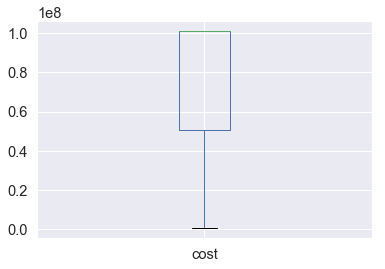

In [128]:
if SAVE_POP == 'RANDOM_MUT':
    print("Generate Random Mutation")
    # Create ranges
    submission = pd.read_csv(fpath, index_col='family_id')
    
    # create normal range 
    #arr_range = np.array([np.arange(submission.shape[0])])
    #arr_range = np.empty((NB_FIRST_POP, submission.shape[0]), dtype=np.int64)
    
    vect_pop_first_0 = submission["assigned_day"].values
        
    # generate first first choice for every families : 
    arr_pop_first_0 = np.empty((NB_FIRST_POP, vect_pop_first_0.shape[0]), 
                               dtype=np.int64)
    for indice in range(NB_FIRST_POP):
        arr_pop_first_0[indice] = vect_pop_first_0
    
    # generated random choice for first pop around 0 + DELTA_CHOICE_RANDOM_POP
    arr_pop_first = fun_vect_mut(arr_pop_first_0, 
                                 r_pop_mut=1, 
                                 r_mut=R_FIRST_RANDOM_MUT, 
                                 delta_choice=DELTA_RANDOM_MUT_POP)
    # replace first line by sample
    arr_pop_first[0] = vect_pop_first_0
    
    # Optimize first pop along one range only
    t_fit_0 = time.time()
    print("Optimizing one by one indiv along random range ...")
    arr_pop, arr_score = boost_optim_one_by_one_epochs(arr_pop_first,
                                                       n_epochs=40, 
                                                       nb_epoch_check=10,
                                                       nb_try_not_best_max=2)
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    df_cost = pd.DataFrame(data=arr_score, columns=["cost"])
    df_cost.boxplot()
    print("df_cost: ", df_cost.sort_values(by="cost").head(10))
    df_pop = pd.DataFrame(arr_pop)
    df_pop

### Random choice method

In [106]:
#SAVE_POP = 'RANDOM_CHOICE'

Generate random Choices
Optimizing one by one indiv along random range ...
nb_check:  10
retry indiv # 0
retry indiv #retry indiv #retry indiv #   250
750
500
Start cost:  6210048769.538701
Start cost:  6609303538.413323
Start cost:  6109934598.023516
Start cost:  6310836018.409163
Score:  4405575524.426673
Score:  3604237478.039081
Score:  3804245443.0026445
Score:  3403811041.8399334
Score:  3704168232.755385
Score:  4305522267.7086935
Score:  3403494204.690326
Score:  3403496298.5213747
Score:  3604162444.007289
Score:  4305516975.878112
Score:  3303486229.1057887
Score:  3303479562.556627
Score:  3604159370.862863
Score:  3303482762.9069114
Score:  4205515417.930911
Score:  3303476461.622388
Score:  3604157929.3506746
Score:  3303481226.631593
Score:  4205514456.637231
Score:  3303474903.6844244
Score:  3303480099.1414313
Score:  3604156944.373196
Score:  4205513966.985616
Score:  3303474065.365751
Score:  3604156228.8029847
Score:  3203479189.841712
Score:  4105513728.575478
Score

Score:  3604837118.316492
Score:  3504158616.937697
Score:  3604160480.656173
Score:  3103474551.089571
Score:  3604837118.316492
Score:  3504158612.583362
Score:  3604160463.45492
Score:  3103474470.0057135
Score:  3604837118.316492
Score:  3504158612.583362
Score:  3604160463.45492
Score:  3103474457.971814
Score:  3604837118.316492
Score:  3504158612.583362
Score:  3604160463.45492
Score:  3103474428.9543176
Score:  3604837118.316492
Score:  3504158612.583362
Score:  3604160463.45492
Score:  3103474416.2625136
Score:  3604837118.316492
Score:  3504158612.583362
Score:  3604160463.45492
Score:  3103474416.2625136
Score:  3604837118.316492
Score:  3504158612.583362
Score:  3604160463.45492
Score:  3103474416.2625136
retry indiv # 501
Start cost:  3103474416.2625136
Score:  3604837118.316492
not better...
retry indiv # 1
Start cost:  3604837118.316492
Score:  3504158612.583362
retry indiv # 751
Start cost:  3504158612.583362
Score:  3604160463.45492
retry indiv # 251
Start cost:  36041

Score:  4405510065.847967
Score:  3505521688.0996485
Score:  4305512738.676388
Score:  3203477425.755463
Score:  4405510065.847967
Score:  3505521688.0996485
Score:  4305512738.676388
not better...
retry indiv # 502
Start cost:  4305512738.676388
Score:  3203477425.755463
Score:  4405510065.847967
not better...
Have to stop ?
retry indiv # 3
Start cost:  6109868570.187298
Score:  3505521688.0996485
not better...
retry indiv # 752
Start cost:  3505521688.0996485
Score:  4305512738.676388
Score:  3203477425.755463
not better...
retry indiv # 252
Start cost:  3203477425.755463
Score:  4004898075.1796064
Score:  3505521688.0996485
Score:  4305512738.676388
Score:  3203477425.755463
Score:  3904842365.843568
Score:  3505521688.0996485
Score:  4305512738.676388
Score:  3203477425.755463
Score:  3904835217.4793606
Score:  3505521688.0996485
Score:  4305512738.676388
Score:  3203477425.755463
Score:  3804833678.2704654
Score:  3505521688.0996485
Score:  4305512738.676388
Score:  3203477425.755

Score:  4204902303.4566073
Score:  3804845759.685805
Score:  3404840495.2304473
not better...
retry indiv # 753
Start cost:  3404840495.2304473
Score:  3904837958.449807
Score:  3804845759.685805
not better...
retry indiv # 253
Start cost:  3804845759.685805
Score:  4204843879.0605354
Score:  3404840495.2304473
Score:  3904837958.449807
Score:  3804845759.685805
Score:  4104836276.802674
Score:  3404840495.2304473
Score:  3904837958.449807
Score:  3804845759.685805
Score:  4104834180.4551916
Score:  3404840495.2304473
Score:  3904837958.449807
Score:  3804845759.685805
Score:  4104832926.2129126
Score:  3404840495.2304473
Score:  3904837958.449807
Score:  3804845759.685805
Score:  4104832334.4983625
Score:  3404840495.2304473
Score:  3904837958.449807
Score:  3804845759.685805
Score:  4104832080.147347
Score:  3404840495.2304473
Score:  3904837958.449807
Score:  3804845759.685805
Score:  4104831576.834394
Score:  3404840495.2304473
Score:  3904837958.449807
Score:  3804845759.685805
Sc

Score:  4506199706.176409
Score:  3304155718.3496237
Score:  3304158186.283341
Score:  4205512612.757105
Score:  4506199706.176409
Score:  3304155694.788212
Score:  3304158186.283341
Score:  4205512612.757105
Score:  4506199706.176409
Score:  3304155694.788212
Score:  3304158186.283341
Score:  4506199706.176409
Score:  4205512612.757105
Score:  3304155694.788212
Score:  3304158186.283341
Score:  4205512612.757105
Score:  4506199706.176409
Score:  3304155694.788212
Score:  3304158186.283341
Score:  4205512612.757105
Score:  4506199706.176409
Score:  3304155694.788212
Score:  3304158186.283341
Score:  4506199706.176409
Score:  4205512612.757105
Score:  3304155694.788212
retry indiv # 505
Start cost:  3304155694.788212
Score:  3304158186.283341
not better...
retry indiv # 5
Start cost:  3304158186.283341
Score:  4506199706.176409
Score:  4205512612.757105
Score:  3304155694.788212
Score:  3304158186.283341
Score:  4506199706.176409
Score:  4205512612.757105
not better...
retry indiv # 755

Score:  3704844718.222048
Score:  3704833876.4927206
Score:  4405507878.054877
Score:  3704835239.66779
Score:  3704844718.222048
Score:  3704833876.4927206
not better...
Have to stop ?
retry indiv # 7
Start cost:  6311364198.435618
Score:  3704835239.66779
Score:  4405507878.054877
Score:  3704844718.222048
not better...
retry indiv # 506
Start cost:  3704844718.222048
Score:  4506265870.050736
Score:  3704835239.66779
not better...
retry indiv # 756
Start cost:  3704835239.66779
Score:  4405507878.054877
Score:  3704844718.222048
Score:  3704835239.66779
Score:  4506205400.174042
Score:  4405507878.054877
not better...
retry indiv # 256
Start cost:  4405507878.054877
Score:  3704844718.222048
Score:  3704835239.66779
Score:  4306198692.198909
Score:  4405507878.054877
Score:  3704844718.222048
Score:  3704835239.66779
Score:  4306196902.928752
Score:  4405507878.054877
Score:  3704844718.222048
Score:  3704835239.66779
Score:  4306195918.978389
Score:  4405507878.054877
Score:  37048

Score:  3904834766.699074
Score:  3203476301.6993465
Score:  3704835246.9212117
Score:  3203476299.8466463
Score:  3904834766.699074
not better...
Have to stop ?
retry indiv # 258
Start cost:  6410515538.512678
Score:  3704835246.9212117
Score:  3203476099.5017066
Score:  3203476299.8466463
Score:  4205553442.8432207
Score:  3203476032.1929
Score:  3704835246.9212117
Score:  3203476299.8466463
Score:  4104850276.4297094
Score:  3203476014.15225
Score:  3704835246.9212117
Score:  3203476299.8466463
Score:  4104840317.1305776
Score:  3203475933.8937783
Score:  3704835246.9212117
Score:  3203476299.8466463
Score:  4004837952.5931845
Score:  3203475929.9734406
Score:  3704835246.9212117
Score:  3203476299.8466463
Score:  4004836968.755909
Score:  3203475895.6330914
Score:  3704835246.9212117
Score:  3203476299.8466463
Score:  4004836195.517021
Score:  3203475891.7156744
Score:  3704835246.9212117
Score:  3203476299.8466463
Score:  4004835667.8098803
Score:  3203475891.7156744
Score:  37048

Score:  3304163378.3244367
Score:  3904829462.1555176
Score:  4006199620.3140154
Score:  4004832730.754138
Score:  3304163367.9567757
Score:  3904829462.1555176
Score:  4006199551.058615
Score:  4004832730.754138
Score:  3304163367.9567757
Score:  3904829462.1555176
Score:  4006199423.312192
Score:  4004832730.754138
Score:  3304163367.9567757
Score:  3904829462.1555176
Score:  4006199368.39596
Score:  4004832730.754138
Score:  3304163367.9567757
Score:  3904829462.1555176
Score:  4006199346.7269163
Score:  4004832730.754138
Score:  3304163367.9567757
Score:  3904829462.1555176
Score:  4006199346.7269163
Score:  4004832730.754138
Score:  3304163367.9567757
Score:  3904829462.1555176
not better...
retry indiv # 9
Start cost:  3904829462.1555176
Score:  4006199346.7269163
Score:  4004832730.754138
not better...
retry indiv # 759
Start cost:  4004832730.754138
Score:  3304163367.9567757
Score:  3904829462.1555176
Score:  4006199346.7269163
retry indiv # 509
Start cost:  4006199346.7269163

Score:  3804836423.015116
Score:  3504154805.1507154
Score:  3404842333.7650166
Score:  3805517179.7337847
Score:  3804836423.015116
Score:  3504154805.1507154
Score:  3404842333.7650166
Score:  3805516960.576671
Score:  3804836423.015116
Score:  3504154805.1507154
Score:  3404842333.7650166
not better...
Have to stop ?
retry indiv # 11
Start cost:  6409988949.399099
Score:  3805516802.052772
Score:  3804836423.015116
Score:  3504154805.1507154
Score:  3804247968.8936057
Score:  3805516668.9007053
retry indiv # 761
Start cost:  3805516668.9007053
Score:  3804836423.015116
not better...
retry indiv # 510
Start cost:  3804836423.015116
Score:  3504154805.1507154
Score:  3804166661.6851892
Score:  3805516648.3027277
Score:  3804836423.015116
Score:  3504154805.1507154
not better...
retry indiv # 260
Start cost:  3504154805.1507154
Score:  3604159121.6610193
Score:  3805516646.1244416
Score:  3804836423.015116
Score:  3504154805.1507154
Score:  3604156849.399124
Score:  3804836423.015116
S

Score:  3504161261.772312
Score:  4004836334.138601
not better...
retry indiv # 511
Start cost:  4004836334.138601
Score:  3604842248.159235
not better...
retry indiv # 762
Start cost:  3604842248.159235
Score:  3604157161.8176465
Score:  3504161261.772312
Score:  4004836334.138601
Score:  3604842248.159235
Score:  3604157161.0726094
Score:  3504161261.772312
not better...
retry indiv # 261
Start cost:  3504161261.772312
Score:  4004836334.138601
Score:  3604842248.159235
Score:  3604157094.3851705
Score:  3504161261.772312
Score:  4004836334.138601
Score:  3604842248.159235
Score:  3604157069.7069907
Score:  4004836334.138601
Score:  3504161261.772312
Score:  3604842248.159235
Score:  3604157069.7069907
Score:  3504161261.772312
Score:  4004836334.138601
Score:  3604842248.159235
Score:  3604157069.7069907
Score:  3504161261.772312
Score:  4004836334.138601
Score:  3604842248.159235
Score:  3604157069.7069907
Score:  3504161261.772312
Score:  4004836334.138601
Score:  3604842248.15923

Score:  2802797343.1439137
Score:  3804843373.6675453
Score:  4104849158.534544
Score:  3504156972.266752
Score:  2802797343.1439137
not better...
Have to stop ?
retry indiv # 263
Start cost:  6009854286.574096
Score:  3804834356.3407865
Score:  4104842456.495802
Score:  3504156972.266752
Score:  4406255029.377669
Score:  4104840076.0492115
Score:  3804832064.4505267
Score:  3504156972.266752
Score:  4306208823.009579
Score:  3804831030.1736684
Score:  4104839233.549469
Score:  3504156972.266752
Score:  4206203108.587215
Score:  3804830340.8580055
Score:  4004839425.066504
Score:  3504156972.266752
Score:  4106201443.1840916
Score:  3804829575.628273
Score:  3904839271.910107
Score:  3504156972.266752
Score:  4106200786.7386966
Score:  3804829412.5142765
Score:  3904838994.2484293
Score:  3504156972.266752
not better...
retry indiv # 13
Start cost:  3504156972.266752
Score:  4106200507.2717085
Score:  3804829221.56035
Score:  3904838872.596864
Score:  3504156972.266752
Score:  41062003

Score:  2702798691.5287066
Score:  4104832485.697568
Score:  4406197053.738596
Score:  3504843156.955996
Score:  2702798691.5287066
Score:  4104832485.697568
Score:  3504843156.955996
Score:  4406197053.738596
Score:  2702798691.5287066
Score:  4104832485.697568
Score:  3504843156.955996
not better...
Have to stop ?
retry indiv # 15
Start cost:  6010635669.871528
Score:  4406197053.738596
Score:  2702798691.5287066
Score:  4104832485.697568
Score:  4406197053.738596
Score:  3605607065.3337727
Score:  2702798691.5287066
Score:  4104832485.697568
Score:  4406197053.738596
Score:  3504866862.7525544
Score:  2702798691.5287066
retry indiv # 765
Start cost:  2702798691.5287066
Score:  4104832485.697568
retry indiv # 514
Start cost:  4104832485.697568
Score:  4406197053.738596
Score:  3504853202.620251
Score:  2702798691.5287066
Score:  4104832485.697568
Score:  4406197053.738596
Score:  3504850679.064098
Score:  2702798691.5287066
Score:  4104832485.697568
Score:  4406197053.738596
not bett

Score:  4104825951.970913
Score:  3904829496.2539606
Score:  3203472665.458492
Score:  3203473672.9335494
Score:  4104825951.970913
Score:  3904829496.2539606
Score:  3203472665.458492
Score:  3203473672.9335494
not better...
retry indiv # 515
Start cost:  3203473672.9335494
Score:  4104825951.970913
not better...
retry indiv # 766
Start cost:  4104825951.970913
Score:  3904829496.2539606
Score:  3203472665.458492
Score:  3203473672.9335494
Score:  4104825951.970913
Score:  3904829496.2539606
Score:  3203472665.458492
Score:  3203473672.9335494
Score:  4104825951.970913
Score:  3203472665.458492
not better...
retry indiv # 265
Start cost:  3203472665.458492
Score:  3904829496.2539606
Score:  3203473672.9335494
Score:  4104825951.970913
Score:  3203472665.458492
Score:  3904829496.2539606
Score:  3203473672.9335494
Score:  4104825951.970913
Score:  3203472665.458492
Score:  3904829496.2539606
Score:  3203473672.9335494
Score:  4104825951.970913
Score:  3203472665.458492
Score:  39048294

Score:  3805522954.4927106
Score:  3904832719.5487647
Score:  4305509871.294138
Score:  3704147612.78489
Score:  3904832719.5487647
Score:  3805522954.4927106
Score:  4305508833.465046
Score:  3704147612.78489
Score:  3904832719.5487647
Score:  3805522954.4927106
not better...
Have to stop ?
retry indiv # 267
Start cost:  6609686990.536749
Score:  3704147612.78489
Score:  4305508507.897891
Score:  3904832719.5487647
Score:  4405973942.466754
Score:  4305508259.239171
Score:  3704147612.78489
Score:  3904832719.5487647
Score:  4405527526.850932
Score:  3704147612.78489
Score:  4305508201.654114
Score:  4305518452.64063
Score:  3904832719.5487647
Score:  3704147612.78489
Score:  4305508194.966705
Score:  3904832719.5487647
Score:  4305515873.658431
Score:  3704147612.78489
Score:  4305508194.966705
retry indiv # 18
Start cost:  4305508194.966705
Score:  4205517114.1268296
Score:  3904832719.5487647
Score:  4305508194.966705
Score:  3704147612.78489
Score:  4205516708.6483297
Score:  3904

Score:  4205519716.9347386
Score:  3504156432.095294
Score:  3404163072.843956
Score:  4205518630.68718
Score:  3804836831.3217044
Score:  3504156325.5960054
Score:  3404162407.7511125
Score:  4205518463.7905126
Score:  3804836831.3217044
Score:  3504156270.858902
Score:  3404161444.365422
Score:  4205518327.9714193
Score:  3804836831.3217044
not better...
retry indiv # 19
Start cost:  3804836831.3217044
Score:  3504156270.323876
Score:  3404160942.9802284
Score:  4205518214.245932
Score:  3804836831.3217044
Score:  3504156270.323876
Score:  3404160603.710471
Score:  4205518203.853511
Score:  3804836831.3217044
Score:  3504156270.323876
Score:  3404160325.101389
retry indiv # 518
Start cost:  3404160325.101389
Score:  4205518203.853511
retry indiv # 769
Start cost:  4205518203.853511
Score:  3804836831.3217044
Score:  3504156270.323876
Score:  3404160128.2647166
Score:  4205518203.853511
Score:  3804836831.3217044
Score:  3504156270.323876
Score:  3404159982.8191795
Score:  4205518203.

Score:  4806190443.0361185
Score:  4004835760.141718
Score:  3204157192.050075
Score:  3904830983.168643
Score:  4806190443.0361185
Score:  4004835760.141718
Score:  3204157192.050075
Score:  3904830983.168643
Score:  4806190443.0361185
Score:  4004835760.141718
retry indiv # 519
Start cost:  4004835760.141718
Score:  3204157192.050075
Score:  3904830983.168643
Score:  4806190443.0361185
not better...
retry indiv # 770
Start cost:  4806190443.0361185
Score:  4004835760.141718
Score:  3204157192.050075
Score:  3904830983.168643
Score:  4806190443.0361185
Score:  3204157192.050075
Score:  4004835760.141718
Score:  3904830983.168643
Score:  4806190443.0361185
Score:  3204157192.050075
not better...
retry indiv # 269
Start cost:  3204157192.050075
Score:  4004835760.141718
Score:  3904830983.168643
Score:  4806190443.0361185
Score:  3204157192.050075
Score:  4004835760.141718
Score:  3904830983.168643
Score:  4806190443.0361185
Score:  3204157192.050075
Score:  4004835760.141718
Score:  39

Score:  4004833111.5245233
Score:  3504159835.8993297
not better...
Have to stop ?
retry indiv # 772
Start cost:  6412005299.002137
Score:  4305507336.421422
Score:  3404164578.354304
Score:  4004832811.2499127
Score:  4104922260.082164
Score:  4305507336.421422
Score:  3304164327.2664857
Score:  4004832248.3895545
Score:  4305507336.421422
Score:  4104847888.7119246
Score:  3304164057.3514915
Score:  4004832151.8304095
retry indiv # 271
Start cost:  4004832151.8304095
Score:  4305507336.421422
Score:  4104836513.063113
Score:  3304163874.027488
Score:  4004832147.835643
Score:  4305507336.421422
Score:  4104834688.5694733
Score:  3304163830.3400984
Score:  4004832147.835643
Score:  4305507336.421422
Score:  4104833389.513578
Score:  3304163830.3400984
retry indiv # 22
Start cost:  3304163830.3400984
Score:  4004832147.835643
Score:  4305507336.421422
Score:  4004834861.5335274
Score:  3304163830.3400984
Score:  4004832147.835643
Score:  4305507336.421422
Score:  3304163830.3400984
Sco

Score:  4205514678.425216
Score:  3003488279.796434
Score:  4105515629.7830887
Score:  3504839910.7115474
Score:  4205514678.425216
Score:  3003488279.796434
Score:  4105515629.7830887
Score:  3504839910.7115474
Score:  4205514678.425216
Score:  3003488279.796434
not better...
retry indiv # 23
Start cost:  3003488279.796434
Score:  3504839910.7115474
Score:  4105515629.7830887
Score:  4205514678.425216
Score:  3003488279.796434
Score:  4105515629.7830887
Score:  3504839910.7115474
Score:  4205514678.425216
Score:  3003488279.796434
Score:  4105515629.7830887
Score:  3504839910.7115474
Score:  4205514678.425216
not better...
Have to stop ?
retry indiv # 522
Start cost:  6211002668.460629
Score:  3003488279.796434
Score:  4105515629.7830887
Score:  3504839910.7115474
Score:  4105007551.4237123
Score:  3003488279.796434
Score:  4105515629.7830887
not better...
retry indiv # 773
Start cost:  4105515629.7830887
Score:  3504839910.7115474
Score:  3904850924.3531513
Score:  3003488279.796434


Score:  3504841276.3304405
Score:  3504156501.880885
Score:  4506193971.949476
Score:  3905522864.429336
Score:  3504841276.3304405
Score:  3504156501.880885
Score:  4506193971.949476
Score:  3905522761.899777
Score:  3504841276.3304405
Score:  3504156501.880885
Score:  4506193971.949476
Score:  3905522508.8979335
retry indiv # 523
Start cost:  3905522508.8979335
Score:  3504841276.3304405
Score:  3504156501.880885
Score:  4506193971.949476
Score:  3905522146.156591
Score:  3504841276.3304405
not better...
retry indiv # 774
Start cost:  3504841276.3304405
Score:  3504156501.880885
Score:  4506193971.949476
Score:  3905522117.3370576
Score:  3504841276.3304405
Score:  3504156501.880885
Score:  4506193971.949476
Score:  3905521986.393137
Score:  3504841276.3304405
Score:  3504156501.880885
Score:  4506193971.949476
not better...
retry indiv # 273
Start cost:  4506193971.949476
Score:  3905521910.3802023
Score:  3504841276.3304405
Score:  3504156501.880885
Score:  4506193971.949476
Score:

Score:  3103475269.0506387
Score:  4105509070.949008
not better...
Have to stop ?
retry indiv # 776
Start cost:  6510744334.371657
Score:  3704831598.637268
Score:  3504156822.4388556
Score:  3103474949.0621696
Score:  4104919877.181383
Score:  3704831598.637268
Score:  3504156627.3014326
Score:  3103474926.731753
Score:  4104844392.3146715
Score:  3704831598.637268
not better...
Have to stop ?
retry indiv # 275
Start cost:  6210797812.384367
Score:  3504156159.529648
Score:  3103474924.4177094
Score:  4104837369.165493
Score:  3103474916.775772
Score:  3504155981.440158
Score:  3705561562.9861927
Score:  4004835074.8367424
Score:  3103474910.4111686
Score:  3504155853.685134
retry indiv # 26
Start cost:  3504155853.685134
Score:  3704864353.424316
Score:  4004833572.609677
Score:  3604175428.194242
Score:  3504155720.1307583
Score:  3103474902.948433
Score:  4004832946.1253147
Score:  3604168859.695133
Score:  3504155660.715981
Score:  3103474902.948433
Score:  4004832762.155309
Score

Score:  3203477362.747222
Score:  3404156456.0611935
Score:  4004832245.10935
Score:  3905520114.3299866
Score:  3203477298.2251186
Score:  3404156456.0611935
Score:  4004831928.433366
Score:  3905520114.3299866
Score:  3203477296.702386
Score:  3404156456.0611935
retry indiv # 27
Start cost:  3404156456.0611935
Score:  3905520114.3299866
Score:  4004831734.832958
Score:  3203477259.2753377
Score:  3404156456.0611935
Score:  3905520114.3299866
Score:  4004831559.442319
Score:  3203477256.8942037
Score:  3404156456.0611935
Score:  3905520114.3299866
Score:  4004831489.7720914
Score:  3203477251.823862
Score:  3404156456.0611935
Score:  3905520114.3299866
not better...
retry indiv # 525
Start cost:  3905520114.3299866
Score:  4004831482.854683
Score:  3203477251.823862
Score:  3404156456.0611935
Score:  4004831482.4724813
Score:  3905520114.3299866
Score:  3203477251.823862
Score:  3404156456.0611935
Score:  4004831482.4724813
Score:  3905520114.3299866
Score:  3203477251.823862
retry in

Score:  4005515831.0589395
Score:  3704149151.2544703
Score:  3904831463.880441
Score:  3604162364.6732063
Score:  4005515831.0589395
Score:  3704149151.2544703
Score:  3904831463.880441
Score:  3604162364.6732063
Score:  4005515831.0589395
Score:  3704149151.2544703
Score:  3904831463.880441
not better...
retry indiv # 526
Start cost:  3904831463.880441
Score:  3604162364.6732063
Score:  4005515831.0589395
Score:  3704149151.2544703
Score:  3904831463.880441
Score:  3604162364.6732063
Score:  4005515831.0589395
Score:  3704149151.2544703
Score:  3904831463.880441
Score:  3604162364.6732063
Score:  4005515831.0589395
Score:  3704149151.2544703
not better...
retry indiv # 778
Start cost:  3704149151.2544703
Score:  3904831463.880441
Score:  4005515831.0589395
Score:  3604162364.6732063
Score:  3704149151.2544703
Score:  3904831463.880441
Score:  4005515831.0589395
Score:  3604162364.6732063
not better...
retry indiv # 277
Start cost:  3604162364.6732063
Score:  3704149151.2544703
Score:

Score:  3704152014.5069275
Score:  3804834253.8043156
Score:  3304158178.2859893
not better...
Have to stop ?
retry indiv # 528
Start cost:  6309893362.086192
Score:  3704151418.1470113
Score:  3704152014.5069275
Score:  3804834253.8043156
Score:  4505592265.4912405
Score:  3704152014.5069275
Score:  3704150743.0887437
Score:  3804834253.8043156
Score:  4405521653.181757
Score:  3604150611.0648055
Score:  3704152014.5069275
not better...
retry indiv # 779
Start cost:  3704152014.5069275
Score:  3804834253.8043156
Score:  4405513136.220481
Score:  3704152014.5069275
Score:  3604150399.7962656
Score:  3804834253.8043156
not better...
retry indiv # 278
Start cost:  3804834253.8043156
Score:  4405510395.015942
Score:  3704152014.5069275
Score:  3604150348.539887
Score:  3804834253.8043156
Score:  4405508984.454788
Score:  3704152014.5069275
Score:  3604150210.2656364
retry indiv # 30
Start cost:  3604150210.2656364
Score:  3804834253.8043156
Score:  4305508913.614793
Score:  3704152014.506

Score:  3504148848.5523176
not better...
Have to stop ?
retry indiv # 781
Start cost:  5809865993.557978
Score:  4104834046.084949
Score:  3203474090.163171
Score:  3604150634.845149
Score:  3304931338.2155867
Score:  4104834038.845874
Score:  3203474090.163171
not better...
Have to stop ?
retry indiv # 280
Start cost:  6510918580.281034
Score:  3604150634.845149
Score:  3304180977.752873
Score:  4104834029.5883174
Score:  3804241202.429742
Score:  3604150634.845149
not better...
retry indiv # 31
Start cost:  3604150634.845149
Score:  3304167245.983799
Score:  4104834029.5883174
Score:  3704162731.239562
Score:  3604150634.845149
Score:  3304164176.5827565
Score:  4104834029.5883174
Score:  3704155053.940827
Score:  3604150634.845149
Score:  3304163019.1196384
Score:  4104834029.5883174
Score:  3704153226.4279118
Score:  3604150634.845149
Score:  3304162505.2896223
Score:  4104834029.5883174
Score:  3704151908.300141
Score:  3604150634.845149
Score:  4104834029.5883174
retry indiv # 52

Score:  4505512896.151805
Score:  3504148932.233252
Score:  4004835637.2189426
Score:  4005512380.767996
not better...
retry indiv # 32
Start cost:  4005512380.767996
Score:  4505512896.151805
Score:  3504148932.233252
Score:  4004835637.2189426
Score:  4005512380.767996
Score:  4505512896.151805
Score:  3504148932.233252
Score:  4004835637.2189426
Score:  4005512380.767996
Score:  3504148932.233252
Score:  4505512896.151805
Score:  4004835637.2189426
Score:  4005512380.767996
Score:  3504148932.233252
Score:  4505512896.151805
Score:  4004835637.2189426
not better...
retry indiv # 530
Start cost:  4004835637.2189426
Score:  4005512380.767996
Score:  3504148932.233252
Score:  4505512896.151805
Score:  4004835637.2189426
Score:  4005512380.767996
Score:  3504148932.233252
Score:  4505512896.151805
Score:  4004835637.2189426
Score:  3504148932.233252
retry indiv # 782
Start cost:  3504148932.233252
Score:  4005512380.767996
Score:  4505512896.151805
Score:  4004835637.2189426
Score:  400

Score:  3904837057.8023763
Score:  3604159885.0674143
Score:  4505512321.039222
not better...
retry indiv # 531
Start cost:  4505512321.039222
Score:  3604157131.8214684
Score:  3904837057.8023763
Score:  3604159885.0674143
Score:  4505512321.039222
Score:  3604157131.8214684
Score:  3904837057.8023763
Score:  3604159885.0674143
Score:  4505512321.039222
Score:  3604157131.8214684
Score:  3904837057.8023763
Score:  3604159885.0674143
not better...
retry indiv # 783
Start cost:  3604159885.0674143
Score:  4505512321.039222
Score:  3604157131.8214684
Score:  3904837057.8023763
Score:  3604159885.0674143
Score:  4505512321.039222
Score:  3604157131.8214684
Score:  3904837057.8023763
Score:  3604159885.0674143
Score:  4505512321.039222
Score:  3604157131.8214684
not better...
retry indiv # 282
Start cost:  3604157131.8214684
Score:  3904837057.8023763
Score:  3604159885.0674143
Score:  4505512321.039222
Score:  3604157131.8214684
Score:  3904837057.8023763
Score:  3604159885.0674143
Score:

Score:  3203489922.22936
Score:  4305511033.373082
not better...
Have to stop ?
retry indiv # 785
Start cost:  6510221228.461043
Score:  3905519291.89458
Score:  3404161971.054967
Score:  3203486392.9658246
Score:  3905519291.89458
Score:  3604015287.2154613
Score:  3203485102.1864495
Score:  3404161971.054967
Score:  3905519291.89458
not better...
Have to stop ?
retry indiv # 284
Start cost:  6508978289.690597
Score:  3303504426.0232973
Score:  3203484498.207769
Score:  3404161971.054967
Score:  3303491873.3784432
Score:  3604237038.0459843
Score:  3103484064.1281185
Score:  3404161971.054967
Score:  3203487607.8573403
Score:  3604174334.596446
Score:  3103483477.0603004
Score:  3404161971.054967
not better...
retry indiv # 35
Start cost:  3404161971.054967
Score:  3203485947.2338557
Score:  3604165321.0875163
Score:  3103483390.6195817
Score:  3404161971.054967
Score:  3203485117.601043
Score:  3504163824.83817
Score:  3404161971.054967
Score:  3103483387.7034354
retry indiv # 533
St

Score:  4205510499.6774635
Score:  4005519185.9410977
Score:  3204161098.6177883
Score:  4205506018.228426
Score:  4005519185.9410977
Score:  4205510499.6774635
Score:  3204161098.6177883
Score:  4205505998.5329247
Score:  4005519185.9410977
Score:  4205510499.6774635
Score:  3204161098.6177883
not better...
Have to stop ?
retry indiv # 37
Start cost:  5609063134.200543
Score:  4205505975.257507
Score:  4005519185.9410977
Score:  4205510499.6774635
Score:  3604235453.59905
Score:  4205505975.257507
Score:  4005519185.9410977
retry indiv # 534
Start cost:  4005519185.9410977
Score:  4205510499.6774635
Score:  3604164845.5150256
Score:  4205505975.257507
Score:  4205510499.6774635
Score:  4005519185.9410977
Score:  3504155441.1345096
Score:  4205505975.257507
Score:  4205510499.6774635
Score:  4005519185.9410977
Score:  3504153067.8389215
Score:  4205510499.6774635
retry indiv # 786
Start cost:  4205510499.6774635
Score:  4205505975.257507
Score:  4005519185.9410977
Score:  3504152013.36

Score:  3604843756.452107
Score:  2903483838.173455
Score:  3604151283.072647
Score:  3304161481.1803102
not better...
retry indiv # 535
Start cost:  3304161481.1803102
Score:  3604843756.452107
Score:  2903483838.173455
Score:  3604151274.999994
Score:  3304161481.1803102
Score:  3604843756.452107
Score:  3604151274.999994
Score:  2903483838.173455
Score:  3304161481.1803102
Score:  3604843756.452107
Score:  3604151274.999994
Score:  2903483838.173455
not better...
retry indiv # 787
Start cost:  2903483838.173455
Score:  3304161481.1803102
Score:  3604843756.452107
Score:  3604151274.999994
Score:  2903483838.173455
Score:  3304161481.1803102
Score:  3604843756.452107
Score:  3604151274.999994
Score:  2903483838.173455
Score:  3304161481.1803102
Score:  3604843756.452107
Score:  2903483838.173455
Score:  3604151274.999994
Score:  3304161481.1803102
Score:  3604843756.452107
not better...
retry indiv # 286
Start cost:  3604843756.452107
Score:  2903483838.173455
Score:  3604151274.9999

Score:  4004846820.4555016
Score:  4004831891.451251
Score:  4004831592.5158343
not better...
Have to stop ?
retry indiv # 789
Start cost:  6710171247.980052
Score:  4205514910.3019667
Score:  4004831891.451251
Score:  4004839982.9385524
Score:  3704236658.540558
Score:  4205514910.3019667
Score:  4004831891.451251
Score:  3904838351.110153
Score:  4205514910.3019667
Score:  3504174809.798174
Score:  4004831891.451251
Score:  3904837525.7775464
Score:  4205514910.3019667
Score:  3504166601.691632
Score:  4004831891.451251
not better...
retry indiv # 287
Start cost:  4004831891.451251
Score:  3904836624.33173
Score:  4205514910.3019667
Score:  3504163484.8707566
Score:  4004831891.451251
Score:  3904836257.765665
Score:  4205514910.3019667
not better...
retry indiv # 39
Start cost:  4205514910.3019667
Score:  3504161852.83242
Score:  3904836222.3389983
Score:  4004831891.451251
Score:  4205514910.3019667
Score:  3504161120.8434806
Score:  4004831891.451251
Score:  3904836000.331128
Scor

Score:  4105516286.710961
Score:  3404165661.9120965
Score:  3203474434.9287014
Score:  4206877330.879083
not better...
Have to stop ?
retry indiv # 289
Start cost:  5909890931.923408
Score:  4105516286.710961
Score:  3404162291.644491
Score:  3203474434.9287014
Score:  3804233819.54012
Score:  4105516286.710961
Score:  3203474434.9287014
not better...
retry indiv # 40
Start cost:  3203474434.9287014
Score:  3404161246.780757
Score:  3704168878.110606
Score:  3203474434.9287014
Score:  4105516286.710961
Score:  3404160875.3744683
Score:  3504160100.2763243
Score:  3203474434.9287014
Score:  4105516286.710961
retry indiv # 538
Start cost:  4105516286.710961
Score:  3404160370.6624117
Score:  3504156378.938875
Score:  3203474434.9287014
Score:  4105516286.710961
Score:  3404160010.063852
Score:  3504155081.7267823
Score:  3203474434.9287014
Score:  4105516286.710961
Score:  3404159826.4507647
Score:  3404154890.732899
Score:  3203474434.9287014
Score:  4105516286.710961
Score:  340415974

Score:  4205517866.144413
Score:  3504834885.142881
Score:  3604840740.2402062
Score:  4104837227.8524847
not better...
retry indiv # 539
Start cost:  4104837227.8524847
Score:  4205517862.282273
Score:  3504834876.331282
Score:  4104837227.8524847
Score:  3604840688.4251003
Score:  4205517862.282273
Score:  3504834876.331282
Score:  4104837227.8524847
Score:  3604840676.790711
Score:  4205517862.282273
Score:  3504834876.331282
Score:  4104837227.8524847
Score:  3604840614.6718507
Score:  4205517862.282273
Score:  3504834876.331282
retry indiv # 791
Start cost:  3504834876.331282
Score:  4104837227.8524847
Score:  3604840580.0547085
Score:  4205517862.282273
Score:  3504834876.331282
Score:  4104837227.8524847
Score:  3604840576.275648
Score:  4205517862.282273
Score:  3504834876.331282
Score:  4104837227.8524847
Score:  3604840576.275648
Score:  4205517862.282273
Score:  3504834876.331282
Score:  4104837227.8524847
Score:  3604840576.275648
Score:  4205517862.282273
retry indiv # 290

Score:  4505507669.294785
not better...
retry indiv # 792
Start cost:  4505507669.294785
Score:  3604842371.0776772
Score:  3904833182.105
Score:  3303472815.9676356
Score:  4505507669.294785
Score:  3604840932.484944
Score:  3904833182.105
Score:  3303472815.9676356
Score:  4505507669.294785
Score:  3504839628.886576
Score:  3904833182.105
Score:  3303472815.9676356
Score:  4505507669.294785
Score:  3904833182.105
not better...
retry indiv # 291
Start cost:  3904833182.105
Score:  3504839142.417612
Score:  3303472815.9676356
Score:  4505507669.294785
Score:  3904833182.105
Score:  3504838756.813792
Score:  3303472815.9676356
Score:  4505507669.294785
Score:  3904833182.105
Score:  3504838718.999121
Score:  3303472815.9676356
not better...
retry indiv # 43
Start cost:  3303472815.9676356
Score:  4505507669.294785
Score:  3904833182.105
Score:  3504838674.98636
retry indiv # 541
Start cost:  3504838674.98636
Score:  3303472815.9676356
Score:  4505507669.294785
Score:  3904833182.105
Sco

Score:  3904833627.4623094
Score:  3704148728.9911613
Score:  4506191437.670487
Score:  3904235433.9759727
Score:  3904833627.4623094
Score:  3704148685.4587803
Score:  4506191437.670487
not better...
retry indiv # 44
Start cost:  4506191437.670487
Score:  3804169342.6670046
Score:  3904833627.4623094
Score:  3704148658.425147
Score:  4506191437.670487
Score:  3804159694.0913773
Score:  3904833627.4623094
Score:  3704148598.8079686
retry indiv # 542
Start cost:  3704148598.8079686
Score:  4506191437.670487
Score:  3704159158.9218044
Score:  3904833627.4623094
Score:  3704148548.3465347
Score:  4506191437.670487
Score:  3704158166.471593
Score:  3904833627.4623094
Score:  3704148548.3465347
Score:  4506191437.670487
Score:  3604157306.5461555
Score:  3904833627.4623094
not better...
Have to stop ?
retry indiv # 794
Start cost:  6410132225.91411
Score:  3704148548.3465347
Score:  4506191437.670487
Score:  3604156740.5484753
Score:  3804916539.0990324
Score:  3704148548.3465347
Score:  45

Score:  4004836764.6274614
Score:  3804838851.8947153
Score:  3804158840.4648137
Score:  3704840799.72053
Score:  4004836764.6274614
Score:  3804838816.4025817
Score:  3704840799.72053
Score:  3804155432.9652195
Score:  4004836764.6274614
Score:  3804838816.4025817
retry indiv # 795
Start cost:  3804838816.4025817
Score:  3704840799.72053
Score:  3804153380.240467
Score:  4004836764.6274614
Score:  3804838816.4025817
Score:  3704840799.72053
Score:  3804152626.510201
Score:  4004836764.6274614
Score:  3804838816.4025817
Score:  3704840799.72053
Score:  3804152402.1647124
Score:  4004836764.6274614
Score:  3804838816.4025817
Score:  3704840799.72053
Score:  3804152154.841206
Score:  4004836764.6274614
retry indiv # 294
Start cost:  4004836764.6274614
Score:  3804838816.4025817
Score:  3704840799.72053
Score:  3804151871.8651347
Score:  4004836764.6274614
Score:  3804838816.4025817
Score:  3704840799.72053
Score:  3704152376.2838426
retry indiv # 46
Start cost:  3704152376.2838426
Score:

Score:  3103480642.107707
Score:  4305512474.719205
Score:  3604155364.9112787
Score:  4205513267.2810493
Score:  3103480642.107707
Score:  4305512474.719205
Score:  3604155364.9112787
Score:  4205513267.2810493
Score:  4305512474.719205
not better...
retry indiv # 295
Start cost:  4305512474.719205
Score:  3103480642.107707
Score:  3604155364.9112787
Score:  4205513267.2810493
Score:  3103480642.107707
Score:  4305512474.719205
Score:  3604155364.9112787
retry indiv # 47
Start cost:  3604155364.9112787
Score:  4205513267.2810493
Score:  3103480642.107707
Score:  4305512474.719205
Score:  3604155364.9112787
Score:  4205513267.2810493
Score:  3103480642.107707
Score:  4305512474.719205
Score:  3604155364.9112787
Score:  4205513267.2810493
Score:  3103480642.107707
not better...
Have to stop ?
Score:  4305512474.719205
retry indiv # 545
Start cost:  6810948893.13894
Score:  3604155364.9112787
Score:  4205513267.2810493
Score:  4305512474.719205
Score:  4305580963.853332
Score:  360415536

Score:  3504156397.9243097
Score:  4004831544.2764854
Score:  3104158958.6459002
Score:  4205513030.4742737
Score:  3504156397.9243097
not better...
retry indiv # 48
Start cost:  3504156397.9243097
Score:  3104158958.6459002
Score:  3904833279.4811482
Score:  4205513030.4742737
Score:  3504156397.9243097
Score:  3104158958.6459002
Score:  3904833076.2339525
Score:  4205513030.4742737
Score:  3504156397.9243097
Score:  3104158958.6459002
Score:  3904832934.9017386
Score:  4205513030.4742737
Score:  3504156397.9243097
Score:  3104158958.6459002
Score:  3904832875.319101
retry indiv # 546
Start cost:  3904832875.319101
Score:  4205513030.4742737
Score:  3504156397.9243097
Score:  3104158958.6459002
Score:  4205513030.4742737
Score:  3904832848.479167
Score:  3504156397.9243097
Score:  3104158958.6459002
not better...
Have to stop ?
retry indiv # 798
Start cost:  6210448876.772681
Score:  4205513030.4742737
Score:  3904832831.8062134
Score:  3504156397.9243097
Score:  4104917039.325523
Sco

Score:  4004828763.9139724
Score:  4405512319.13058
Score:  3704841480.970785
Score:  3504154991.716912
Score:  4405512319.13058
Score:  4004828640.097485
Score:  3704839794.802581
Score:  3504154991.716912
retry indiv # 547
Start cost:  3504154991.716912
Score:  4004828555.4703655
Score:  4405512319.13058
Score:  3704838968.7134814
Score:  3504154991.716912
Score:  4004828506.801268
retry indiv # 799
Start cost:  4004828506.801268
Score:  4405512319.13058
Score:  3704838366.5446453
Score:  3504154991.716912
Score:  4004828495.0871544
Score:  4405512319.13058
Score:  3704838066.0610313
Score:  3504154991.716912
Score:  4004828485.2988524
Score:  4405512319.13058
Score:  3704837813.903323
Score:  3504154991.716912
Score:  4004828476.68605
Score:  4405512319.13058
Score:  3704837594.898023
retry indiv # 298
Start cost:  3704837594.898023
Score:  3504154991.716912
Score:  4405512319.13058
Score:  4004828460.438973
Score:  3704837327.8353095
Score:  3504154991.716912
Score:  4405512319.130

Score:  4004832244.8281455
Score:  4305514331.072709
Score:  4305517458.3369055
Score:  4206197923.3801727
Score:  4004832244.8281455
Score:  4305516848.860484
Score:  4305514331.072709
Score:  4206197923.3801727
Score:  4004832244.8281455
Score:  4305516432.31605
Score:  4305514331.072709
Score:  4206197923.3801727
Score:  4004832244.8281455
Score:  4205515874.5987453
Score:  4305514331.072709
Score:  4206197923.3801727
Score:  4004832244.8281455
retry indiv # 299
Start cost:  4004832244.8281455
Score:  4305514331.072709
Score:  4205515706.323667
retry indiv # 51
Start cost:  4205515706.323667
Score:  4206197923.3801727
Score:  4004832244.8281455
Score:  4305514331.072709
Score:  4205515661.541415
Score:  4206197923.3801727
Score:  4004832244.8281455
Score:  4305514331.072709
Score:  4205515652.3441415
Score:  4206197923.3801727
Score:  4004832244.8281455
Score:  4305514331.072709
Score:  4205515579.7180395
Score:  4004832244.8281455
Score:  4206197923.3801727
Score:  4305514331.07270

Score:  3203483523.9844213
Score:  3504152534.8456573
Score:  3904842116.9816694
retry indiv # 52
Start cost:  3904842116.9816694
Score:  3704159354.326202
not better...
retry indiv # 300
Start cost:  3704159354.326202
Score:  3203483523.9844213
Score:  3504152534.8456573
Score:  3904842116.9816694
Score:  3704159354.326202
Score:  3203483523.9844213
Score:  3504152534.8456573
Score:  3904842116.9816694
Score:  3704159354.326202
Score:  3203483523.9844213
Score:  3504152534.8456573
Score:  3904842116.9816694
Score:  3704159354.326202
Score:  3203483523.9844213
Score:  3504152534.8456573
Score:  3704159354.326202
Score:  3904842116.9816694
Score:  3203483523.9844213
not better...
Have to stop ?
retry indiv # 550
Start cost:  6210828652.34702
Score:  3504152534.8456573
Score:  3704159354.326202
Score:  3904842116.9816694
Score:  3504152534.8456573
not better...
retry indiv # 801
Start cost:  3504152534.8456573
Score:  3504254933.052073
Score:  3704159354.326202
Score:  3904842116.9816694

Score:  3204157299.792337
Score:  4104834536.294266
Score:  3504838143.277156
Score:  3504158521.1003704
Score:  3204157299.792337
Score:  4104834141.537456
Score:  3504838143.277156
Score:  3504158521.1003704
Score:  3204157299.792337
Score:  4104834061.5348263
retry indiv # 551
Start cost:  4104834061.5348263
Score:  3504158521.1003704
Score:  3504838143.277156
Score:  3204157299.792337
not better...
Have to stop ?
retry indiv # 803
Start cost:  5912451991.433621
Score:  4104833989.7066746
Score:  3504158521.1003704
Score:  3504838143.277156
Score:  4104833965.472612
Score:  3203601698.7838907
Score:  3504158521.1003704
Score:  3504838143.277156
Score:  4104833957.96222
Score:  3504158521.1003704
Score:  3103499961.6759505
Score:  3504838143.277156
Score:  4104833948.5092874
Score:  3103490020.742142
Score:  3504158521.1003704
Score:  3504838143.277156
Score:  4104833948.5092874
Score:  3103486046.0795197
Score:  3504158521.1003704
not better...
retry indiv # 53
Start cost:  35041585

Score:  3404164225.565293
Score:  3203480681.1975503
Score:  4005514996.253008
Score:  3203472518.622826
retry indiv # 804
Start cost:  3203472518.622826
Score:  3404164225.565293
Score:  3203480681.1975503
Score:  4005514996.253008
Score:  3203472518.622826
Score:  3404164225.565293
Score:  3203480681.1975503
Score:  4005514996.253008
Score:  3203472518.622826
Score:  3404164225.565293
Score:  3203480681.1975503
Score:  4005514996.253008
Score:  3203472518.622826
Score:  3404164225.565293
Score:  3203480681.1975503
Score:  4005514996.253008
Score:  3203472518.622826
Score:  3404164225.565293
retry indiv # 303
Start cost:  3404164225.565293
Score:  3203480681.1975503
not better...
Have to stop ?
retry indiv # 55
Start cost:  6610888740.119357
Score:  4005514996.253008
Score:  3203472518.622826
Score:  3404164225.565293
Score:  4104918107.1953964
Score:  4005514996.253008
Score:  3203472518.622826
Score:  3404164225.565293
Score:  4005514996.253008
Score:  3904847898.668071
Score:  3203

Score:  3904837101.027538
Score:  3604154813.018843
Score:  3203472981.6750145
Score:  4004832193.1575522
Score:  3904837101.027538
Score:  3604154813.018843
Score:  3203472981.6750145
not better...
retry indiv # 304
Start cost:  3203472981.6750145
Score:  4004832110.873147
retry indiv # 56
Start cost:  4004832110.873147
Score:  3904837101.027538
Score:  3604154813.018843
Score:  3203472981.6750145
Score:  4004832024.220534
Score:  3904837101.027538
Score:  3604154813.018843
Score:  3203472981.6750145
Score:  4004832004.9932666
Score:  3904837101.027538
Score:  3604154813.018843
Score:  3203472981.6750145
Score:  4004832002.722524
Score:  3904837101.027538
Score:  3604154813.018843
Score:  3203472981.6750145
Score:  4004832000.3711867
Score:  3904837101.027538
not better...
retry indiv # 553
Start cost:  3904837101.027538
Score:  3203472981.6750145
Score:  3604154813.018843
Score:  4004831960.514519
Score:  3904837101.027538
Score:  3203472981.6750145
Score:  3604154813.018843
not bett

Score:  3504156460.012699
Score:  4206192250.9926133
Score:  3504164914.60124
Score:  3404161704.873564
Score:  3504156460.012699
Score:  4206192250.9926133
Score:  3504164914.60124
Score:  3404161704.873564
Score:  3504156460.012699
Score:  4206192250.9926133
Score:  3504164914.60124
Score:  3404161704.873564
Score:  3504156460.012699
Score:  4206192250.9926133
not better...
Have to stop ?
retry indiv # 807
Start cost:  6210647412.938799
Score:  3504164914.60124
not better...
Have to stop ?
retry indiv # 555
Start cost:  6609710824.78289
Score:  3404161704.873564
Score:  3504156460.012699
Score:  4305592881.158793
Score:  3404161704.873564
Score:  4305576590.675908
Score:  3504156460.012699
Score:  4305523784.776527
Score:  3404161704.873564
Score:  4305522169.28777
Score:  3504156460.012699
Score:  4305517907.763999
Score:  3404161704.873564
Score:  4205516668.721326
Score:  3504156460.012699
Score:  4305515574.021141
Score:  4205515193.8635
Score:  3404161704.873564
Score:  35041564

Score:  3904834259.1652155
retry indiv # 556
Start cost:  3904834259.1652155
Score:  4004830435.7513647
Score:  3404155507.2771406
Score:  4005519435.947708
Score:  3904834259.1652155
Score:  4004829907.6918025
Score:  3404155489.23767
Score:  3904834259.1652155
Score:  4005519435.947708
Score:  3904829744.794989
Score:  3404155466.0768514
Score:  3904834259.1652155
Score:  4005519435.947708
Score:  3904829567.1302676
Score:  3404155461.390147
Score:  3904834259.1652155
Score:  4005519435.947708
Score:  3904829551.701681
Score:  3404155461.390147
Score:  3904834259.1652155
Score:  4005519435.947708
Score:  3904829529.763844
retry indiv # 307
Start cost:  3904829529.763844
Score:  3404155461.390147
Score:  3904834259.1652155
Score:  4005519435.947708
Score:  3904829520.397467
Score:  3404155461.390147
Score:  3904834259.1652155
Score:  4005519435.947708
not better...
Have to stop ?
retry indiv # 59
Start cost:  6111352452.870371
Score:  3904829520.397467
Score:  3404155461.390147
Score:

Score:  3804835141.638962
Score:  3805524898.4302363
Score:  3604153336.447945
Score:  3404155264.5505724
Score:  3805524898.4302363
Score:  3804835141.638962
retry indiv # 308
Start cost:  3804835141.638962
Score:  3604153122.737532
Score:  3404155264.5505724
Score:  3604152807.797603
Score:  3805524898.4302363
Score:  3804835141.638962
Score:  3404155264.5505724
Score:  3804835141.638962
Score:  3604152760.569128
Score:  3805524898.4302363
Score:  3404155264.5505724
Score:  3604152690.9827433
retry indiv # 60
Start cost:  3604152690.9827433
Score:  3805524898.4302363
Score:  3804835141.638962
Score:  3404155264.5505724
Score:  3805524898.4302363
Score:  3804835141.638962
Score:  3604152642.0871153
Score:  3404155264.5505724
not better...
retry indiv # 557
Start cost:  3404155264.5505724
Score:  3805524898.4302363
not better...
retry indiv # 809
Start cost:  3805524898.4302363
Score:  3804835141.638962
Score:  3604152567.366013
Score:  3404155264.5505724
Score:  3804835141.638962
Scor

Score:  3504147174.8019505
not better...
retry indiv # 61
Start cost:  3504147174.8019505
Score:  4405514665.821109
Score:  3103472442.0310273
Score:  4506189646.795815
Score:  3504147174.8019505
Score:  3103472442.0310273
Score:  4405514665.821109
not better...
Have to stop ?
retry indiv # 559
Start cost:  6312416519.42383
Score:  4506189646.795815
Score:  3504147174.8019505
Score:  3103472442.0310273
not better...
Have to stop ?
retry indiv # 811
Start cost:  6509516715.162839
Score:  3404248155.5040116
Score:  4506189646.795815
Score:  3504147174.8019505
Score:  3304176217.9933686
Score:  4205577632.7639027
Score:  4506189646.795815
Score:  3504147174.8019505
Score:  3304167569.567018
Score:  4506189646.795815
Score:  3805341037.081253
Score:  3504147174.8019505
Score:  3204164848.723664
Score:  4506189646.795815
Score:  3804850019.2702236
Score:  3504147174.8019505
Score:  4506189646.795815
Score:  3204163750.296429
Score:  3804842870.5755816
Score:  3504147174.8019505
Score:  4506

Score:  3704150651.015037
Score:  3303471455.4328156
Score:  4004832387.840064
Score:  4105513017.8309784
Score:  3704150651.015037
Score:  3303471455.4328156
Score:  4004832379.989959
Score:  4105512942.814353
Score:  3704150651.015037
Score:  3303471455.4328156
Score:  4105512890.007988
Score:  4004832379.989959
Score:  3704150651.015037
Score:  3303471455.4328156
Score:  4105512890.007988
Score:  4004832379.989959
Score:  3704150651.015037
Score:  3303471455.4328156
Score:  4105512890.007988
Score:  4004832379.989959
Score:  3704150651.015037
Score:  3303471455.4328156
Score:  4105512890.007988
Score:  4004832379.989959
Score:  3704150651.015037
not better...
Have to stop ?
retry indiv # 311
Start cost:  6111740284.092671
Score:  3303471455.4328156
Score:  4004832379.989959
Score:  4105512890.007988
Score:  4106263887.323764
Score:  3303471455.4328156
Score:  4004832379.989959
Score:  4105512890.007988
Score:  4006215997.0355434
Score:  3303471455.4328156
not better...
Have to stop 

Score:  3604152712.565184
Score:  3204152594.4724894
Score:  3804839450.7850766
Score:  4105509889.495163
Score:  3204152594.4724894
Score:  3604152712.565184
Score:  3804839138.8461356
Score:  4105509889.495163
Score:  3204152594.4724894
retry indiv # 312
Start cost:  3204152594.4724894
Score:  3604152712.565184
Score:  3804838727.271704
Score:  4105509889.495163
Score:  3204152594.4724894
Score:  3604152712.565184
Score:  3804838605.899332
retry indiv # 64
Start cost:  3804838605.899332
Score:  3204152594.4724894
Score:  4105509889.495163
not better...
retry indiv # 561
Start cost:  4105509889.495163
Score:  3604152712.565184
not better...
retry indiv # 813
Start cost:  3604152712.565184
Score:  3804838502.3212686
Score:  3204152594.4724894
Score:  4105509889.495163
Score:  3604152712.565184
Score:  3804838421.996705
Score:  4105509889.495163
Score:  3204152594.4724894
Score:  3604152712.565184
Score:  3804838407.5702696
Score:  3204152594.4724894
Score:  4105509889.495163
Score:  36

Score:  3604149867.691892
Score:  3103477228.6256027
not better...
retry indiv # 562
Start cost:  3103477228.6256027
Score:  3604155105.7610145
Score:  3604838137.3542743
Score:  3604149867.691892
retry indiv # 65
Start cost:  3604149867.691892
Score:  3103477228.6256027
Score:  3604155105.7610145
Score:  3604838137.3542743
not better...
retry indiv # 814
Start cost:  3604838137.3542743
Score:  3604149867.691892
Score:  3103477228.6256027
Score:  3604155105.7610145
Score:  3604838137.3542743
Score:  3604149867.691892
Score:  3103477228.6256027
Score:  3604155105.7610145
Score:  3604838137.3542743
Score:  3604149867.691892
Score:  3103477228.6256027
Score:  3604155105.7610145
Score:  3604149867.691892
Score:  3604838137.3542743
Score:  3103477228.6256027
Score:  3604155105.7610145
Score:  3604149867.691892
Score:  3604838137.3542743
Score:  3103477228.6256027
Score:  3604149867.691892
Score:  3604155105.7610145
Score:  3604838137.3542743
Score:  3103477228.6256027
Score:  3604155105.761

Score:  4004831525.733559
Score:  3904902398.077607
Score:  3604156200.6226983
Score:  4205511394.7998533
Score:  4004831525.733559
Score:  3804847836.1026673
Score:  4205511394.7998533
Score:  3604156200.6226983
Score:  4004831525.733559
Score:  3804841284.806744
Score:  4205511394.7998533
Score:  3604156200.6226983
Score:  4004831525.733559
Score:  3704839493.327503
Score:  4205511394.7998533
Score:  3604156200.6226983
Score:  4004831525.733559
Score:  3704837324.6574507
Score:  4205511394.7998533
Score:  3604156200.6226983
Score:  4004831525.733559
Score:  3704836849.8195786
Score:  4205511394.7998533
Score:  3604156200.6226983
Score:  4004831525.733559
Score:  3704836476.4155393
Score:  4205511394.7998533
Score:  3604156200.6226983
Score:  4004831525.733559
Score:  3704836384.5526505
Score:  4205511394.7998533
not better...
Have to stop ?
retry indiv # 315
Start cost:  6810624011.7221775
Score:  3604156200.6226983
not better...
Have to stop ?
retry indiv # 564
Start cost:  66105833

Score:  4506193853.379855
Score:  4105515865.337276
Score:  3904831895.2598796
Score:  4004833046.2293615
Score:  4506193635.322052
Score:  4105515576.345219
Score:  3904831895.2598796
Score:  4004833046.2293615
Score:  4506193430.983836
Score:  4105515407.7978435
Score:  3904831895.2598796
Score:  4004833046.2293615
Score:  4506193270.826618
Score:  4105515187.90599
Score:  4004833046.2293615
Score:  3904831895.2598796
Score:  4506193188.926592
retry indiv # 565
Start cost:  4506193188.926592
Score:  4105515067.1526566
retry indiv # 316
Start cost:  4105515067.1526566
Score:  4004833046.2293615
Score:  3904831895.2598796
Score:  4506193185.584545
Score:  4105515054.903515
Score:  3904831895.2598796
not better...
Have to stop ?
retry indiv # 68
Start cost:  6410028341.999869
Score:  4004833046.2293615
not better...
retry indiv # 817
Start cost:  4004833046.2293615
Score:  4506193185.584545
Score:  4105515039.971234
Score:  4004833046.2293615
Score:  4505589212.882381
Score:  4506193185

Score:  3704152623.557716
retry indiv # 566
Start cost:  3704152623.557716
Score:  3604162270.797701
Score:  3604155558.3778086
Score:  4205512985.8323336
Score:  3704152623.557716
Score:  3604162270.797701
not better...
Have to stop ?
retry indiv # 819
Start cost:  6309373680.444495
Score:  3604155558.3778086
retry indiv # 69
Start cost:  3604155558.3778086
Score:  4205512985.8323336
Score:  3704152623.557716
Score:  3804913881.1016173
Score:  3604155558.3778086
Score:  4205512985.8323336
Score:  3704152623.557716
Score:  3804847879.441678
Score:  3604155558.3778086
Score:  4205512985.8323336
Score:  3704152623.557716
Score:  3604155558.3778086
Score:  3804840568.605446
Score:  4205512985.8323336
Score:  3704152623.557716
Score:  3604155558.3778086
Score:  3804838146.5662074
Score:  4205512985.8323336
Score:  3704152623.557716
Score:  3604155558.3778086
Score:  3804837387.4532647
Score:  4205512985.8323336
Score:  3704152623.557716
Score:  3804836798.242584
Score:  3604155558.3778086


Score:  3704839652.897639
Score:  3805518030.0404825
Score:  3304157868.0047865
Score:  3103477903.1897774
Score:  3704839652.897639
Score:  3805518030.0404825
Score:  3304157868.0047865
Score:  3103477903.1897774
Score:  3704839652.897639
Score:  3805518030.0404825
Score:  3304157868.0047865
Score:  3103477903.1897774
Score:  3704839652.897639
Score:  3805518030.0404825
Score:  3103477903.1897774
Score:  3304157868.0047865
Score:  3704839652.897639
Score:  3805518030.0404825
Score:  3103477903.1897774
Score:  3304157868.0047865
Score:  3704839652.897639
Score:  3805518030.0404825
Score:  3103477903.1897774
Score:  3304157868.0047865
Score:  3704839652.897639
Score:  3805518030.0404825
Score:  3304157868.0047865
Score:  3103477903.1897774
Score:  3704839652.897639
Score:  3805518030.0404825
not better...
retry indiv # 318
Start cost:  3805518030.0404825
Score:  3304157868.0047865
not better...
retry indiv # 567
Start cost:  3304157868.0047865
Score:  3103477903.1897774
Score:  37048396

Score:  3704155134.090161
Score:  3904832565.997218
Score:  3604834676.1003666
Score:  3704842112.887393
Score:  3704155134.090161
Score:  3604834676.1003666
Score:  3904832009.3316646
Score:  3704842112.887393
Score:  3704155134.090161
Score:  3904831921.258737
Score:  3604834676.1003666
Score:  3704842112.887393
Score:  3704155134.090161
Score: Score:  3904831905.8118653
 3604834676.1003666
Score:  3704842112.887393
Score:  3704155134.090161
Score:  3604834676.1003666
not better...
Have to stop ?
retry indiv # 320
Start cost:  6509884018.187406
Score:  3904831905.8118653
retry indiv # 569
Start cost:  3904831905.8118653
Score:  3704842112.887393
Score:  3704155134.090161
Score:  3904831905.8118653
Score:  4404912986.509305
Score:  3704842112.887393
Score:  3704155134.090161
not better...
Have to stop ?
retry indiv # 72
Start cost:  6411099060.278339
Score:  3904831905.8118653
Score:  4304845852.189214
Score:  3704842112.887393
not better...
retry indiv # 821
Start cost:  3704842112.8

Score:  4305513597.659912
Score:  4004832282.6992598
not better...
retry indiv # 321
Start cost:  4004832282.6992598
Score:  3504162909.938729
Score:  3704836106.6038556
Score:  4305513597.659912
Score:  4004832282.6992598
Score:  3504162845.526437
Score:  3704836106.6038556
Score:  4305513597.659912
not better...
Have to stop ?
retry indiv # 823
Start cost:  6909856348.943643
Score:  4004832282.6992598
Score:  3504162749.0142164
retry indiv # 73
Start cost:  3504162749.0142164
Score:  3704836106.6038556
Score:  4004832282.6992598
Score:  3904918738.58329
Score:  3504162749.0142164
Score:  3704836106.6038556
Score:  4004832282.6992598
Score:  3704176694.934891
Score:  3504162749.0142164
Score:  3704836106.6038556
Score:  4004832282.6992598
Score:  3704164140.1036577
Score:  3504162749.0142164
Score:  3704836106.6038556
Score:  4004832282.6992598
Score:  3404163185.340502
Score:  3504162749.0142164
Score:  3704836106.6038556
Score:  4004832282.6992598
Score:  3404161280.5668917
Score:  

Score:  4205514284.333479
retry indiv # 824
Start cost:  4205514284.333479
Score:  4005518594.683727
Score:  3604841624.692924
Score:  3604165155.4976254
Score:  4205514141.682887
Score:  3604841624.692924
Score:  3905516404.2914624
Score:  3604165155.4976254
Score:  4205514141.682887
Score:  3905515651.731054
Score:  3604841624.692924
Score:  3604165155.4976254
Score:  4205514141.682887
Score:  3604841624.692924
Score:  3905515180.626716
Score:  3604165155.4976254
Score:  4205514141.682887
Score:  3604841624.692924
Score:  3905515011.547107
Score:  3604165155.4976254
Score:  4205514141.682887
Score:  3604841624.692924
Score:  3905514810.514643
Score:  3604165155.4976254
Score:  4205514141.682887
Score:  3604841624.692924
Score:  3905514527.7550554
Score:  3604165155.4976254
Score:  4205514141.682887
Score:  3604841624.692924
not better...
Have to stop ?
retry indiv # 323
Start cost:  6109573039.451376
Score:  3905514471.338222
retry indiv # 572
Start cost:  3905514471.338222
Score:  3

Score:  4005523657.8959045
Score:  3604155585.0019097
Score:  3704847170.08854
Score:  4004829252.8122234
Score:  4005523397.521756
Score:  3604155585.0019097
Score:  3704847170.08854
Score:  4004829252.8122234
Score:  4005523287.8189697
Score:  3604155585.0019097
Score:  3704847170.08854
Score:  4004829252.8122234
Score:  4005523165.6385813
retry indiv # 324
Start cost:  4005523165.6385813
Score:  3604155585.0019097
Score:  3704847170.08854
Score:  4004829252.8122234
retry indiv # 573
Start cost:  4004829252.8122234
Score:  4005523082.410315
Score:  3604155585.0019097
Score:  3704847170.08854
Score:  4004829252.8122234
Score:  4005522868.329283
Score:  3604155585.0019097
Score:  3704847170.08854
Score:  4004829252.8122234
Score:  4005522684.008648
Score:  3604155585.0019097
not better...
retry indiv # 825
Start cost:  3604155585.0019097
Score:  3704847170.08854
not better...
Have to stop ?
retry indiv # 76
Start cost:  5709774597.94376
Score:  4004829252.8122234
Score:  4005522667.934

Score:  3103481984.135526
Score:  3905515968.806065
Score:  3804842052.010269
not better...
retry indiv # 574
Start cost:  3804842052.010269
Score:  3904831053.1557226
Score:  3003481657.733358
Score:  3905515968.806065
Score:  3804842052.010269
Score:  3904831053.1557226
Score:  3003481337.28718
Score:  3905515968.806065
Score:  3804842052.010269
Score:  3904831053.1557226
Score:  3003481156.351325
Score:  3905515968.806065
Score:  3804842052.010269
Score:  3904831053.1557226
not better...
Have to stop ?
retry indiv # 827
Start cost:  6412767778.12559
Score:  3003481087.856989
retry indiv # 77
Start cost:  3003481087.856989
Score:  3905515968.806065
Score:  3804842052.010269
Score:  4105594223.1154566
Score:  3003481085.2530546
Score:  3905515968.806065
Score:  3804842052.010269
Score:  4105526084.135409
Score:  3003481085.2530546
Score:  3905515968.806065
Score:  3804842052.010269
Score:  4105517930.5520325
Score:  3003481085.2530546
Score:  3905515968.806065
Score:  3804842052.01026

Score:  3604158053.2244577
Score:  3804834336.4099164
retry indiv # 828
Start cost:  3804834336.4099164
Score:  4105516823.827531
not better...
retry indiv # 78
Start cost:  4105516823.827531
Score:  3604840701.7468367
Score:  3604158053.2244577
Score:  4105516823.827531
Score:  3804834043.431374
Score:  3604840701.7468367
Score:  3604158053.2244577
Score:  4105516823.827531
Score:  3604840701.7468367
Score:  3804833853.627088
Score:  3604158053.2244577
Score:  4105516823.827531
Score:  3604840701.7468367
Score:  3804833789.1474037
Score:  3604158053.2244577
Score:  4105516823.827531
Score:  3804833707.0870214
Score:  3604840701.7468367
Score:  3604158053.2244577
Score:  4105516823.827531
Score:  3804833628.819548
Score:  3604840701.7468367
not better...
retry indiv # 326
Start cost:  3604840701.7468367
Score:  3604158053.2244577
Score:  4105516823.827531
Score:  3604840701.7468367
Score:  3804833620.1012406
Score:  3604158053.2244577
Score:  4105516823.827531
Score:  3604840701.746836

Score:  3604157885.7435427
Score:  3304159492.9860797
Score:  3804830960.814477
Score:  3905515865.780986
Score:  3604157885.7435427
Score:  3304159492.9860797
Score:  3804830960.814477
Score:  3905515704.540307
Score:  3604157885.7435427
Score:  3304159492.9860797
not better...
Have to stop ?
retry indiv # 328
Start cost:  6310526526.244203
Score:  3804830960.814477
Score:  3905515514.5099335
Score:  3604157885.7435427
Score:  3804830960.814477
Score:  4004917568.106081
Score:  3805515784.3974595
Score:  3604157885.7435427
Score:  3804830960.814477
Score:  3904848620.9296703
Score:  3604157885.7435427
Score:  3805515753.3074822
retry indiv # 577
Start cost:  3805515753.3074822
Score:  3804830960.814477
Score:  3904842012.4164743
Score:  3604157885.7435427
Score:  3805515748.998747
Score:  3804830960.814477
not better...
Have to stop ?
retry indiv # 80
Start cost:  6710218975.795153
Score:  3804839151.4575715
Score:  3805515748.998747
Score:  3604157885.7435427
not better...
retry indi

Score:  3804838939.001333
Score:  3704839914.8433623
Score:  3303478260.308524
Score:  3304161641.7961736
Score:  3804838939.001333
retry indiv # 578
Start cost:  3804838939.001333
Score:  3704839914.8433623
Score:  3303478166.108253
Score:  3304161641.7961736
Score:  3804838939.001333
Score:  3704839914.8433623
Score:  3303478102.2451677
retry indiv # 81
Start cost:  3303478102.2451677
Score:  3304161641.7961736
Score:  3804838939.001333
Score:  3704839914.8433623
not better...
retry indiv # 830
Start cost:  3704839914.8433623
Score:  3303478008.187209
Score:  3304161641.7961736
Score:  3804838939.001333
Score:  3704839914.8433623
Score:  3303477952.5371027
Score:  3304161641.7961736
Score:  3804838939.001333
Score:  3704839914.8433623
Score:  3303477895.4352045
Score:  3304161641.7961736
Score:  3804838939.001333
Score:  3704839914.8433623
Score:  3303477820.5562944
Score:  3304161641.7961736
Score:  3804838939.001333
Score:  3704839914.8433623
Score:  3303477784.469032
Score:  33041

Score:  3504155321.6541867
Score:  4004838494.8848886
Score:  4004833286.3765864
Score:  3604161945.802721
Score:  4004838494.8848886
Score:  3504155263.1451397
retry indiv # 832
Start cost:  3504155263.1451397
Score:  4004833286.3765864
Score:  3604161945.802721
Score:  3504155091.614918
Score:  4004838494.8848886
Score:  4004833286.3765864
Score:  3604161945.802721
Score:  4004838494.8848886
Score:  3504155082.764325
Score:  4004833286.3765864
Score:  3604161945.802721
Score:  4004838494.8848886
Score:  3504155082.764325
Score:  4004833286.3765864
Score:  3604161945.802721
Score:  4004838494.8848886
Score:  3504155082.764325
Score:  4004833286.3765864
Score:  3604161945.802721
Score:  4004838494.8848886
Score:  3504155082.764325
Score:  4004833286.3765864
Score:  3604161945.802721
Score:  3504155082.764325
Score:  4004838494.8848886
Score:  4004833286.3765864
not better...
retry indiv # 330
Start cost:  4004833286.3765864
Score:  3604161945.802721
Score:  3504155082.764325
Score:  40

Score:  3103487408.086793
Score:  3804846475.0811286
Score:  3704830349.503932
Score:  3103477607.860404
Score:  3704830349.503932
Score:  3103487408.086793
Score:  3804846475.0811286
Score:  3103477607.860404
Score:  3103487408.086793
Score:  3704830349.503932
Score:  3804846475.0811286
Score:  3103477607.860404
Score:  3704830349.503932
Score:  3103487408.086793
Score:  3804846475.0811286
Score:  3103477607.860404
Score:  3704830349.503932
Score:  3103487408.086793
not better...
Have to stop ?
retry indiv # 332
Start cost:  5412509349.991348
Score:  3804846475.0811286
Score:  3103477607.860404
not better...
Have to stop ?
retry indiv # 581
Start cost:  6011142482.219341
Score:  3704830349.503932
not better...
retry indiv # 83
Start cost:  3704830349.503932
Score:  3804846475.0811286
Score:  3804238164.0603876
Score:  3503571744.6015773
Score:  3704830349.503932
Score:  3804846475.0811286
Score:  3704167544.070203
Score:  3704830349.503932
Score:  3804846475.0811286
not better...
retr

Score:  3203473929.7780757
Score:  3604152450.413342
Score:  4305512860.502855
Score:  4305510569.816389
retry indiv # 333
Start cost:  4305510569.816389
Score:  3203473929.7780757
not better...
Have to stop ?
retry indiv # 85
Start cost:  6209514267.2791815
Score:  3604152407.8683653
retry indiv # 582
Start cost:  3604152407.8683653
Score:  4305512860.502855
Score:  4305510569.816389
Score:  3804237160.452779
Score:  3604152395.2413
Score:  4305512860.502855
not better...
Have to stop ?
retry indiv # 835
Start cost:  6211401342.109228
Score:  4305510569.816389
Score:  3704169236.0737033
Score:  3604152384.7307043
Score:  3804241189.7504582
Score:  4305510569.816389
Score:  3604161620.4677444
Score:  3604152308.8132443
Score:  4305510569.816389
Score:  3704170688.251039
Score:  3504159502.418402
Score:  3604152240.0258975
Score:  4305510569.816389
Score:  3604163779.854022
Score:  3504158218.402493
Score:  3604152234.252001
Score:  3604161776.1248813
Score:  4305510569.816389
Score:  3

Score:  4405508815.993871
Score:  4005511538.941092
Score:  3805522496.7917247
Score:  3904833329.4731727
Score:  4405508815.993871
Score:  4005511538.941092
Score:  3805522496.7917247
Score:  3904833329.4731727
Score:  4405508815.993871
Score:  4005511538.941092
Score:  3805522496.7917247
Score:  3904833329.4731727
Score:  4405508815.993871
Score:  4005511538.941092
Score:  3805522496.7917247
Score:  3904833329.4731727
Score:  4405508815.993871
Score:  4005511538.941092
Score:  3805522496.7917247
Score:  3904833329.4731727
Score:  4405508815.993871
Score:  4005511538.941092
Score:  3904833329.4731727
Score:  3805522496.7917247
Score:  4405508815.993871
Score:  4005511538.941092
Score:  3805522496.7917247
Score:  3904833329.4731727
Score:  4405508815.993871
not better...
retry indiv # 334
Start cost:  4405508815.993871
Score:  4005511538.941092
Score:  3805522496.7917247
Score:  3904833329.4731727
retry indiv # 86
Start cost:  3904833329.4731727
Score:  4405508815.993871
Score:  400551

Score:  3704148239.9392524
Score:  4004837020.1058273
Score:  3604835030.362374
Score:  3504150884.0203485
Score:  3704148239.9392524
Score:  4004837020.1058273
Score:  3604835030.362374
Score:  3504150884.0203485
Score:  3704148239.9392524
Score:  4004837020.1058273
Score:  3604835030.362374
Score:  3504150884.0203485
Score:  3704148239.9392524
Score:  4004837020.1058273
Score:  3604835030.362374
Score:  3504150884.0203485
Score:  3704148239.9392524
not better...
Have to stop ?
retry indiv # 336
Start cost:  6110833256.425311
Score:  4004837020.1058273
not better...
retry indiv # 584
Start cost:  4004837020.1058273
Score:  3604835030.362374
Score:  3504150884.0203485
not better...
retry indiv # 87
Start cost:  3504150884.0203485
Score:  4104914406.58595
Score:  4004837020.1058273
Score:  3604835030.362374
Score:  3504150884.0203485
Score:  3904842618.533356
Score:  4004837020.1058273
Score:  3604835030.362374
not better...
retry indiv # 837
Start cost:  3604835030.362374
Score:  35041

Score:  3103481540.069822
Score:  4405515813.926538
retry indiv # 337
Start cost:  4405515813.926538
Score:  3604149105.4805827
not better...
Have to stop ?
retry indiv # 586
Start cost:  6111448417.187178
Score:  4606189462.455848
Score:  4405515757.552235
Score:  3103481540.069822
Score:  4606189462.455848
not better...
Have to stop ?
retry indiv # 839
Start cost:  6810376389.132296
Score:  4005598202.9318256
Score:  4405515719.5677595
Score:  3103481540.069822
not better...
retry indiv # 88
Start cost:  3103481540.069822
Score:  4505576028.601052
Score:  3905532570.554951
Score:  3103481540.069822
Score:  4405515719.5677595
Score:  4405517971.935415
Score:  3905524390.4679255
Score:  4405515719.5677595
Score:  3103481540.069822
Score:  4305512845.810893
Score:  3805522449.296887
Score:  4405515719.5677595
Score:  3103481540.069822
Score:  4305510871.335045
Score:  3805520834.3684416
Score:  3103481540.069822
Score:  4405515719.5677595
Score:  3705520868.2504025
Score:  4305509665.43

Score:  3504154175.885885
Score:  4105514237.030177
Score:  3704150187.4992676
Score:  3504154175.885885
Score:  4004915519.139632
Score:  4105514237.030177
Score:  3704150187.4992676
Score:  3504154175.885885
Score:  3804855422.200616
Score:  4105514237.030177
Score:  3504154175.885885
Score:  3704150187.4992676
Score:  3804847410.9031725
Score:  4105514237.030177
Score:  3504154175.885885
Score:  3704150187.4992676
Score:  3804844801.832359
Score:  4105514237.030177
Score:  3504154175.885885
Score:  3704150187.4992676
Score:  3804842207.240098
Score:  4105514237.030177
Score:  3704150187.4992676
Score:  3504154175.885885
Score:  3804841077.3026314
Score:  4105514237.030177
Score:  3704150187.4992676
Score:  3504154175.885885
not better...
retry indiv # 338
Start cost:  3504154175.885885
Score:  3804840310.2312407
Score:  4105514237.030177
Score:  3504154175.885885
Score:  3704150187.4992676
Score:  3804840020.1342793
Score:  4105514237.030177
not better...
retry indiv # 587
Start cos

Score:  3404163048.1624856
Score:  3904831399.549122
Score:  4104822223.0385213
Score:  3704841807.209681
Score:  3404163048.1624856
Score:  3904831399.549122
Score:  4104822223.0385213
Score:  3404163048.1624856
Score:  3704841807.209681
Score:  3904831399.549122
not better...
retry indiv # 339
Start cost:  3904831399.549122
Score:  4104822223.0385213
Score:  3404163048.1624856
Score:  3704841807.209681
Score:  3904831399.549122
Score:  4104822223.0385213
Score:  3404163048.1624856
Score:  3704841807.209681
Score:  3904831399.549122
Score:  4104822223.0385213
Score:  3404163048.1624856
Score:  3704841807.209681
not better...
Have to stop ?
retry indiv # 589
Start cost:  6111254681.657451
Score:  3904831399.549122
Score:  3404163048.1624856
not better...
retry indiv # 841
Start cost:  3404163048.1624856
Score:  4104822223.0385213
not better...
retry indiv # 91
Start cost:  4104822223.0385213
Score:  3704236770.036184
Score:  3904831399.549122
Score:  3404163048.1624856
Score:  41048222

Score:  3103470891.69876
Score:  3504152654.5059013
Score:  4205513295.2848024
Score:  4305578188.561508
Score:  3504152404.3282123
Score:  3103470168.1556306
Score:  4205513295.2848024
Score:  4205530816.1188707
Score:  3504152220.5961857
Score:  3103470014.7862473
Score:  4205513295.2848024
Score:  3504152095.4407353
retry indiv # 843
Start cost:  3504152095.4407353
Score:  4205523512.9570885
Score:  3103469875.0542693
retry indiv # 590
Start cost:  3103469875.0542693
Score:  4205513295.2848024
not better...
Have to stop ?
retry indiv # 93
Start cost:  6211969507.525852
Score:  3504152021.409595
Score:  4205521475.5789046
Score:  3103469784.4356976
Score:  3504244600.9677286
Score:  3504151932.844115
Score:  4105521047.9713893
Score:  3103469743.9751577
Score:  3504169854.5725107
Score:  3504151878.4873114
Score:  4105520524.9276423
Score:  3103469561.977822
Score:  3404162752.02399
Score:  4005520239.6882644
Score:  3504151859.9133615
Score:  3103469418.016796
Score:  3404160194.316

Score:  3304157390.8980556
not better...
retry indiv # 844
Start cost:  3304157390.8980556
Score:  4105515128.541846
Score:  3604152778.3136687
Score:  3504160129.0820055
Score:  3304157390.8980556
Score:  4105515107.4502544
Score:  3604152124.263271
retry indiv # 94
Start cost:  3604152124.263271
Score:  3504160129.0820055
Score:  3304157390.8980556
Score:  4105515077.6244483
Score:  3604151958.672636
Score:  3504160129.0820055
Score:  3304157390.8980556
Score:  4105515050.164759
Score:  3604151928.1458097
Score:  3504160129.0820055
Score:  3304157390.8980556
Score:  4105515050.1259494
Score:  3604151905.248218
Score:  3504160129.0820055
Score:  3304157390.8980556
Score:  4105515050.1259494
Score:  3604151905.248218
Score:  3504160129.0820055
Score:  3304157390.8980556
Score:  4105515050.1259494
Score:  3604151905.248218
Score:  3504160129.0820055
Score:  3304157390.8980556
Score:  4105515050.1259494
retry indiv # 342
Start cost:  4105515050.1259494
Score:  3604151905.248218
Score:  3

Score:  3704162208.1966667
Score:  3504148612.991409
Score:  4105518128.3053017
Score:  3904831827.863359
Score:  3704159157.531822
Score:  3504148612.991409
Score:  4105518128.3053017
Score:  3904831827.863359
Score:  3704157699.786384
Score:  3504148612.991409
Score:  3904831827.863359
Score:  4105518128.3053017
Score:  3504159005.4568
Score:  3504148612.991409
Score:  3904831827.863359
Score:  4105518128.3053017
Score:  3504158455.1358776
Score:  3504148612.991409
Score:  4105518128.3053017
Score:  3904831827.863359
Score:  3504157821.758076
Score:  3504148612.991409
not better...
retry indiv # 343
Start cost:  3504148612.991409
Score:  4105518128.3053017
Score:  3904831827.863359
Score:  3504157565.216115
Score:  3504148612.991409
Score:  4105518128.3053017
Score:  3504157548.6543226
retry indiv # 846
Start cost:  3504157548.6543226
Score:  3904831827.863359
not better...
retry indiv # 592
Start cost:  3904831827.863359
Score:  3504148612.991409
Score:  4105518128.3053017
Score:  3

Score:  3203470338.717685
Score:  3403474968.2135715
Score:  3203471413.771378
not better...
retry indiv # 344
Start cost:  3203471413.771378
Score:  4006205092.006289
Score:  3203470338.717685
Score:  3203471413.771378
Score:  4006205092.006289
Score:  3403474968.2135715
Score:  3203470338.717685
not better...
Have to stop ?
retry indiv # 594
Start cost:  6310435813.761977
Score:  3203471413.771378
Score:  3403474968.2135715
Score:  4006205092.006289
retry indiv # 847
Start cost:  4006205092.006289
Score:  3203471413.771378
Score:  3904927067.54948
Score:  3403474968.2135715
Score:  4006205092.006289
Score:  3203471413.771378
Score:  3403474968.2135715
not better...
retry indiv # 96
Start cost:  3403474968.2135715
Score:  3804855891.564386
Score:  4006205092.006289
Score:  3203471413.771378
Score:  3704845907.9462442
Score:  3403474968.2135715
Score:  4006205092.006289
Score:  3203471413.771378
Score:  3604842409.406281
Score:  3403474968.2135715
Score:  4006205092.006289
Score:  3203

Score:  3704166157.1682725
Score:  3103473854.340113
not better...
retry indiv # 848
Start cost:  3103473854.340113
Score:  3504162764.5529757
Score:  3604159004.873176
Score:  2802800051.0295553
not better...
Have to stop ?
retry indiv # 98
Start cost:  6211135468.115795
Score:  3103473854.340113
Score:  3504162764.5529757
Score:  3604156644.182098
Score:  4105761804.8253975
Score:  3103473854.340113
Score:  3504162764.5529757
Score:  3604155318.280066
Score:  4005531414.951955
Score:  3103473854.340113
Score:  3504162764.5529757
Score:  3604154539.245959
Score:  4005522336.9022245
Score:  3103473854.340113
Score:  3504162764.5529757
Score:  3604154113.9383683
Score:  4005519474.8200784
Score:  3103473854.340113
Score:  3504162764.5529757
Score:  4005518102.4800296
Score:  3604153883.180606
Score:  3103473854.340113
Score:  3504162764.5529757
Score:  3604153748.545543
Score:  3905519695.8654995
Score:  3103473854.340113
Score:  3504162764.5529757
Score:  3604153669.1487193
retry indiv

Score:  4004832187.885333
Score:  3704838139.1524215
Score:  4405508681.597737
Score:  4004839360.822812
Score:  4004832187.885333
Score:  3704838139.1524215
Score:  4405508681.597737
Score:  4004839360.822812
Score:  4004832187.885333
Score:  3704838139.1524215
Score:  4405508681.597737
Score:  4004839360.822812
Score:  4004832187.885333
Score:  3704838139.1524215
Score:  4405508681.597737
Score:  4004839360.822812
Score:  4004832187.885333
Score:  3704838139.1524215
Score:  4405508681.597737
Score:  4004839360.822812
Score:  4004832187.885333
Score:  3704838139.1524215
retry indiv # 347
Start cost:  3704838139.1524215
Score:  4405508681.597737
Score:  4004839360.822812
Score:  4004832187.885333
Score:  4405508681.597737
not better...
retry indiv # 596
Start cost:  4405508681.597737
Score:  3704838139.1524215
Score:  4004839360.822812
Score:  4004832187.885333
Score:  3704838139.1524215
Score:  4405508681.597737
Score:  4004839360.822812
not better...
Have to stop ?
retry indiv # 850


Score:  3704147964.305795
Score:  3604157763.1706405
Score:  4104828441.1127257
Score:  3404155955.920674
Score:  3704147964.305795
Score:  3604157763.1706405
Score:  4104828304.2141013
Score:  3404155955.920674
Score:  3704147964.305795
not better...
retry indiv # 348
Start cost:  3704147964.305795
Score:  3604157763.1706405
not better...
retry indiv # 597
Start cost:  3604157763.1706405
Score:  4104828183.9044356
Score:  3404155955.920674
Score:  3704147964.305795
Score:  3604157763.1706405
Score:  4104828114.939772
retry indiv # 851
Start cost:  4104828114.939772
Score:  3404155955.920674
Score:  3704147964.305795
Score:  3604157763.1706405
Score:  4104828079.654843
Score:  3404155955.920674
not better...
retry indiv # 100
Start cost:  3404155955.920674
Score:  3704147964.305795
Score:  3604157763.1706405
Score:  4104828073.057515
Score:  3404155955.920674
Score:  3604157763.1706405
Score:  3704147964.305795
Score:  4104828071.4872212
Score:  3404155955.920674
Score:  3704147964.305

Score:  3504160437.5688686
Score:  4507563163.900732
Score:  3804837358.851837
Score:  4305595296.312907
Score:  3504160437.5688686
retry indiv # 852
Start cost:  3504160437.5688686
Score:  4507563163.900732
Score:  3804837358.851837
Score:  4305525725.967971
Score:  3504160437.5688686
Score:  4507563163.900732
not better...
Have to stop ?
retry indiv # 102
Start cost:  5710411820.866024
Score:  3804837358.851837
Score:  4305516761.748436
Score:  3504160437.5688686
Score:  3604240200.7880607
Score:  3804837358.851837
Score:  4305515178.754407
Score:  3504160437.5688686
Score:  3504166412.8130083
Score:  3804837358.851837
Score:  4305514234.945277
Score:  3504160437.5688686
Score:  3504157974.8388357
Score:  3804837358.851837
Score:  4305513696.029923
Score:  3504160437.5688686
Score:  3504155338.1885014
Score:  4305513477.718638
Score:  3804837358.851837
Score:  3504160437.5688686
Score:  3404154536.387117
Score:  3804837358.851837
Score:  4305513224.126018
Score:  3504160437.5688686
S

Score:  3905520840.8677487
Score:  3203473961.2206764
Score:  3804833632.798615
Score:  3002794463.180139
Score:  3905519616.5656037
Score:  3203473961.2206764
Score:  3804833632.798615
Score:  3002794463.180139
Score:  3905518711.7239985
Score:  3203473961.2206764
Score:  3804833632.798615
Score:  3002794463.180139
Score:  3705518866.046274
Score:  3203473961.2206764
Score:  3804833632.798615
Score:  3002794463.180139
Score:  3705518585.2412024
Score:  3804833632.798615
Score:  3203473961.2206764
Score:  3002794463.180139
Score:  3705518351.408335
Score:  3203473961.2206764
Score:  3804833632.798615
Score:  3002794463.180139
Score:  3705518182.0256634
retry indiv # 351
Start cost:  3705518182.0256634
Score:  3804833632.798615
Score:  3203473961.2206764
not better...
retry indiv # 600
Start cost:  3203473961.2206764
Score:  3705518161.7249675
Score:  3002794463.180139
Score:  3804833632.798615
not better...
retry indiv # 853
Start cost:  3804833632.798615
Score:  3203473961.2206764
Sco

Score:  3103475879.761182
Score:  4506202541.231506
Score:  3304162610.557344
Score:  3504843483.723718
Score:  3103475879.761182
Score:  4506202541.231506
Score:  3304162610.557344
not better...
Have to stop ?
retry indiv # 602
Start cost:  6209774205.166231
Score:  3504843483.723718
retry indiv # 352
Start cost:  3504843483.723718
Score:  3103475879.761182
Score:  4506202541.231506
not better...
Have to stop ?
retry indiv # 855
Start cost:  6910460038.841975
Score:  3504843483.723718
Score:  4104914025.5226946
Score:  3103475879.761182
Score:  3704254151.128121
Score:  3904847069.377681
Score:  3504843483.723718
Score:  3103475879.761182
Score:  3604173474.8816385
Score:  3504843483.723718
Score:  3904839820.4695735
Score:  3103475879.761182
Score:  3604165859.9580483
Score:  3804838057.0647264
Score:  3504843483.723718
Score:  3103475879.761182
not better...
retry indiv # 104
Start cost:  3103475879.761182
Score:  3504165383.926992
Score:  3804837085.640832
Score:  3504843483.723718

Score:  3804838119.847317
Score:  2902794748.3197913
Score:  3504149079.4478316
Score:  3804835722.7368274
Score:  3804838119.847317
Score:  2902794748.3197913
Score:  3504149079.4478316
Score:  3804835722.7368274
Score:  3804838119.847317
Score:  2902794748.3197913
Score:  3504149079.4478316
Score:  3804835722.7368274
Score:  3804838119.847317
not better...
Have to stop ?
retry indiv # 106
Start cost:  6009619077.259038
Score:  2902794748.3197913
Score:  3504149079.4478316
Score:  3804835722.7368274
Score:  4004607370.752384
Score:  2902794748.3197913
Score:  3504149079.4478316
Score:  3804835722.7368274
Score:  3904173472.693918
Score:  2902794748.3197913
Score:  3804835722.7368274
Score:  3504149079.4478316
Score:  3704163043.411228
Score:  2902794748.3197913
Score:  3804835722.7368274
Score:  3504149079.4478316
Score:  3704160419.135765
Score:  2902794748.3197913
Score:  3804835722.7368274
Score:  3504149079.4478316
Score:  3504160842.688444
Score:  2902794748.3197913
Score:  38048

Score:  3705525233.0305114
Score:  3904832790.423012
Score:  3604148777.1537805
Score:  4306192709.129472
Score:  3705525233.0305114
Score:  4306192709.129472
Score:  3604148777.1537805
Score:  3904832790.423012
Score:  3705525233.0305114
Score:  4306192709.129472
Score:  3604148777.1537805
Score:  3904832790.423012
Score:  3705525233.0305114
Score:  4306192709.129472
Score:  3604148777.1537805
Score:  3904832790.423012
Score:  3705525233.0305114
Score:  4306192709.129472
not better...
retry indiv # 604
Start cost:  4306192709.129472
Score:  3604148777.1537805
Score:  3904832790.423012
Score:  3705525233.0305114
Score:  4306192709.129472
Score:  3604148777.1537805
not better...
Have to stop ?
retry indiv # 355
Start cost:  6610532282.292789
Score:  3904832790.423012
Score:  3705525233.0305114
not better...
retry indiv # 857
Start cost:  3705525233.0305114
Score:  4306192709.129472
Score:  4204912112.615369
Score:  3904832790.423012
Score:  4306192709.129472
Score:  3705525233.0305114
S

Score:  4004833938.090059
not better...
retry indiv # 605
Start cost:  4004833938.090059
Score:  3804837039.8677716
Score:  3504162348.8915043
Score:  3904844276.873381
Score:  4004833938.090059
Score:  3804837039.8677716
Score:  3504162348.8915043
Score:  3904844190.3172393
retry indiv # 356
Start cost:  3904844190.3172393
Score:  4004833938.090059
Score:  3804837039.8677716
Score:  3504162348.8915043
not better...
Have to stop ?
retry indiv # 859
Start cost:  6511353568.950745
Score:  3904844098.7465267
Score:  4004833938.090059
Score:  3804837039.8677716
Score:  4305586343.624122
Score:  3904844086.155065
Score:  4004833938.090059
Score:  3804837039.8677716
Score:  4305522464.731066
Score:  3904844075.8200016
Score:  4004833938.090059
Score:  3804837039.8677716
Score:  4205514521.5045667
Score:  3904844055.9326673
Score:  4004833938.090059
Score:  3804837039.8677716
not better...
retry indiv # 108
Start cost:  3804837039.8677716
Score:  4105512666.5284343
Score:  3904844014.3033977


Score:  4306198882.001692
retry indiv # 860
Start cost:  4306198882.001692
Score:  3704833062.351462
Score:  3704157016.107229
Score:  4305521204.641563
Score:  4306198816.294011
Score:  3704833062.351462
Score:  3704157016.107229
Score:  4305518874.339742
Score:  4306198747.932125
Score:  3704833062.351462
Score:  3704157016.107229
Score:  4305517765.939922
Score:  4306198747.932125
Score:  3704833062.351462
Score:  3704157016.107229
Score:  4305516837.369594
Score:  4306198747.932125
Score:  3704833062.351462
Score:  3704157016.107229
not better...
Have to stop ?
retry indiv # 110
Start cost:  6110678638.29457
Score:  4305516664.141605
Score:  4306198747.932125
Score:  3704833062.351462
Score:  3905022377.405467
Score:  4305516435.898464
Score:  4306198747.932125
Score:  3704833062.351462
Score:  3904850557.5529556
Score:  4305516293.748068
Score:  4306198747.932125
Score:  3704833062.351462
Score:  3804842150.3453627
Score:  4305516196.529735
retry indiv # 607
Start cost:  430551619

Score:  4004836690.4950247
Score:  4105515247.532047
Score:  3303475877.9885616
Score:  3704838079.1415462
Score:  4105515241.8416166
retry indiv # 111
Start cost:  4105515241.8416166
Score:  4004836250.5077977
Score:  3303475877.9885616
Score:  3704838067.600685
Score:  4004835869.1433926
Score:  4105515225.969392
Score:  3303475877.9885616
Score:  3704838067.600685
Score:  4004835564.7489963
Score:  4105515169.8452096
Score:  3704838067.600685
retry indiv # 608
Start cost:  3704838067.600685
Score:  3303475877.9885616
Score:  4004835462.525
Score:  4105515150.8459682
Score:  3704838067.600685
Score:  3303475877.9885616
Score:  4004835292.6508126
retry indiv # 359
Start cost:  4004835292.6508126
Score:  4105515150.8459682
Score:  3704838067.600685
Score:  3303475877.9885616
not better...
retry indiv # 861
Start cost:  3303475877.9885616
Score:  4105515150.8459682
Score:  4004835244.0955667
Score:  3704838067.600685
Score:  3303475877.9885616
Score:  4004835240.3789945
Score:  41055151

Score:  3904837692.9734616
Score:  3704829925.324833
Score:  4406198616.460479
not better...
retry indiv # 609
Start cost:  4406198616.460479
Score:  3904830544.8907313
Score:  3904837692.9734616
Score:  3704829925.324833
Score:  4406198616.460479
Score:  3904830544.8907313
Score:  3904837692.9734616
retry indiv # 360
Start cost:  3904837692.9734616
Score:  3704829925.324833
not better...
retry indiv # 862
Start cost:  3704829925.324833
Score:  4406198616.460479
Score:  3904830544.8907313
Score:  3904837692.9734616
Score:  3704829925.324833
Score:  4406198616.460479
Score:  3904830544.8907313
Score:  3904837692.9734616
Score:  3704829925.324833
Score:  4406198616.460479
Score:  3904830544.8907313
Score:  3904837692.9734616
Score:  3704829925.324833
Score:  4406198616.460479
Score:  3904830544.8907313
Score:  3904837692.9734616
Score:  3704829925.324833
Score:  4406198616.460479
Score:  3904830544.8907313
Score:  3904837692.9734616
Score:  3704829925.324833
Score:  4406198616.460479
Sco

Score:  3604157439.5956626
Score:  3804837910.8377767
not better...
Have to stop ?
retry indiv # 864
Start cost:  5611568865.445988
Score:  4004832709.7194934
Score:  4205535517.364604
Score:  3604157439.5956626
Score:  4205598731.9897695
Score:  4004832709.7194934
Score:  4105527832.9396205
Score:  3604157439.5956626
Score:  4005531962.0197234
Score:  4004832709.7194934
Score:  4105524475.731387
Score:  3604157439.5956626
Score:  4005521736.8954067
Score:  4004832709.7194934
Score:  4105522975.31137
Score:  3604157439.5956626
Score:  3905519242.1721954
Score:  4105521858.9629283
Score:  4004832709.7194934
Score:  3604157439.5956626
Score:  3805518227.204349
Score:  4105521340.36911
Score:  4004832709.7194934
Score:  3604157439.5956626
not better...
Have to stop ?
retry indiv # 114
Start cost:  6209391766.747354
Score:  3705517501.9447436
Score:  4105520343.9300733
Score:  4004832709.7194934
Score:  4104899305.902447
Score:  3705517103.104177
Score:  4105520045.286097
Score:  400483270

Score:  3304162100.245429
Score:  3704147854.704285
Score:  3203481558.924577
Score:  4305512402.686314
Score:  3304162100.245429
Score:  3704147854.704285
Score:  3203481558.924577
Score:  4305512378.774562
Score:  3304162100.245429
Score:  3704147854.704285
Score:  3203481558.924577
Score:  4305512241.083764
retry indiv # 115
Start cost:  4305512241.083764
Score:  3304162100.245429
Score:  3704147854.704285
Score:  3203481558.924577
Score:  4305512219.982272
Score:  3304162100.245429
Score:  3704147854.704285
Score:  4305512171.245042
Score:  3203481558.924577
Score:  3304162100.245429
retry indiv # 612
Start cost:  3304162100.245429
Score:  3704147854.704285
Score:  4305512170.551696
Score:  3203481558.924577
Score:  3304162100.245429
Score:  3704147854.704285
not better...
retry indiv # 865
Start cost:  3704147854.704285
Score:  4305512170.551696
Score:  3203481558.924577
not better...
Have to stop ?
retry indiv # 363
Start cost:  6311948334.824028
Score:  3304162100.245429
Score: 

Score:  4105512938.673081
Score:  3204165384.0816045
Score:  3103481984.0422287
not better...
retry indiv # 613
Start cost:  3103481984.0422287
Score:  4205514154.092461
Score:  4105512938.673081
Score:  3204165309.4361525
Score:  3103481984.0422287
Score:  4205514154.092461
Score:  4105512938.673081
not better...
retry indiv # 866
Start cost:  4105512938.673081
Score:  3204165301.6616187
Score:  3103481984.0422287
Score:  4205514154.092461
Score:  4105512938.673081
Score:  3204165132.4051576
retry indiv # 364
Start cost:  3204165132.4051576
Score:  3103481984.0422287
Score:  4205514154.092461
Score:  4105512938.673081
Score:  3204164976.4275117
Score:  3103481984.0422287
Score:  4205514154.092461
Score:  4105512938.673081
Score:  3204164957.0169315
Score:  3103481984.0422287
Score:  4205514154.092461
Score:  4105512938.673081
Score:  3204164941.217713
Score:  3103481984.0422287
Score:  4205514154.092461
Score:  4105512938.673081
Score:  3204164922.3692756
Score:  3103481984.0422287
Sc

Score:  3704840664.2836556
Score:  2602804092.998049
Score:  3604163209.4730234
Score:  4004833646.0896606
Score:  3704840664.2836556
retry indiv # 365
Start cost:  3704840664.2836556
Score:  2602804092.998049
Score:  3604163209.4730234
Score:  4004833639.5359416
Score:  3704840664.2836556
Score:  2602804092.998049
Score:  3604163209.4730234
Score:  4004833639.5359416
Score:  3704840664.2836556
Score:  2602804092.998049
Score:  4004833639.5359416
Score:  3604163209.4730234
Score:  3704840664.2836556
Score:  2602804092.998049
Score:  4004833639.5359416
Score:  3604163209.4730234
not better...
retry indiv # 117
Start cost:  3604163209.4730234
Score:  3704840664.2836556
Score:  2602804092.998049
Score:  4004833639.5359416
Score:  3604163209.4730234
Score:  3704840664.2836556
Score:  2602804092.998049
Score:  3604163209.4730234
Score:  4004833639.5359416
Score:  3704840664.2836556
Score:  2602804092.998049
Score:  3604163209.4730234
Score:  4004833639.5359416
Score:  3704840664.2836556
Sco

Score:  4004832934.605716
Score:  3806200735.7822237
Score:  3704843584.4715786
Score:  3403474150.239427
Score:  4004832934.605716
Score:  3806200735.7822237
Score:  3704843584.4715786
not better...
Have to stop ?
retry indiv # 119
Start cost:  6509348653.705015
Score:  3403473638.1958833
Score:  4004832934.605716
Score:  3806200735.7822237
Score:  3303474861.3967013
Score:  4305580938.949464
Score:  4004832934.605716
Score:  3806200735.7822237
Score:  3303474460.6397886
Score:  4305519429.439069
Score:  4004832934.605716
Score:  3806200735.7822237
Score:  3303474138.3471155
Score:  4205512174.2981124
Score:  4004832934.605716
Score:  3806200735.7822237
Score:  3303473969.684734
retry indiv # 616
Start cost:  3303473969.684734
Score:  4105512080.0187583
Score:  4004832934.605716
Score:  3806200735.7822237
not better...
retry indiv # 869
Start cost:  3806200735.7822237
Score:  3303473938.737401
Score:  4105511214.24892
Score:  4004832934.605716
Score:  3806200735.7822237
Score:  330347

Score:  3604838359.6645617
Score:  3604158360.591558
Score:  3504158971.653108
retry indiv # 617
Start cost:  3504158971.653108
Score:  3604152253.206772
Score:  3604158360.591558
Score:  3604838359.6645617
Score:  3604152253.206772
Score:  3504158971.653108
Score:  3604838359.6645617
Score:  3604158360.591558
not better...
Have to stop ?
retry indiv # 871
Start cost:  6210602178.733049
Score:  3504158971.653108
Score:  3604152253.206772
Score:  3604838359.6645617
Score:  3303564369.3254557
Score:  3504158971.653108
Score:  3604152253.206772
Score:  3604838359.6645617
Score:  3303493243.61759
Score:  3504158971.653108
Score:  3604152253.206772
not better...
Have to stop ?
retry indiv # 368
Start cost:  6109829239.4141655
Score:  3604838359.6645617
Score:  3203484813.84661
Score:  3504158971.653108
Score:  3904248965.9770207
Score:  3604838359.6645617
Score:  3203481384.9718165
Score:  3504158971.653108
Score:  3704165183.297912
Score:  3203480158.033755
Score:  3604838359.6645617
Score

Score:  4305510965.518139
Score:  3904832158.261623
Score:  3203479411.620213
Score:  4205511220.1093583
Score:  4305510965.518139
Score:  3904832158.261623
Score:  3203479411.620213
Score:  4205511132.145402
Score:  4305510965.518139
Score:  3904832158.261623
Score:  3203479411.620213
Score:  4205511084.705227
retry indiv # 369
Start cost:  4205511084.705227
Score:  3904832158.261623
Score:  4305510965.518139
Score:  3203479411.620213
Score:  4205511084.705227
Score:  3904832158.261623
Score:  4305510965.518139
Score:  3203479411.620213
Score:  4205511084.705227
Score:  3904832158.261623
Score:  4305510965.518139
Score:  3203479411.620213
Score:  4205511084.705227
Score:  3904832158.261623
not better...
retry indiv # 121
Start cost:  3904832158.261623
Score:  4305510965.518139
Score:  3203479411.620213
Score:  4205511084.705227
Score:  3904832158.261623
Score:  4305510965.518139
Score:  3203479411.620213
Score:  4205511084.705227
Score:  3904832158.261623
Score:  4305510965.518139
Sco

Score:  3404158072.1557064
Score:  3904832794.6775303
Score:  3904841693.348502
Score:  3404158259.97883
Score:  3404158072.1557064
Score:  3904832794.6775303
Score:  3904841693.348502
Score:  3404158259.97883
Score:  3404158072.1557064
Score:  3904832794.6775303
not better...
retry indiv # 122
Start cost:  3904832794.6775303
Score:  3904841693.348502
Score:  3404158259.97883
Score:  3404158072.1557064
Score:  3904832794.6775303
Score:  3904841693.348502
Score:  3404158259.97883
Score:  3404158072.1557064
Score:  3904832794.6775303
Score:  3904841693.348502
not better...
Have to stop ?
retry indiv # 620
Start cost:  6610948807.945919
Score:  3404158259.97883
Score:  3404158072.1557064
not better...
retry indiv # 873
Start cost:  3404158072.1557064
Score:  3904832794.6775303
Score:  4006274551.0767207
Score:  3404158259.97883
Score:  3404158072.1557064
Score:  3904832794.6775303
Score:  3806212644.3698893
Score:  3404158259.97883
Score:  3404158072.1557064
Score:  3904832794.6775303
Sco

Score:  3103472880.3309093
Score:  3504155292.1917915
Score:  4304937557.307541
Score:  4206885243.057226
Score:  3103472710.183673
retry indiv # 621
Start cost:  3103472710.183673
Score:  3504155292.1917915
not better...
retry indiv # 874
Start cost:  3504155292.1917915
Score:  4004851242.1810894
Score:  4206885243.057226
Score:  3103472550.8949075
Score:  3504155292.1917915
Score:  4004844030.3981204
Score:  4206885243.057226
Score:  3103472486.5110707
Score:  3504155292.1917915
Score:  4004839478.4643297
Score:  4206885243.057226
Score:  3103472432.826144
Score:  3504155292.1917915
Score:  4004837939.177125
Score:  4206885243.057226
Score:  3103472375.7660794
Score:  4004836068.802645
Score:  3504155292.1917915
Score:  4206885243.057226
not better...
Have to stop ?
retry indiv # 372
Start cost:  6111882113.223172
Score:  3103472248.7063336
Score:  3904837800.3212667
Score:  3504155292.1917915
Score:  3104947287.055353
Score:  3103472248.0278726
Score:  3904837502.7949557
Score:  350

Score:  3203475911.884532
Score:  3604162115.7897477
Score:  3904833615.012234
Score:  3404835053.27438
Score:  3203475911.884532
Score:  3604162115.7897477
Score:  3904833440.94694
Score:  3404834986.633995
Score:  3203475911.884532
Score:  3604162115.7897477
Score:  3904833327.06349
Score:  3404834912.047502
Score:  3203475911.884532
Score:  3604162115.7897477
Score:  3904833169.471905
retry indiv # 373
Start cost:  3904833169.471905
Score:  3404834908.6065793
Score:  3203475911.884532
Score:  3604162115.7897477
Score:  3904833084.190775
Score:  3404834901.3463993
Score:  3203475911.884532
Score:  3604162115.7897477
Score:  3904832949.7561665
Score:  3404834901.3463993
Score:  3203475911.884532
Score:  3604162115.7897477
Score:  3904832898.506105
Score:  3404834901.3463993
Score:  3203475911.884532
Score:  3604162115.7897477
not better...
retry indiv # 125
Start cost:  3604162115.7897477
Score:  3904832701.325094
Score:  3404834901.3463993
Score:  3203475911.884532
Score:  3904832648

Score:  4506885851.10142
Score:  4105512970.5195737
Score:  3504153803.857442
Score:  3404158436.942863
Score:  4506885851.10142
Score:  4105512970.5195737
Score:  3504153803.857442
Score:  3404158436.942863
Score:  4506885851.10142
Score:  4105512970.5195737
Score:  3504153803.857442
Score:  3404158436.942863
Score:  4506885851.10142
Score:  4105512970.5195737
Score:  3504153803.857442
not better...
retry indiv # 126
Start cost:  3504153803.857442
Score:  4506885851.10142
Score:  3404158436.942863
Score:  4105512970.5195737
Score:  3504153803.857442
Score:  4506885851.10142
Score:  3404158436.942863
Score:  4105512970.5195737
Score:  3504153803.857442
Score:  4506885851.10142
Score:  3404158436.942863
not better...
retry indiv # 623
Start cost:  3404158436.942863
Score:  4105512970.5195737
Score:  3504153803.857442
Score:  3404158436.942863
Score:  4506885851.10142
not better...
retry indiv # 877
Start cost:  4506885851.10142
Score:  4105512970.5195737
Score:  3404158436.942863
Score:

Score:  3904828204.270522
Score:  4305509817.309159
Score:  3904839558.870792
Score:  4004925890.799728
Score:  3904828204.270522
Score:  4305509817.309159
not better...
Have to stop ?
retry indiv # 625
Start cost:  6711616501.80789
Score:  3904839558.870792
Score:  4004847235.395069
Score:  3904828204.270522
Score:  4205603073.487696
Score:  3904839558.870792
Score:  4004840301.695354
Score:  3904828204.270522
not better...
Have to stop ?
retry indiv # 879
Start cost:  6209406115.236706
Score:  4105535817.471498
Score:  3904839558.870792
Score:  3904837127.532429
Score:  3804228860.5295205
Score:  4105525375.6830745
Score:  3904839558.870792
Score:  3904836045.197026
Score:  3804162288.796166
Score:  3904839558.870792
not better...
retry indiv # 375
Start cost:  3904839558.870792
Score:  4105522894.660422
Score:  3904835202.4641185
Score:  3804152552.8212075
Score:  4105521652.6869545
Score:  3904839558.870792
Score:  3904834903.614517
Score:  3804149904.1242495
Score:  4105521045.299

Score:  4005514214.2698584
Score:  3704157007.2249813
Score:  4005514214.2698584
Score:  4004833006.493274
Score:  4204830517.793242
Score:  3704156997.938783
Score:  4005514214.2698584
Score:  4004833006.493274
not better...
Have to stop ?
retry indiv # 377
Start cost:  6212189353.829982
Score:  4204830488.0365314
Score:  3704156997.938783
Score:  4005514214.2698584
Score:  3904257426.3212657
Score:  4204830449.451509
Score:  4005514214.2698584
Score:  3704156997.938783
Score:  3804170396.748128
Score:  4204830419.374519
Score:  4005514214.2698584
Score:  3704156997.938783
Score:  3804161760.975909
Score:  4204830419.374519
Score:  4005514214.2698584
Score:  3704156997.938783
Score:  4204830419.374519
Score:  3704160095.657689
Score:  4005514214.2698584
retry indiv # 129
Start cost:  4005514214.2698584
Score:  3704156997.938783
Score:  4204830419.374519
Score:  3704159307.9449406
Score:  4005514214.2698584
Score:  3704156997.938783
Score:  4204830419.374519
Score:  3704158398.4382977


Score:  3604155204.7565675
Score:  3604155615.2731943
Score:  3303474965.2377577
Score:  3104163801.58404
Score:  3604155204.7565675
Score:  3604155615.2731943
Score:  3303474965.2377577
Score:  3104163801.58404
Score:  3604155204.7565675
Score:  3604155615.2731943
Score:  3303474965.2377577
Score:  3104163801.58404
not better...
retry indiv # 130
Start cost:  3104163801.58404
Score:  3604155204.7565675
Score:  3604155615.2731943
Score:  3303474965.2377577
Score:  3104163801.58404
Score:  3604155204.7565675
Score:  3604155615.2731943
Score:  3303474965.2377577
Score:  3104163801.58404
Score:  3604155204.7565675
not better...
retry indiv # 627
Start cost:  3604155204.7565675
Score:  3604155615.2731943
Score:  3303474965.2377577
not better...
retry indiv # 881
Start cost:  3303474965.2377577
Score:  3104163801.58404
Score:  3604155204.7565675
Score:  3604155615.2731943
Score:  3303474965.2377577
Score:  3104163801.58404
Score:  3604155204.7565675
Score:  3604155615.2731943
not better...


Score:  3704837749.908649
Score:  4205519750.794127
Score:  3504154026.091257
Score:  3704156034.2658896
Score:  3704837749.908649
Score:  4205519750.794127
Score:  3504154026.091257
not better...
retry indiv # 882
Start cost:  3504154026.091257
Score:  3704156034.2658896
Score:  3704837749.908649
not better...
retry indiv # 628
Start cost:  3704837749.908649
Score:  3504154026.091257
Score:  4205519750.794127
Score:  3704156034.2658896
Score:  3704837749.908649
Score:  4205519750.794127
Score:  3504154026.091257
Score:  3704156034.2658896
Score:  3704837749.908649
Score:  4205519750.794127
Score:  3504154026.091257
Score:  3704156034.2658896
not better...
retry indiv # 379
Start cost:  3704156034.2658896
Score:  3704837749.908649
Score:  4205519750.794127
Score:  3504154026.091257
Score:  3704156034.2658896
Score:  3704837749.908649
Score:  3704156034.2658896
Score:  4205519750.794127
Score:  3504154026.091257
Score:  3704837749.908649
Score:  4205519750.794127
Score:  3704156034.2658

Score:  3905526766.731438
Score:  4004837993.0619946
Score:  4105602205.7943544
Score:  4204908221.006825
Score:  3804847012.242215
Score:  4004837993.0619946
Score:  4105533992.1886005
Score:  4104844823.8588095
Score:  3804839138.3845134
Score:  4004837993.0619946
not better...
Have to stop ?
retry indiv # 381
Start cost:  6609992254.669078
Score:  4105527085.426889
Score:  4104837317.7061095
Score:  3704837324.373348
Score:  4105524308.865491
Score:  3804906078.345962
Score:  4104834530.0313787
Score:  3704836566.16727
Score:  4105522962.6287622
Score:  3604172942.8547373
Score:  4104833057.984839
Score:  3704836138.974468
Score:  3504161090.250275
Score:  4005524409.754316
Score:  4104832530.2738557
Score:  3704835982.300744
Score:  3504158997.720651
Score:  4005523893.444663
Score:  4104832202.412871
Score:  3704835776.7751217
Score:  3504157932.303379
Score:  4005523537.5309267
Score:  4104832080.787239
Score:  3704835726.623113
retry indiv # 133
Start cost:  3704835726.623113
Sc

Score:  3904828424.8720875
Score:  3303471073.878963
Score:  3604154777.4986634
Score:  3204163082.1112795
Score:  3904828424.8720875
Score:  3303471073.878963
Score:  3604154777.4986634
Score:  3204163082.1112795
Score:  3904828424.8720875
Score:  3303471073.878963
Score:  3604154777.4986634
Score:  3204163082.1112795
Score:  3904828424.8720875
Score:  3303471073.878963
Score:  3604154777.4986634
Score:  3204163082.1112795
Score:  3904828424.8720875
Score:  3303471073.878963
Score:  3604154777.4986634
not better...
retry indiv # 134
Start cost:  3604154777.4986634
Score:  3204163082.1112795
Score:  3904828424.8720875
Score:  3303471073.878963
retry indiv # 631
Start cost:  3303471073.878963
Score:  3604154777.4986634
Score:  3204163082.1112795
retry indiv # 885
Start cost:  3204163082.1112795
Score:  3904828424.8720875
Score:  3604154777.4986634
Score:  3303471073.878963
Score:  3204163082.1112795
Score:  3904828424.8720875
Score:  3604154777.4986634
Score:  3303471073.878963
Score:  

Score:  4406880919.339266
Score:  3504161202.8865585
Score:  4004834042.070902
Score:  3504154076.7449436
not better...
retry indiv # 135
Start cost:  3504154076.7449436
Score:  4406880919.339266
Score:  4004834042.070902
Score:  3504161202.8865585
Score:  3504154076.7449436
Score:  4406880919.339266
not better...
retry indiv # 886
Start cost:  4406880919.339266
Score:  4004834042.070902
not better...
retry indiv # 632
Start cost:  4004834042.070902
Score:  3504161202.8865585
Score:  3504154076.7449436
Score:  4406880919.339266
Score:  4004834042.070902
Score:  3504161202.8865585
Score:  3504154076.7449436
Score:  4406880919.339266
Score:  4004834042.070902
Score:  3504161202.8865585
Score:  3504154076.7449436
Score:  4406880919.339266
Score:  4004834042.070902
Score:  3504161202.8865585
Score:  3504154076.7449436
Score:  4406880919.339266
Score:  4004834042.070902
Score:  3504161202.8865585
not better...
Have to stop ?
retry indiv # 384
Start cost:  6611379425.524139
Score:  350415407

Score:  4004836402.768079
Score:  4304917121.313039
Score:  3704169003.4572663
Score:  3203476005.953336
Score:  4004835883.946532
Score:  3704160995.7869883
Score:  4004844210.917954
Score:  3203476005.953336
Score:  4004835687.1857433
Score:  3704159059.5525584
Score:  4004835221.0800695
Score:  3203476005.953336
Score:  4004835648.603427
Score:  3704157966.630309
Score:  4004833116.122769
Score:  3203476005.953336
Score:  4004835609.996268
retry indiv # 385
Start cost:  4004835609.996268
Score:  4004831732.5012593
Score:  3604159396.9710617
Score:  3203476005.953336
Score:  4004835530.470154
Score:  3804831350.731615
Score:  3604159229.392559
Score:  3203476005.953336
Score:  4004835519.665227
Score:  3804831021.3476133
Score:  3604158931.46302
Score:  3203476005.953336
Score:  4004835462.527806
Score:  3604158638.3031106
Score:  3804830817.9728646
Score:  3203476005.953336
Score:  4004835445.258196
Score:  3604158526.903715
retry indiv # 137
Start cost:  3604158526.903715
Score:  3

Score:  3806206731.505824
retry indiv # 386
Start cost:  3806206731.505824
Score:  3303478442.790053
Score:  3504159374.7361345
Score:  3904833765.3473077
Score:  3806206632.541321
Score:  3504158537.947795
Score:  3203479282.8103013
Score:  3904833765.3473077
Score:  3203478416.2455263
Score:  3504158004.2796364
Score:  3806206631.16994
Score:  3904833765.3473077
Score:  3203477696.672257
Score:  3806206626.6842027
Score:  3504156687.8871474
Score:  3904833765.3473077
Score:  3103477612.7630587
Score:  3806206612.258825
Score:  3404156285.446647
retry indiv # 138
Start cost:  3404156285.446647
Score:  3904833765.3473077
retry indiv # 889
Start cost:  3904833765.3473077
Score:  3103476194.6654778
Score:  3806206498.1445866
Score:  3404156285.446647
Score:  3904833765.3473077
Score:  3806206469.4300094
Score:  3103476110.536348
retry indiv # 635
Start cost:  3103476110.536348
Score:  3404156285.446647
Score:  3904833765.3473077
Score:  3103475804.9437323
Score:  3404156285.446647
Score:

Score:  4105514442.2170544
Score:  3504157677.0169544
Score:  3504151676.7716227
Score:  4405510635.07897
not better...
retry indiv # 139
Start cost:  4405510635.07897
Score:  4105514442.2170544
not better...
retry indiv # 890
Start cost:  4105514442.2170544
Score:  3504157677.0169544
Score:  3504151676.7716227
Score:  4405510635.07897
Score:  4105514442.2170544
Score:  3504157677.0169544
Score:  3504151676.7716227
Score:  4405510635.07897
Score:  4105514442.2170544
Score:  3504157677.0169544
retry indiv # 636
Start cost:  3504157677.0169544
Score:  3504151676.7716227
Score:  4405510635.07897
Score:  3504157677.0169544
Score:  4105514442.2170544
Score:  3504151676.7716227
Score:  4105514442.2170544
Score:  4405510635.07897
Score:  3504157677.0169544
Score:  3504151676.7716227
Score:  4105514442.2170544
Score:  4405510635.07897
Score:  3504157677.0169544
Score:  3504151676.7716227
not better...
retry indiv # 387
Start cost:  3504151676.7716227
Score:  4105514442.2170544
Score:  44055106

Score:  3804239078.2573237
Score:  3904842008.4155865
Score:  3604156562.132752
not better...
retry indiv # 637
Start cost:  3604156562.132752
Score:  3103476007.139654
Score:  3804166944.494407
Score:  3904839757.3072968
Score:  3604156562.132752
Score:  3103476007.139654
Score:  3704159298.562171
Score:  3804838490.308341
Score:  3604156562.132752
Score:  3103476007.139654
Score:  3704156483.5697317
Score:  3804837920.964017
Score:  3604156562.132752
Score:  3103476007.139654
not better...
Have to stop ?
retry indiv # 389
Start cost:  6009928534.218818
Score:  3604154973.6789527
Score:  3804837366.1776156
Score:  3604156562.132752
Score:  4104906185.820824
Score:  3604154344.9090495
Score:  3804837140.646318
Score:  3604156562.132752
Score:  4104845860.156486
Score:  3604153790.5845566
Score:  3804836889.6035647
Score:  3604156562.132752
Score:  4004836761.888345
Score:  3604153331.5818005
Score:  3604156562.132752
Score:  3804836762.1781225
retry indiv # 141
Start cost:  3804836762.

Score:  3704157540.154845
Score:  3904837483.0182524
Score:  3404837894.595505
Score:  3404844547.2780633
retry indiv # 390
Start cost:  3404844547.2780633
Score:  3704157540.154845
Score:  3904837483.0182524
Score:  3404844523.341782
Score:  3404837894.595505
Score:  3704157540.154845
Score:  3904837483.0182524
Score:  3404844505.6499343
Score:  3404837894.595505
Score:  3704157540.154845
Score:  3904837483.0182524
Score:  3404844505.6499343
Score:  3404837894.595505
Score:  3704157540.154845
retry indiv # 142
Start cost:  3704157540.154845
Score:  3904837483.0182524
Score:  3404844505.6499343
Score:  3404837894.595505
Score:  3704157540.154845
Score:  3904837483.0182524
retry indiv # 893
Start cost:  3904837483.0182524
Score:  3404844505.6499343
Score:  3704157540.154845
Score:  3404837894.595505
Score:  3904837483.0182524
Score:  3404844505.6499343
Score:  3404837894.595505
not better...
Have to stop ?
retry indiv # 639
Start cost:  6110676125.812583
Score:  3704157540.154845
Score:

Score:  3904833624.3064485
Score:  3904831764.152883
not better...
retry indiv # 143
Start cost:  3904831764.152883
Score:  3704156519.385323
Score:  3604840715.0224376
Score:  3904833624.3064485
Score:  3904831764.152883
Score:  3604156313.3768444
Score:  3604840715.0224376
Score:  3904833624.3064485
not better...
retry indiv # 894
Start cost:  3904833624.3064485
Score:  3904831764.152883
Score:  3604156075.4122486
Score:  3604840715.0224376
Score:  3904833624.3064485
Score:  3904831764.152883
Score:  3604155991.6433163
retry indiv # 640
Start cost:  3604155991.6433163
Score:  3604840715.0224376
Score:  3904833624.3064485
Score:  3504155769.3710065
Score:  3904831764.152883
Score:  3604840715.0224376
Score:  3904833624.3064485
Score:  3504155403.5048695
Score:  3904831764.152883
Score:  3604840715.0224376
Score:  3904833624.3064485
Score:  3504155293.9003544
Score:  3904831764.152883
Score:  3604840715.0224376
Score:  3904833624.3064485
Score:  3504155227.5800467
Score:  3904831764.15

Score:  4104921603.1938415
Score:  3704155201.501691
Score:  3604158778.0097938
Score:  3804833378.885401
Score:  4004849213.293306
Score:  3704155201.501691
not better...
retry indiv # 641
Start cost:  3704155201.501691
Score:  3604158778.0097938
Score:  3804833378.885401
Score:  3904842359.4340715
Score:  3704155201.501691
Score:  3604158778.0097938
Score:  3804833378.885401
Score:  3904838623.3574615
Score:  3704155201.501691
Score:  3604158778.0097938
Score:  3804833378.885401
Score:  3904837810.018587
Score:  3704155201.501691
Score:  3604158778.0097938
Score:  3804833378.885401
Score:  3904837432.93454
Score:  3704155201.501691
Score:  3604158778.0097938
Score:  3804833378.885401
Score:  3904836860.971762
Score:  3704155201.501691
Score:  3604158778.0097938
Score:  3804833378.885401
not better...
retry indiv # 392
Start cost:  3804833378.885401
Score:  3904836492.3744917
Score:  3704155201.501691
Score:  3604158778.0097938
Score:  3804833378.885401
Score:  3904836356.212352
Score

Score:  3604153595.131255
Score:  3504841551.3180733
Score:  3504157559.890571
Score:  4004840088.317994
Score:  3504153810.928788
Score:  3504841551.3180733
Score:  3504157559.890571
Score:  3904839393.2715344
Score:  3504153759.122966
Score:  3504841551.3180733
Score:  3504157559.890571
Score:  3904839023.5979896
Score:  3504153595.677252
Score:  3504841551.3180733
Score:  3504157559.890571
Score:  3904838613.643688
Score:  3504153550.7714767
Score:  3504841551.3180733
Score:  3504157559.890571
not better...
Have to stop ?
retry indiv # 394
Start cost:  6511213286.851167
Score:  3904838527.412417
Score:  3504153542.377531
Score:  3504841551.3180733
Score:  3904838289.2617536
Score:  4105529799.098731
Score:  3504153542.377531
retry indiv # 146
Start cost:  3504153542.377531
Score:  3504841551.3180733
Score:  3904838176.6180034
retry indiv # 897
Start cost:  3904838176.6180034
Score:  3504004005.487594
Score:  3504153542.377531
Score:  3504841551.3180733
Score:  3904838176.6180034
Sco

Score:  3804837316.616
Score:  3604154737.054415
Score:  3504152443.4941564
Score:  4004834599.875261
Score:  3804837067.3950043
Score:  3604154737.054415
not better...
retry indiv # 898
Start cost:  3604154737.054415
Score:  3504152443.4941564
Score:  4004834599.875261
not better...
retry indiv # 147
Start cost:  4004834599.875261
Score:  3804837019.3523955
Score:  3604154737.054415
Score:  3504152443.4941564
Score:  4004834599.875261
Score:  3804836998.0608463
retry indiv # 644
Start cost:  3804836998.0608463
Score:  3604154737.054415
Score:  4004834599.875261
Score:  3504152443.4941564
Score:  3804836989.448811
Score:  3604154737.054415
Score:  4004834599.875261
Score:  3504152443.4941564
Score:  3804836989.448811
Score:  3604154737.054415
Score:  4004834599.875261
Score:  3504152443.4941564
Score:  3804836989.448811
Score:  3604154737.054415
Score:  4004834599.875261
Score:  3504152443.4941564
Score:  3804836989.448811
Score:  3604154737.054415
Score:  4004834599.875261
Score:  350

Score:  4405511852.543063
Score:  3704831274.751559
Score:  3604151727.5749087
retry indiv # 645
Start cost:  3604151727.5749087
Score:  3704155078.0016704
Score:  4405511852.543063
Score:  3704831274.751559
Score:  3604151727.5749087
Score:  3704155078.0016704
Score:  4405511852.543063
Score:  3704831274.751559
Score:  3604151727.5749087
Score:  3704155078.0016704
Score:  4405511852.543063
Score:  3704831274.751559
Score:  3604151727.5749087
Score:  3704155078.0016704
Score:  4405511852.543063
Score:  3704831274.751559
Score:  3604151727.5749087
Score:  3704155078.0016704
Score:  4405511852.543063
Score:  3704831274.751559
Score:  3604151727.5749087
Score:  3704155078.0016704
Score:  4405511852.543063
Score:  3704831274.751559
Score:  3604151727.5749087
Score:  3704155078.0016704
Score:  4405511852.543063
not better...
Have to stop ?
retry indiv # 397
Start cost:  6711093163.549251
Score:  3704831274.751559
Score:  3604151727.5749087
Score:  3704155078.0016704
not better...
Have to st

Score:  3704163296.1811376
Score:  3804834577.8593993
Score:  3704829127.8916173
Score:  4205513862.7944884
Score:  3704162456.5445156
Score:  3804834577.8593993
Score:  3704829127.8916173
Score:  4205513669.536215
Score:  3704162055.375461
Score:  3804834577.8593993
Score:  3704829127.8916173
Score:  4205513588.6852155
Score:  3704161609.5317173
Score:  3804834577.8593993
Score:  3704829127.8916173
Score:  4205513544.291943
retry indiv # 398
Start cost:  4205513544.291943
Score:  3704161409.671037
Score:  3704829127.8916173
Score:  3804834577.8593993
Score:  4205513535.9272676
Score:  3704161218.7751126
retry indiv # 901
Start cost:  3704161218.7751126
Score:  3804834577.8593993
Score:  3704829127.8916173
Score:  4205513535.9272676
Score:  3704161023.017179
Score:  3804834577.8593993
retry indiv # 150
Start cost:  3804834577.8593993
Score:  3704829127.8916173
Score:  4205513535.9272676
Score:  3704160907.6747446
Score:  3704829127.8916173
not better...
retry indiv # 646
Start cost:  3

Start cost:  3904841069.9976315
Score:  4205522143.050071
Score:  3303472127.8732686
retry indiv # 902
Start cost:  3303472127.8732686
Score:  3704835447.4794
Score:  3904841069.9976315
Score:  4205522143.050071
Score:  3303472127.8732686
Score:  3704835447.4794
Score:  3904841069.9976315
Score:  4205522143.050071
Score:  3303472127.8732686
Score:  3704835447.4794
Score:  3904841069.9976315
Score:  4205522143.050071
not better...
retry indiv # 151
Start cost:  4205522143.050071
Score:  3303472127.8732686
Score:  3704835447.4794
not better...
Have to stop ?
retry indiv # 648
Start cost:  6010473541.409238
Score:  3904841069.9976315
Score:  4205522143.050071
Score:  3303472127.8732686
Score:  3804915233.658851
Score:  3904841069.9976315
Score:  4205522143.050071
Score:  3303472127.8732686
Score:  3904841069.9976315
Score:  3704175039.8544145
Score:  4205522143.050071
Score:  3303472127.8732686
Score:  3904841069.9976315
Score:  3704158609.553074
Score:  4205522143.050071
Score:  33034721

Score:  4004836560.3072577
Score:  3904836164.207817
Score:  3003481254.176861
Score:  4004833806.7460837
Score:  4405607488.543771
Score:  3904836139.3560987
retry indiv # 649
Start cost:  3904836139.3560987
Score:  3003481254.176861
Score:  4004833276.1722255
Score:  4405530829.2307005
Score:  3904836021.3013372
Score:  3003481254.176861
Score:  4004832818.9615583
Score:  4305520617.929082
Score:  3904836019.336764
Score:  3003481254.176861
Score:  4004832714.502643
Score:  3904836007.6675534
Score:  4305518818.466772
Score:  4004832708.240091
Score:  3003481254.176861
Score:  4205517647.459994
Score:  3904835985.7107472
Score:  3003481254.176861
Score:  4004832689.7104826
Score:  3904835945.191841
Score:  4205517148.638975
Score:  3003481254.176861
Score:  4004832530.2774196
retry indiv # 401
Start cost:  4004832530.2774196
Score:  4205516804.9879107
Score:  3904835917.975197
Score:  3003481254.176861
not better...
retry indiv # 903
Start cost:  3003481254.176861
Score:  3904835906.

Score:  4104832442.6893797
Score:  3203479678.6054077
Score:  3704147418.3521447
Score:  3904833630.109518
Score:  4104832442.6893797
Score:  3203479678.6054077
Score:  3704147418.3521447
Score:  3904833630.109518
Score:  4104832442.6893797
Score:  3203479678.6054077
Score:  3904833630.109518
Score:  3704147418.3521447
Score:  4104832442.6893797
Score:  3203479678.6054077
retry indiv # 402
Start cost:  3203479678.6054077
Score:  3904833630.109518
not better...
Have to stop ?
retry indiv # 905
Start cost:  6210128938.939791
Score:  3704147418.3521447
Score:  4104832442.6893797
Score:  3203479678.6054077
Score:  4204909724.920142
Score:  3704147418.3521447
Score:  4104832442.6893797
Score:  3203479678.6054077
Score:  4004842540.910362
Score:  3704147418.3521447
Score:  4104832442.6893797
Score:  3203479678.6054077
Score:  3704147418.3521447
not better...
retry indiv # 154
Start cost:  3704147418.3521447
Score:  4004836574.6605473
Score:  4104832442.6893797
not better...
retry indiv # 650

Score:  3904830984.615463
not better...
retry indiv # 403
Start cost:  3904830984.615463
Score:  4405514199.931573
Score:  3804148200.8474584
retry indiv # 906
Start cost:  3804148200.8474584
Score:  3203478029.0553017
Score:  3904830984.615463
Score:  4405514199.931573
Score:  3804147949.1872444
Score:  3203478029.0553017
Score:  3904830984.615463
Score:  4405514199.931573
Score:  3804147818.0371428
Score:  3203478029.0553017
Score:  3904830984.615463
Score:  4405514199.931573
not better...
Have to stop ?
retry indiv # 156
Start cost:  6012292354.311644
Score:  3804147783.2381225
Score:  3904830984.615463
Score:  3203478029.0553017
not better...
retry indiv # 651
Start cost:  3203478029.0553017
Score:  4204929694.8397384
Score:  3804147762.3774886
Score:  3904830984.615463
Score:  3203478029.0553017
Score:  4104846449.236543
Score:  3804147759.0372753
Score:  3203478029.0553017
Score:  3904830984.615463
Score:  4104837473.9946404
Score:  3804147759.0372753
Score:  3203478029.0553017
S

Score:  3704844276.9412227
Score:  3403474357.1324506
Score:  3203479898.8936176
Score:  4004835194.2178063
Score:  3704844276.9412227
Score:  3403474072.50665
retry indiv # 157
Start cost:  3403474072.50665
Score:  3203479898.8936176
Score:  4004835194.2178063
Score:  3704844276.9412227
not better...
Have to stop ?
retry indiv # 653
Start cost:  6710001358.336129
Score:  3403473779.797963
Score:  3203479898.8936176
Score:  4004835194.2178063
Score:  3403473609.8498836
Score:  4204900455.4432645
Score:  3203479898.8936176
Score:  4004835194.2178063
Score:  3403473539.4702034
Score:  4204844752.648718
Score:  3203479898.8936176
Score:  4004835194.2178063
Score:  3403473539.4702034
Score:  4204837293.6614447
Score:  3203479898.8936176
Score:  4004835194.2178063
Score:  3403473539.4702034
Score:  3203479898.8936176
Score:  4204834360.8976445
Score:  4004835194.2178063
Score:  3403473539.4702034
Score:  4104833370.2781267
Score:  3203479898.8936176
Score:  4004835194.2178063
Score:  340347

Score:  3804840832.6359572
Score:  3704159235.500678
Score:  4406191686.502997
Score:  4106204387.008512
Score:  3804840832.6359572
Score:  3704158432.2619286
Score:  4406191686.502997
Score:  4106204340.420586
Score:  3804840832.6359572
Score:  4406191686.502997
Score:  3604157828.5957866
Score:  4106204167.630621
Score:  4406191686.502997
Score:  3804840832.6359572
Score:  3604157461.1251535
Score:  4106204145.66653
Score:  4406191686.502997
Score:  3604157386.2794456
Score:  3804840832.6359572
Score:  4106204102.6771073
Score:  3604157232.406592
Score:  4406191686.502997
Score:  3804840832.6359572
Score:  4106203977.7020617
Score:  4406191686.502997
Score:  3604157119.0784063
retry indiv # 406
Start cost:  3604157119.0784063
Score:  3804840832.6359572
not better...
Have to stop ?
retry indiv # 909
Start cost:  5911320320.674574
Score:  4106203930.641687
Score:  3604157035.896569
Score:  4406191686.502997
Score:  3904931993.260915
Score:  4106203896.0482507
Score:  3604157033.5292754

Score:  4004827959.14504
Score:  3704835665.5959654
Score:  3904826917.3976197
Score:  3203483383.7542377
Score:  3704835665.5959654
Score:  3904828100.0139074
Score:  3904826917.3976197
Score:  3203482093.7035265
Score:  3704835665.5959654
Score:  3904827867.4568567
retry indiv # 910
Start cost:  3904827867.4568567
Score:  3904826917.3976197
retry indiv # 407
Start cost:  3904826917.3976197
Score:  3103481225.8681345
Score:  3704835665.5959654
Score:  3904827849.2304726
Score:  3904826917.3976197
Score:  3103480827.3258986
Score:  3704835665.5959654
Score:  3904827834.70017
Score:  3904826917.3976197
Score:  3103480627.9985423
Score:  3704835665.5959654
not better...
Have to stop ?
retry indiv # 160
Start cost:  6310087737.001968
Score:  3904827558.4569674
Score:  3904826917.3976197
Score:  3103480545.202759
Score:  4405589619.534396
Score:  3904827525.7053337
Score:  3904826917.3976197
Score:  3103480354.7512307
retry indiv # 655
Start cost:  3103480354.7512307
Score:  4305523841.730

Score:  3904834305.7630496
Score:  3704152890.0245996
Score:  3504154301.915076
Score:  3604843797.3125105
Score:  3904834305.7630496
Score:  3704152890.0245996
Score:  3504154301.915076
Score:  3604843677.405541
retry indiv # 161
Start cost:  3604843677.405541
Score:  3904834305.7630496
Score:  3704152890.0245996
Score:  3504154301.915076
Score:  3604843503.16908
Score:  3904834305.7630496
Score:  3704152890.0245996
Score:  3604843485.5137997
Score:  3504154301.915076
Score:  3904834305.7630496
retry indiv # 656
Start cost:  3904834305.7630496
Score:  3704152890.0245996
Score:  3604843445.9530087
Score:  3504154301.915076
Score:  3904834305.7630496
Score:  3704152890.0245996
Score:  3604843399.682123
Score:  3504154301.915076
Score:  3904834305.7630496
Score:  3704152890.0245996
Score:  3604843381.5851
Score:  3504154301.915076
Score:  3904834305.7630496
Score:  3704152890.0245996
Score:  3604843355.9693255
Score:  3504154301.915076
Score:  3904834305.7630496
Score:  3704152890.024599

Score:  3504151198.9369574
Score:  3704150082.312339
Score:  3604154296.342439
Score:  3103475611.2527103
Score:  3604154296.342439
not better...
retry indiv # 657
Start cost:  3604154296.342439
Score:  3504151198.9369574
Score:  3704150082.312339
Score:  3103475611.2527103
Score:  3604154296.342439
Score:  3504151198.9369574
Score:  3704150082.312339
Score:  3103475611.2527103
Score:  3604154296.342439
Score:  3504151198.9369574
Score:  3704150082.312339
Score:  3103475611.2527103
Score:  3604154296.342439
Score:  3504151198.9369574
Score:  3704150082.312339
Score:  3103475611.2527103
not better...
retry indiv # 912
Start cost:  3103475611.2527103
Score:  3604154296.342439
Score:  3504151198.9369574
Score:  3704150082.312339
Score:  3103475611.2527103
Score:  3604154296.342439
Score:  3504151198.9369574
Score:  3704150082.312339
not better...
Have to stop ?
retry indiv # 410
Start cost:  6212676955.003865
Score:  3103475611.2527103
Score:  3504151198.9369574
Score:  3604154296.342439


Score:  4004837103.52028
Score:  3804156171.293165
Score:  3704837134.4521756
Score:  3904842783.4767227
Score:  4004837103.52028
Score:  3804155767.335526
Score:  3904842783.4767227
not better...
Have to stop ?
retry indiv # 914
Start cost:  6409820060.873893
Score:  3704837134.4521756
Score:  4004837103.52028
Score:  3804155528.867786
Score:  3704837134.4521756
Score:  4104913022.3929906
Score:  4004837103.52028
Score:  3804155495.1397567
Score:  3704837134.4521756
Score:  4004847372.787457
Score:  4004837103.52028
Score:  3704837134.4521756
Score:  3804155484.471966
retry indiv # 411
Start cost:  3804155484.471966
Score:  4004837103.52028
Score:  3804842752.898773
Score:  3804155482.734482
Score:  3704837134.4521756
Score:  4004837103.52028
Score:  3804840265.162304
Score:  3804155482.734482
Score:  4004837103.52028
Score:  3704837134.4521756
not better...
Have to stop ?
retry indiv # 164
Start cost:  6410012519.869922
Score:  3804839203.865334
Score:  3804155482.734482
Score:  4004

Score:  4105512173.2739706
Score:  3204156278.5946302
Score:  3904160140.7889843
Score:  3604155372.034389
Score:  4105512173.2739706
Score:  3204156278.5946302
Score:  3904159683.9738874
Score:  3604154895.190887
Score:  3204156278.5946302
retry indiv # 412
Start cost:  3204156278.5946302
Score:  4105512173.2739706
Score:  3904159575.0786986
Score:  3604154601.130882
Score:  3204156278.5946302
Score:  4105512173.2739706
Score:  3904159549.806062
Score:  3604154516.9077244
Score:  3204156278.5946302
Score:  4105512173.2739706
Score:  3904159493.570313
retry indiv # 165
Start cost:  3904159493.570313
Score:  3604154431.8745832
retry indiv # 660
Start cost:  3604154431.8745832
Score:  4105512173.2739706
Score:  3204156278.5946302
Score:  3904159482.4755816
Score:  3604154295.861812
Score:  4105512173.2739706
Score:  3204156278.5946302
Score:  3904159482.4755816
Score:  3604154282.2365894
Score:  4105512173.2739706
Score:  3204156278.5946302
Score:  3904159482.4755816
Score:  3604154276.9

Score:  4506187378.4873705
Score:  3804833174.4915185
Score:  4005512271.8623624
Score:  3204159726.3338227
Score:  4506187378.4873705
Score:  3804833174.4915185
Score:  4005512271.8623624
Score:  3204159726.3338227
retry indiv # 661
Start cost:  3204159726.3338227
Score:  4506187378.4873705
not better...
retry indiv # 166
Start cost:  4506187378.4873705
Score:  3804833174.4915185
Score:  4005512271.8623624
Score:  3204159726.3338227
Score:  4506187378.4873705
Score:  3804833174.4915185
Score:  4005512271.8623624
Score:  3204159726.3338227
Score:  4506187378.4873705
Score:  3804833174.4915185
Score:  4005512271.8623624
Score:  3204159726.3338227
Score:  4506187378.4873705
Score:  3804833174.4915185
Score:  4005512271.8623624
Score:  3204159726.3338227
Score:  4506187378.4873705
Score:  3804833174.4915185
not better...
retry indiv # 916
Start cost:  3804833174.4915185
Score:  3204159726.3338227
Score:  4005512271.8623624
Score:  4506187378.4873705
Score:  3804833174.4915185
Score:  4005

Score:  4205509922.5387826
Score:  2903483697.4695497
Score:  3504159639.3579264
Score:  3804832509.573461
Score:  4205509922.5387826
Score:  2903483697.4695497
Score:  3504156909.275943
Score:  3804832509.573461
Score:  4205509922.5387826
Score:  2903483697.4695497
Score:  3404155798.0105557
Score:  3804832509.573461
Score:  4205509922.5387826
not better...
Have to stop ?
retry indiv # 918
Start cost:  5911146618.048339
Score:  2903483697.4695497
Score:  3404154704.2897377
Score:  3804832509.573461
Score:  4004929179.6225147
Score:  3404154225.1706204
Score:  2903483697.4695497
Score:  3804832509.573461
Score:  3704854636.0717244
Score:  3404154057.227738
Score:  2903483697.4695497
Score:  3804832509.573461
Score:  3704845669.3737903
Score:  3404153878.5490294
Score:  2903483697.4695497
Score:  3804832509.573461
Score:  3704842255.0719705
Score:  3404153852.8069744
retry indiv # 415
Start cost:  3404153852.8069744
Score:  2903483697.4695497
Score:  3804832509.573461
Score: Score:  340

Score:  3504167062.1194463
retry indiv # 919
Start cost:  3504167062.1194463
Score:  4505507707.440099
Score:  3804840513.335192
Score:  4205504722.3857083
Score:  3504167041.776174
Score:  4505506707.247144
Score:  3804840513.335192
Score:  4205504722.3857083
Score:  3504166949.116206
Score:  4505506510.688125
Score:  3804840513.335192
Score:  3504166947.9028873
Score:  4205504722.3857083
Score:  4505506199.477894
Score:  3804840513.335192
Score:  3504166947.9028873
Score:  4205504722.3857083
Score:  4405507985.544648
Score:  3804840513.335192
not better...
retry indiv # 416
Start cost:  3804840513.335192
Score:  3504166947.9028873
Score:  4205504722.3857083
Score:  4405507808.938029
Score:  3804840513.335192
Score:  3504166947.9028873
Score:  4205504722.3857083
not better...
Have to stop ?
retry indiv # 664
Start cost:  6112247052.969899
Score:  4305508217.062755
retry indiv # 169
Start cost:  4305508217.062755
Score:  3504166947.9028873
Score:  3804840513.335192
Score:  3904249782.8

Score:  3704150768.117464
Score:  3704837785.4431076
Score:  4405508917.315669
Score:  3604154806.95014
Score:  3704150768.117464
Score:  3704837785.4431076
not better...
retry indiv # 417
Start cost:  3704837785.4431076
Score:  4405508917.315669
Score:  3604154806.95014
Score:  3704150768.117464
Score:  3704837785.4431076
Score:  4405508917.315669
retry indiv # 170
Start cost:  4405508917.315669
Score:  3604154806.95014
Score:  3704150768.117464
retry indiv # 665
Start cost:  3704150768.117464
Score:  3704837785.4431076
Score:  4405508917.315669
Score:  3604154806.95014
Score:  3704150768.117464
Score:  3704837785.4431076
Score:  4405508917.315669
Score:  3604154806.95014
Score:  3704150768.117464
Score:  3704837785.4431076
Score:  4405508917.315669
Score:  3604154806.95014
not better...
retry indiv # 920
Start cost:  3604154806.95014
Score:  3704150768.117464
Score:  3704837785.4431076
Score:  4405508917.315669
Score:  3604154806.95014
Score:  3704150768.117464
Score:  3704837785.443

Score:  4005514052.819502
Score:  3805514439.6410427
Score:  3604170016.813186
Score:  3704836855.887094
Score:  3805514439.6410427
Score:  4005514052.819502
Score:  3604163265.971292
Score:  3704836855.887094
Score:  3805514439.6410427
Score:  4005514052.819502
not better...
retry indiv # 921
Start cost:  4005514052.819502
Score:  3604160619.4538064
Score:  3704836855.887094
Score:  3805514439.6410427
Score:  4005514052.819502
Score:  3504159178.160029
Score:  4005514052.819502
Score:  3704836855.887094
Score:  3805514439.6410427
Score:  3504158332.8009076
Score:  4005514052.819502
Score:  3704836855.887094
Score:  3805514439.6410427
Score:  3504157881.959339
Score:  4005514052.819502
Score:  3805514439.6410427
Score:  3704836855.887094
Score:  3504157804.466999
Score:  4005514052.819502
Score:  3805514439.6410427
Score:  3704836855.887094
Score:  3504157785.660621
Score:  4005514052.819502
Score:  3805514439.6410427
Score:  3704836855.887094
Score:  3504157713.806198
retry indiv # 41

Score:  3704151708.134973
Score:  4506192658.311084
Score:  3905523658.8733993
Score:  3504164315.9023905
Score:  3704151484.1718197
Score:  4506192658.311084
Score:  3905523188.0121746
Score:  3504161300.4224715
Score:  3704151272.9483514
Score:  4506192658.311084
Score:  3905522811.9642806
Score:  3704151237.5325427
Score:  3504160016.0748644
Score:  4506192658.311084
Score:  3905522383.1192126
Score:  3504159160.2802124
Score:  3704151214.0706162
Score:  4506192658.311084
Score:  3905522310.796545
Score:  3604151246.7970195
retry indiv # 420
Start cost:  3604151246.7970195
Score:  3504158773.861848
Score:  3905522203.2231045
retry indiv # 173
Start cost:  3905522203.2231045
Score:  4506192658.311084
Score:  3604151160.764264
Score:  3504158517.6892285
Score:  3905522169.5977225
Score:  4506192658.311084
not better...
Have to stop ?
retry indiv # 668
Start cost:  5910998885.290731
Score:  3504158341.5292134
Score:  3604151036.031228
Score:  3905522169.5977225
Score:  3905603121.86318

Score:  3504150841.441937
Score:  3704156860.59822
Score:  3604161492.028472
Score:  3103476031.5547476
Score:  3504150841.441937
Score:  3704156860.59822
retry indiv # 421
Start cost:  3704156860.59822
Score:  3604161492.028472
retry indiv # 174
Start cost:  3604161492.028472
Score:  3103475871.4420547
Score:  3504150841.441937
Score:  3704156860.59822
Score:  3604161492.028472
Score:  3103475837.2851186
retry indiv # 669
Start cost:  3103475837.2851186
Score:  3504150841.441937
Score:  3704156860.59822
Score:  3604161492.028472
Score:  3103475780.831963
Score:  3504150841.441937
retry indiv # 924
Start cost:  3504150841.441937
Score:  3704156860.59822
Score:  3604161492.028472
Score:  3103475737.608835
Score:  3504150841.441937
Score:  3704156860.59822
Score:  3604161492.028472
Score:  3103475734.384273
Score:  3504150841.441937
Score:  3704156860.59822
Score:  3604161492.028472
Score:  3103475734.384273
Score:  3504150841.441937
Score:  3704156860.59822
Score:  3604161492.028472
Sco

Score:  3905521450.031013
not better...
retry indiv # 925
Start cost:  3905521450.031013
Score:  3504149851.5069184
Score:  4004828404.993087
Score:  3804841617.2845845
Score:  3905521450.031013
Score:  3504149851.5069184
Score:  4004828404.993087
Score:  3804841617.2845845
Score:  3905521450.031013
Score:  3504149851.5069184
Score:  4004828404.993087
Score:  3804841617.2845845
Score:  3905521450.031013
Score:  3504149851.5069184
Score:  4004828404.993087
Score:  3804841617.2845845
Score:  3905521450.031013
Score:  3504149851.5069184
Score:  4004828404.993087
Score:  3804841617.2845845
Score:  3905521450.031013
Score:  3504149851.5069184
Score:  4004828404.993087
Score:  3804841617.2845845
Score:  3905521450.031013
Score:  3504149851.5069184
Score:  4004828404.993087
Score:  3804841617.2845845
Score:  3504149851.5069184
Score:  3905521450.031013
Score:  4004828404.993087
Score:  3504149851.5069184
Score:  3905521450.031013
Score:  3804841617.2845845
not better...
retry indiv # 422
Star

Score:  3304845815.0602684
Score:  3704157028.5456114
Score:  3704834973.693109
Score:  3504150297.1007233
Score:  3304845815.0602684
Score:  3704157028.5456114
Score:  3704834973.693109
Score:  3504150297.1007233
Score:  3704157028.5456114
Score:  3304845815.0602684
Score:  3704834973.693109
Score:  3504150297.1007233
Score:  3704157028.5456114
Score:  3304845815.0602684
Score:  3704834973.693109
Score:  3504150297.1007233
Score:  3704157028.5456114
Score:  3304845815.0602684
Score:  3704834973.693109
not better...
Have to stop ?
retry indiv # 424
Start cost:  5810564068.549382
Score:  3504150297.1007233
Score:  3704157028.5456114
Score:  3304845815.0602684
Score:  3303581730.96988
Score:  3504150297.1007233
Score:  3704157028.5456114
not better...
retry indiv # 671
Start cost:  3704157028.5456114
Score:  3304845815.0602684
not better...
Have to stop ?
retry indiv # 177
Start cost:  6612366661.529965
Score:  3303492415.2928023
Score:  3504150297.1007233
Score:  3704157028.5456114
Scor

Score:  3404847909.1151195
Score:  3203476610.0653095
Score:  4004831356.1061587
Score:  3303474709.5835967
Score:  3404847909.1151195
Score:  3103476873.363863
Score:  4004831070.323306
Score:  3303474709.5835967
Score:  3404847909.1151195
Score:  3103476461.837847
retry indiv # 425
Start cost:  3103476461.837847
Score:  4004830846.241875
Score:  3303474709.5835967
not better...
Have to stop ?
retry indiv # 673
Start cost:  6511293156.284979
Score:  3404847909.1151195
retry indiv # 178
Start cost:  3404847909.1151195
Score:  4004830767.717793
Score:  3103476204.7027564
Score:  4104926119.579886
Score:  3404847909.1151195
Score:  3103476092.538787
Score:  4004830661.892558
retry indiv # 928
Start cost:  4004830661.892558
Score:  4004850327.697553
Score:  3404847909.1151195
Score:  3103476000.1103816
Score:  4004830452.786895
Score:  4004840308.073114
Score:  3404847909.1151195
Score:  3103475965.9448357
Score:  4004830324.133792
Score:  3404847909.1151195
Score:  3904839373.0468826
Sco

Score:  3604152431.920806
retry indiv # 674
Start cost:  3604152431.920806
Score:  3203478657.318731
Score:  3904834578.7095585
Score:  4406201006.67879
Score:  3604152323.135413
Score:  3203478655.4710846
Score:  4406201006.67879
retry indiv # 929
Start cost:  4406201006.67879
Score:  3904834578.7095585
Score:  3604152201.414117
Score:  3203478653.148892
Score:  4406201006.67879
Score:  3904834578.7095585
Score:  3604152155.448744
Score:  3203478653.148892
Score:  4406201006.67879
Score:  3904834578.7095585
Score:  3604152153.959496
Score:  3203478653.148892
Score:  4406201006.67879
Score:  3904834578.7095585
Score:  3604152044.7796044
Score:  3203478653.148892
Score:  4406201006.67879
Score:  3904834578.7095585
Score:  3604152015.5215883
Score:  3203478653.148892
Score:  4406201006.67879
Score:  3904834578.7095585
Score:  3604152012.0245733
Score:  3203478653.148892
Score:  4406201006.67879
Score:  3904834578.7095585
Score:  3604152012.0245733
Score:  3203478653.148892
Score:  390483

Score:  3904837295.741246
Score:  3504839242.9415956
Score:  4505507083.71841
Score:  3804833372.3857555
Score:  3904837295.741246
Score:  3504839242.9415956
Score:  4505507083.71841
Score:  3804832332.8341603
Score:  3904837295.741246
Score:  3504839242.9415956
Score:  4505507083.71841
Score:  3704834148.736545
Score:  3904837295.741246
Score:  3504839242.9415956
Score:  4505507083.71841
Score:  3704833729.723844
Score:  3904837295.741246
Score:  3504839242.9415956
Score:  4505507083.71841
Score:  3704833400.347161
Score:  3904837295.741246
Score:  3504839242.9415956
Score:  4505507083.71841
Score:  3704833209.9872
Score:  3904837295.741246
Score:  3504839242.9415956
Score:  4505507083.71841
not better...
retry indiv # 427
Start cost:  4505507083.71841
Score:  3904837295.741246
Score:  3704832981.423053
retry indiv # 181
Start cost:  3704832981.423053
Score:  3504839242.9415956
not better...
retry indiv # 675
Start cost:  3504839242.9415956
Score:  4505507083.71841
Score:  3704832963.

Score:  3604152864.168476
Score:  3804836581.256922
Score:  3804837799.460491
Score:  4105516585.4507947
Score:  3604152864.168476
Score:  3804836581.256922
Score:  3804837799.460491
Score:  4105516585.4507947
Score:  3604152864.168476
Score:  3804836581.256922
Score:  3804837799.460491
not better...
retry indiv # 182
Start cost:  3804837799.460491
Score:  4105516585.4507947
not better...
retry indiv # 676
Start cost:  4105516585.4507947
Score:  3604152864.168476
Score:  3804836581.256922
not better...
Have to stop ?
retry indiv # 429
Start cost:  6412571808.534957
Score:  3804837799.460491
Score:  4105516585.4507947
Score:  3604152864.168476
not better...
Have to stop ?
retry indiv # 932
Start cost:  6309299018.787642
Score:  3804837799.460491
Score:  3904255784.8556933
Score:  4105516585.4507947
Score:  4004921349.766011
Score:  3804837799.460491
Score:  3704168226.87641
Score:  4105516585.4507947
Score:  4004848856.6125236
Score:  3804837799.460491
Score:  3704160236.314078
Score:  

Score:  3904838243.7582483
not better...
retry indiv # 183
Start cost:  3904838243.7582483
Score:  4105518136.6995687
Score:  3604835770.3559976
Score:  4104916203.3496227
Score:  3904838243.7582483
Score:  4105518136.6995687
retry indiv # 933
Start cost:  4105518136.6995687
Score:  3604835748.0048375
retry indiv # 430
Start cost:  3604835748.0048375
Score:  4004844968.809971
Score:  3904838243.7582483
Score:  4105518136.6995687
Score:  3604835738.598513
Score:  3904837231.4279313
Score:  4105518136.6995687
Score:  3904838243.7582483
Score:  3604835734.9827714
Score:  3804836352.207643
Score:  4105518136.6995687
Score:  3904838243.7582483
Score:  3604835734.9827714
Score:  4105518136.6995687
Score:  3804835140.5677395
Score:  3904838243.7582483
Score:  3604835734.9827714
Score:  3804834603.7990937
Score:  4105518136.6995687
Score:  3904838243.7582483
Score:  3604835734.9827714
Score:  3804834115.2099876
Score:  4105518136.6995687
Score:  3904838243.7582483
Score:  3604835734.9827714
Sc

Score:  4405519103.37879
Score:  4205513228.326341
Score:  3704838313.1626487
Score:  3604154456.718932
Score:  4305517809.309444
Score:  4205513228.326341
Score:  3604154456.718932
Score:  3704838313.1626487
Score:  4305516577.155671
Score:  4205513228.326341
Score:  3604154456.718932
Score:  3704838313.1626487
Score:  4305515724.561582
Score:  4205513228.326341
Score:  3604154456.718932
Score:  3704838313.1626487
Score:  4205513228.326341
Score:  4305515324.612924
Score:  3604154456.718932
Score:  3704838313.1626487
Score:  4305515209.544748
Score:  4205513228.326341
Score:  3604154456.718932
Score:  3704838313.1626487
Score: Score:  3604154456.718932
 4305515109.216785
Score:  4205513228.326341
Score:  3704838313.1626487
Score:  4205513228.326341
Score:  3604154456.718932
Score:  4305515087.343114
retry indiv # 185
Start cost:  4305515087.343114
Score:  3704838313.1626487
retry indiv # 679
Start cost:  3704838313.1626487
Score:  4205513228.326341
Score:  3604154456.718932
not better

Score:  3804849454.4429545
Score:  4105507104.1314387
Score:  4305508835.009939
Score:  3404158398.8964357
Score:  3804849454.4429545
Score:  4105507104.1314387
Score:  4305508835.009939
Score:  3804849454.4429545
Score:  3404158398.8964357
Score:  4105507104.1314387
Score:  4305508835.009939
Score:  3804849454.4429545
Score:  3404158398.8964357
Score:  4105507104.1314387
Score:  3804849454.4429545
Score:  3404158398.8964357
retry indiv # 186
Start cost:  3404158398.8964357
Score:  4305508835.009939
not better...
retry indiv # 680
Start cost:  4305508835.009939
Score:  4105507104.1314387
Score:  3404158398.8964357
Score:  3804849454.4429545
not better...
Have to stop ?
retry indiv # 936
Start cost:  6610268755.570342
Score:  4305508835.009939
Score:  4105507104.1314387
not better...
Have to stop ?
retry indiv # 433
Start cost:  6610503061.851727
Score:  3404158398.8964357
Score:  4305508835.009939
Score:  4404908831.993927
Score:  4306273632.864405
Score:  3404158398.8964357
Score:  43

Score:  4104830414.962634
not better...
retry indiv # 187
Start cost:  4104830414.962634
Score:  3504154219.709404
retry indiv # 937
Start cost:  3504154219.709404
Score:  3303475509.8764987
Score:  4204897775.2919536
Score:  4104830414.962634
Score:  3303475489.8890514
retry indiv # 434
Start cost:  3303475489.8890514
Score:  3504154219.709404
Score:  4104848507.6219325
Score:  4104830414.962634
Score:  3504154219.709404
Score:  3303475485.7483354
Score:  4104842244.4117947
Score:  4104830414.962634
Score:  3504154219.709404
Score:  3303475465.4506297
Score:  3904841717.853644
Score:  4104830414.962634
Score:  3504154219.709404
Score:  3303475463.1370215
Score:  3904838996.073922
Score:  4104830414.962634
Score:  3504154219.709404
Score:  3303475463.1370215
Score:  3804838548.557005
Score:  4104830414.962634
Score:  3504154219.709404
Score:  3804838264.6113143
Score:  3303475463.1370215
Score:  4104830414.962634
Score:  3504154219.709404
Score:  3804838203.888332
Score:  3303475463.13

Score:  4305511028.897378
Score:  3604156936.703287
Score:  4204840485.6819324
Score:  3604153118.7800875
Score:  4305511028.897378
Score:  3604156936.703287
Score:  4204837267.8787084
Score:  3604153118.7800875
Score:  3604156936.703287
Score:  4305511028.897378
Score:  4104836653.9394917
Score:  3604153118.7800875
Score:  3604156936.703287
Score:  4305511028.897378
Score:  4104835901.7342763
Score:  3604153118.7800875
Score:  3604156936.703287
Score:  4305511028.897378
Score:  4104835595.778766
Score:  3604153118.7800875
Score:  3604156936.703287
Score:  4305511028.897378
Score:  4104835470.9471397
Score:  3604153118.7800875
Score:  4305511028.897378
Score:  3604156936.703287
Score:  4104835355.359844
Score:  3604153118.7800875
Score:  4305511028.897378
not better...
retry indiv # 683
Start cost:  4305511028.897378
Score:  4104835355.359844
retry indiv # 189
Start cost:  4104835355.359844
Score:  3604156936.703287
not better...
retry indiv # 938
Start cost:  3604156936.703287
Score: 

Score:  3304162177.660151
Score:  3904839807.8275194
Score:  3504154383.978055
Score:  3504152352.469948
Score:  3304162177.660151
Score:  3904839807.8275194
Score:  3504154383.978055
Score:  3504152352.469948
Score:  3304162177.660151
Score:  3504154383.978055
Score:  3904839807.8275194
Score:  3504152352.469948
not better...
Have to stop ?
retry indiv # 940
Start cost:  6309361552.0210905
Score:  3304162177.660151
not better...
retry indiv # 190
Start cost:  3304162177.660151
Score:  3504154383.978055
not better...
retry indiv # 684
Start cost:  3504154383.978055
Score:  3904839807.8275194
Score:  3304162177.660151
Score:  4405589687.002693
Score:  3504154383.978055
Score:  3904839807.8275194
Score:  3304162177.660151
Score:  4305522299.261918
Score:  3904839807.8275194
not better...
retry indiv # 436
Start cost:  3904839807.8275194
Score:  3504154383.978055
Score:  3304162177.660151
Score:  4305516297.3884
Score:  3904839807.8275194
Score:  3504154383.978055
Score:  4305513842.65957

Score:  3303473913.3083863
Score:  4005516031.694574
retry indiv # 941
Start cost:  4005516031.694574
Score:  3905520868.3232007
Score:  4005513569.793772
not better...
Have to stop ?
retry indiv # 686
Start cost:  6610538875.158471
Score:  3303473913.3083863
Score:  4005516031.694574
Score:  3905520868.3232007
Score:  3303473913.3083863
Score:  3904916708.117988
Score:  4005516031.694574
Score:  3905520868.3232007
Score:  3303473913.3083863
not better...
Have to stop ?
retry indiv # 438
Start cost:  6310542616.336477
Score:  3904849851.0372615
Score:  4005516031.694574
Score:  3905520868.3232007
Score:  3604253184.1082964
Score:  3904841043.3822036
Score:  4005516031.694574
Score:  3905520868.3232007
Score:  3604171433.2516026
Score:  3804838870.2269707
Score:  4005516031.694574
Score:  3905520868.3232007
Score:  4005516031.694574
Score:  3604164054.845631
Score:  3704837963.126985
Score:  3905520868.3232007
Score:  3604160853.578703
Score:  3704837281.972635
Score:  4005516031.694574

Score:  3804831814.916806
Score:  3906209431.420464
Score:  4005515474.8931174
Score:  3604152568.2928133
retry indiv # 439
Start cost:  3604152568.2928133
Score:  3804831814.916806
Score:  3906207479.0028267
Score:  3604152499.620701
Score:  4005515474.8931174
Score:  3804831814.916806
Score:  3806206725.8989043
Score:  3604152499.620701
Score:  4005515474.8931174
Score:  3804831814.916806
Score:  3806204768.9244657
Score:  4005515474.8931174
Score:  3604152499.620701
Score:  3804831814.916806
Score:  3806204378.604099
Score:  4005515474.8931174
Score:  3604152499.620701
Score:  3804831814.916806
Score:  3806204275.813669
Score:  4005515474.8931174
Score:  3604152499.620701
Score:  3804831814.916806
Score:  3806204226.814857
Score:  4005515474.8931174
Score:  3604152499.620701
Score:  3804831814.916806
Score:  3806204202.201612
retry indiv # 193
Start cost:  3806204202.201612
Score:  4005515474.8931174
Score:  3604152499.620701
Score:  3804831814.916806
not better...
retry indiv # 942

Score:  3304158738.284413
Score:  3604152396.4956393
Score:  3504158339.6796794
Score:  4406187154.268171
Score:  3304158738.284413
Score:  3604152396.4956393
Score:  3504158339.6796794
Score:  4406187154.268171
Score:  3304158738.284413
Score:  3604152396.4956393
Score:  3504158339.6796794
Score:  4406187154.268171
Score:  3304158738.284413
Score:  3604152396.4956393
Score:  3504158339.6796794
Score:  4406187154.268171
Score:  3304158738.284413
Score:  3604152396.4956393
Score:  3504158339.6796794
not better...
Have to stop ?
retry indiv # 944
Start cost:  5808658768.466943
Score:  4406187154.268171
Score:  3304158738.284413
not better...
retry indiv # 688
Start cost:  3304158738.284413
Score:  3604152396.4956393
retry indiv # 194
Start cost:  3604152396.4956393
Score:  3704236657.1177974
Score:  4406187154.268171
Score:  3304158738.284413
Score:  3604152396.4956393
Score:  3704170556.2872477
Score:  4406187154.268171
not better...
retry indiv # 440
Start cost:  4406187154.268171
Scor

Score:  3804839171.0670314
retry indiv # 945
Start cost:  3804839171.0670314
Score:  3403472864.549679
not better...
Have to stop ?
retry indiv # 690
Start cost:  6311174956.37264
Score:  3504158814.558932
Score:  3904838006.825855
Score:  3804839041.867541
Score:  4005594015.3747497
Score:  3504158814.558932
not better...
retry indiv # 195
Start cost:  3504158814.558932
Score:  3904838006.825855
Score:  3804839016.5563884
Score:  3905529089.086597
Score:  3504158814.558932
Score:  3904838006.825855
not better...
retry indiv # 441
Start cost:  3904838006.825855
Score:  3804839016.5563884
Score:  3905521855.24104
Score:  3504158814.558932
Score:  3904838006.825855
Score:  3804839016.5563884
Score:  3905520152.57022
Score:  3504158814.558932
Score:  3904838006.825855
Score:  3804839016.5563884
Score:  3905517267.663872
Score:  3504158814.558932
Score:  3904838006.825855
Score:  3804839016.5563884
Score:  3905516245.600344
Score:  3904838006.825855
Score:  3504158814.558932
Score:  380483

Score:  4104836690.5673966
Score:  3804840606.8795805
Score:  3404154250.0712442
Score:  3604844484.821297
not better...
Have to stop ?
retry indiv # 443
Start cost:  6311313054.974001
Score:  4104836690.5673966
Score:  3804840606.8795805
Score:  3404154231.75341
Score:  3804467455.445059
Score:  4104836690.5673966
Score:  3804840606.8795805
Score:  3404154229.9135175
Score:  3704177079.7046595
Score:  4104836690.5673966
Score:  3804840606.8795805
Score:  3404154229.9135175
Score:  3704165472.1016293
Score:  4104836690.5673966
Score:  3804840606.8795805
Score:  3404154229.9135175
Score:  4104836690.5673966
Score:  3704162718.365941
Score:  3804840606.8795805
Score:  3404154229.9135175
Score:  3604162057.4694533
Score:  4104836690.5673966
Score:  3804840606.8795805
Score:  3404154229.9135175
Score:  3604160617.005869
Score:  4104836690.5673966
Score:  3804840606.8795805
Score:  3404154229.9135175
retry indiv # 691
Start cost:  3404154229.9135175
Score:  3604159999.3957977
Score:  410483

Score:  3804837553.470944
Score:  4205519288.767072
Score:  3805525838.823801
Score:  3804834634.6819777
Score:  3804837552.2091846
Score:  4205519288.767072
Score:  3805524231.794131
Score:  3804834634.6819777
Score:  3804837529.2352967
Score:  4205519288.767072
Score:  3805523655.7455688
Score:  3804834634.6819777
Score:  3804837506.764311
Score:  4205519288.767072
Score:  3805523453.190688
Score:  3804834634.6819777
Score:  3804837506.764311
Score:  4205519288.767072
Score:  3805523297.011106
Score:  3804834634.6819777
Score:  3804837506.764311
Score:  4205519288.767072
not better...
retry indiv # 692
Start cost:  4205519288.767072
Score:  3805523266.287356
Score:  3804834634.6819777
not better...
retry indiv # 947
Start cost:  3804834634.6819777
Score:  3804837506.764311
Score:  4205519288.767072
Score:  3805523260.4772606
retry indiv # 198
Start cost:  3805523260.4772606
Score:  3804834634.6819777
Score:  3804837506.764311
Score:  4205519288.767072
Score:  3804834634.6819777
Score

Score:  3504156307.814014
Score:  4004830943.866212
not better...
Have to stop ?
retry indiv # 949
Start cost:  6009196764.311056
Score:  4305516380.652953
not better...
Have to stop ?
retry indiv # 694
Start cost:  7110517041.599673
Score:  4305512821.56823
Score:  3504156307.814014
Score:  3804235726.554885
Score:  3704242506.5965214
Score:  4305512821.56823
Score:  3504156307.814014
not better...
retry indiv # 199
Start cost:  3504156307.814014
Score:  3604174540.413449
Score:  3504164410.535745
Score:  4305512821.56823
Score:  3504156307.814014
Score:  3604166627.4805408
Score:  4305512821.56823
not better...
retry indiv # 445
Start cost:  4305512821.56823
Score:  3403483027.771356
Score:  3504156307.814014
Score:  3604163809.9331417
Score:  4305512821.56823
Score:  3303478142.050907
Score:  3504156307.814014
Score:  4305512821.56823
Score:  3604162418.544777
Score:  3303476056.0158186
Score:  3504156307.814014
Score:  4305512821.56823
Score:  3604161913.0460944
Score:  3203475867.

Score:  3905526032.2938943
Score:  3504153116.4324274
Score:  4205510882.446257
Score:  3605527632.0693746
Score:  3905526016.6247168
Score:  3504153116.4324274
not better...
retry indiv # 446
Start cost:  3504153116.4324274
Score:  4205510840.559529
Score:  3605527632.0693746
Score:  3905525975.2590284
Score:  3504153116.4324274
Score:  4205510837.3838844
Score:  3605527632.0693746
Score:  3905525941.617619
Score:  3504153116.4324274
Score:  4205510827.8683653
Score:  3605527632.0693746
Score:  3905525930.6718173
Score:  3504153116.4324274
Score:  4205510827.8683653
Score:  3605527632.0693746
Score:  3905525924.607118
Score:  3504153116.4324274
Score:  4205510827.8683653
Score:  3605527632.0693746
Score:  3905525924.607118
Score:  3504153116.4324274
Score:  4205510827.8683653
Score:  3605527632.0693746
Score:  3905525924.607118
Score:  3504153116.4324274
Score:  4205510827.8683653
Score:  3605527632.0693746
Score:  3905525924.607118
Score:  3504153116.4324274
Score:  4205510827.868365

Score:  3303474419.170623
Score:  3904160675.1768346
Score:  3904831978.402647
Score:  3404154576.0096955
Score:  3303474419.170623
Score:  3804153730.7865753
Score:  3904831978.402647
Score:  3404154576.0096955
Score:  3303474419.170623
Score:  3804151581.750504
Score:  3904831978.402647
Score:  3404154576.0096955
Score:  3303474419.170623
Score:  3704150710.982897
Score:  3904831978.402647
Score:  3404154576.0096955
Score:  3303474419.170623
Score:  3704150259.299603
Score:  3904831978.402647
not better...
retry indiv # 951
Start cost:  3904831978.402647
Score:  3404154576.0096955
Score:  3303474419.170623
Score:  3704150098.831454
Score:  3904831978.402647
Score:  3404154576.0096955
not better...
retry indiv # 696
Start cost:  3404154576.0096955
Score:  3303474419.170623
Score:  3704149918.1128964
Score:  3904831978.402647
Score:  3404154576.0096955
Score:  3303474419.170623
retry indiv # 202
Start cost:  3303474419.170623
Score:  3704149770.3155274
Score:  3904831978.402647
Score: 

Score:  3705527433.9488945
Score:  3604151674.9420023
Score:  3904832098.4900746
Score:  4304909766.871802
Score:  3705527433.9488945
Score:  3904832098.4900746
Score:  3604151674.9420023
Score:  4104837046.630492
Score:  3705527433.9488945
Score:  3904832098.4900746
Score:  3604151674.9420023
not better...
retry indiv # 697
Start cost:  3604151674.9420023
Score:  4004832732.340478
Score:  3705527433.9488945
not better...
retry indiv # 203
Start cost:  3705527433.9488945
Score:  3904832098.4900746
retry indiv # 449
Start cost:  3904832098.4900746
Score:  3604151674.9420023
Score:  4004830351.601032
Score:  3705527433.9488945
Score:  3904832098.4900746
Score:  3604151674.9420023
Score:  4004829359.5370855
Score:  3705527433.9488945
Score:  3904832098.4900746
Score:  3604151674.9420023
Score:  4004828743.090875
Score:  3705527433.9488945
Score:  3904832098.4900746
Score:  3604151674.9420023
Score:  4004828576.213921
Score:  3705527433.9488945
Score:  3904832098.4900746
Score:  3604151674

Score:  4205511685.3208227
not better...
retry indiv # 450
Start cost:  4205511685.3208227
Score:  3203472976.985514
Score:  3604265501.692278
Score:  3604148950.2428074
Score:  4205511685.3208227
Score:  3203472976.985514
not better...
retry indiv # 204
Start cost:  3203472976.985514
Score:  3404182600.431987
Score:  4205511685.3208227
Score:  3604148950.2428074
Score:  3203472976.985514
Score:  3304169712.7258644
Score:  3604148950.2428074
Score:  4205511685.3208227
Score:  3203472976.985514
Score:  3304165413.9320893
Score:  3604148950.2428074
Score:  4205511685.3208227
Score:  3203472976.985514
Score:  3304163113.435604
Score:  3604148950.2428074
Score:  4205511685.3208227
Score:  3203472976.985514
Score:  3304162181.338327
Score:  3604148950.2428074
Score:  4205511685.3208227
Score:  3203472976.985514
Score:  3304161719.268614
Score:  3604148950.2428074
not better...
retry indiv # 954
Start cost:  3604148950.2428074
Score:  4205511685.3208227
Score:  3203472976.985514
Score:  3304

Score:  3504163192.750595
Score:  3504159065.6052165
Score:  3704169319.3306355
Score:  3203481241.9393263
Score:  3504163192.750595
Score:  3504159065.6052165
Score:  3604161536.1382427
Score:  3203481241.9393263
Score:  3504163192.750595
Score:  3504159065.6052165
Score:  3604158830.400586
Score:  3203481241.9393263
Score:  3504163192.750595
Score:  3504159065.6052165
Score:  3604156641.467749
Score:  3203481241.9393263
Score:  3504163192.750595
Score:  3504159065.6052165
Score:  3604155667.5550766
Score:  3203481241.9393263
Score:  3504163192.750595
Score:  3504159065.6052165
not better...
retry indiv # 955
Start cost:  3504159065.6052165
Score:  3604155370.102659
Score:  3203481241.9393263
Score:  3504163192.750595
Score:  3504159065.6052165
Score:  3604155051.9931545
Score:  3203481241.9393263
retry indiv # 700
Start cost:  3203481241.9393263
Score:  3504163192.750595
Score:  3504159065.6052165
Score:  3604154879.428012
Score:  3203481241.9393263
Score:  3504159065.6052165
Score: 

Score:  4306201512.549545
Score:  3103481473.5592165
Score:  3504837968.082426
Score:  4105516952.3862443
Score:  4306201512.549545
Score:  3103481473.5592165
Score:  3504837765.1170526
Score:  4105516952.3862443
not better...
Have to stop ?
retry indiv # 957
Start cost:  6110342810.041463
Score:  3103481473.5592165
Score:  4306201512.549545
Score:  3504837490.457846
Score:  3704238431.990503
Score:  3103481473.5592165
Score:  4306201512.549545
Score:  3504837344.9161096
Score:  3503493523.793461
Score:  3103481473.5592165
not better...
retry indiv # 701
Start cost:  3103481473.5592165
Score:  4306201512.549545
Score:  3504837291.259575
retry indiv # 453
Start cost:  3504837291.259575
Score:  4306201512.549545
not better...
retry indiv # 207
Start cost:  4306201512.549545
Score:  3103481473.5592165
Score:  3503481426.548174
Score:  3504837091.3593674
Score:  3103481473.5592165
Score:  3403475168.1687217
Score:  4306201512.549545
Score:  3504837042.252096
Score:  3103481473.5592165
Scor

Score:  3404160933.949631
Score:  3904837073.777436
Score:  4004831696.562656
Score:  3905514560.876905
Score:  3404160933.949631
not better...
retry indiv # 702
Start cost:  3404160933.949631
Score:  3904837073.777436
retry indiv # 454
Start cost:  3904837073.777436
Score:  4004831672.8277426
Score:  3905514560.876905
Score:  3404160933.949631
Score:  3904837073.777436
Score:  4004831666.6960573
Score:  3905514560.876905
not better...
retry indiv # 208
Start cost:  3905514560.876905
Score:  3404160933.949631
Score:  3904837073.777436
Score:  4004831666.6960573
Score:  3905514560.876905
Score:  3404160933.949631
Score:  3904837073.777436
Score:  3905514560.876905
Score:  4004831666.6960573
Score:  3404160933.949631
Score:  3904837073.777436
Score:  3905514560.876905
Score:  4004831666.6960573
Score:  3404160933.949631
Score:  3904837073.777436
Score:  3905514560.876905
Score:  4004831666.6960573
Score:  3404160933.949631
Score:  3904837073.777436
Score:  3905514560.876905
Score:  40048

Score:  3604149694.1957593
Score:  3804840788.3016186
not better...
Have to stop ?
retry indiv # 210
Start cost:  6311783736.397454
Score:  3203479006.350658
Score:  4004833739.4515653
Score:  3604149694.1957593
Score:  3203478786.9038196
Score:  3604848000.75023
Score:  4004833739.4515653
Score:  3604149694.1957593
Score:  3203478684.488369
Score:  3404184828.1038036
Score:  4004833739.4515653
Score:  3604149694.1957593
Score:  3203478166.5296803
Score:  3404172402.8418574
Score:  4004833739.4515653
Score:  3604149694.1957593
Score:  3203477995.492149
Score:  3404169593.9178843
Score:  4004833739.4515653
Score:  3604149694.1957593
Score:  3203477778.4858546
Score:  3404168387.022383
Score:  4004833739.4515653
Score:  3604149694.1957593
not better...
retry indiv # 959
Start cost:  3604149694.1957593
Score:  3203477726.8572226
Score:  3404167797.8235965
Score:  4004833739.4515653
Score:  3604149694.1957593
Score:  3203477726.8572226
Score:  3404167541.1466546
Score:  4004833739.4515653


Score:  3904829152.5985804
Score:  4004832210.061574
Score:  3804832264.229201
Score:  3704155408.3066106
Score:  4004832189.835888
Score:  3904829152.5985804
Score:  3804832264.229201
Score:  3704155408.3066106
Score:  3904829152.5985804
Score:  4004832185.781117
Score:  3704155408.3066106
not better...
retry indiv # 960
Start cost:  3704155408.3066106
Score:  3804832264.229201
Score:  3904829152.5985804
Score:  4004832185.781117
Score:  3704155408.3066106
Score:  3804832264.229201
Score:  3904829152.5985804
Score:  4004832185.781117
Score:  3704155408.3066106
Score:  3804832264.229201
Score:  3904829152.5985804
Score:  4004832185.781117
Score:  3704155408.3066106
Score:  3804832264.229201
not better...
retry indiv # 705
Start cost:  3804832264.229201
Score:  3904829152.5985804
not better...
retry indiv # 456
Start cost:  3904829152.5985804
Score:  4004832185.781117
Score:  3704155408.3066106
Score:  3804832264.229201
Score:  3904829152.5985804
Score:  4004832185.781117
Score:  370415

Score:  4005518531.98794
Score:  3504175074.764427
Score:  3704153965.014229
Score:  4104828682.694925
Score:  3504167878.253285
Score:  4005518531.98794
Score:  3704153965.014229
Score:  4104828682.694925
Score:  3404165138.8429832
Score:  4005518531.98794
Score:  3704153965.014229
not better...
retry indiv # 706
Start cost:  3704153965.014229
Score:  4104828682.694925
not better...
Have to stop ?
retry indiv # 458
Start cost:  5811370961.1290655
Score:  3404164228.5676
Score:  4005518531.98794
Score:  3704153965.014229
Score:  3904917807.152419
Score:  3404163052.254101
Score:  4005518531.98794
Score:  3704153965.014229
Score:  3804851610.1716437
Score:  3404162633.1666
Score:  4005518531.98794
not better...
retry indiv # 212
Start cost:  4005518531.98794
Score:  3704153965.014229
Score:  3804843358.403893
Score:  3404162115.5138707
Score:  4005518531.98794
Score:  3704153965.014229
Score:  3804840613.6383443
Score:  3404161643.4321613
Score:  4005518531.98794
Score:  3704153965.0142

Score:  3303472753.0640917
Score:  4105511526.525906
Score:  3304161660.939315
Score:  3905516607.356163
Score:  3303472717.428752
Score:  4105511526.525906
Score:  3304161653.027204
Score:  3905516607.356163
not better...
Have to stop ?
retry indiv # 214
Start cost:  6410332875.474964
Score:  3303472717.428752
Score:  4105511526.525906
Score:  3304161653.027204
Score:  3804934208.3820624
Score:  3303472717.428752
Score:  4105511526.525906
Score:  3304161653.027204
Score:  4105511526.525906
retry indiv # 963
Start cost:  4105511526.525906
Score:  3303472717.428752
Score:  3704855263.979223
Score:  3304161653.027204
Score:  4105511526.525906
Score:  3303472717.428752
Score:  3604845853.566637
Score:  3304161653.027204
Score:  4105511526.525906
Score:  3303472717.428752
Score:  3504842830.8199124
Score:  3304161653.027204
Score:  3303472717.428752
Score:  4105511526.525906
Score:  3504841878.050384
Score:  3304161653.027204
Score:  3303472717.428752
Score:  4105511526.525906
Score:  3504

Score:  4206208054.4093027
not better...
retry indiv # 964
Start cost:  4206208054.4093027
Score:  3604156499.3050513
Score:  3704840587.024795
Score:  3604153325.585781
Score:  4206208054.4093027
Score:  3604156499.3050513
Score:  3704840587.024795
Score:  3604153286.1125426
Score:  4206208054.4093027
Score:  3604156499.3050513
Score:  3704840587.024795
Score:  3604153255.96247
Score:  4206208054.4093027
Score:  3604156499.3050513
Score:  3704840587.024795
Score:  3604153244.6490283
Score:  4206208054.4093027
Score:  3604156499.3050513
Score:  3704840587.024795
Score:  3604153232.8258543
Score:  4206208054.4093027
Score:  3604156499.3050513
not better...
retry indiv # 709
Start cost:  3604156499.3050513
Score:  3704840587.024795
not better...
retry indiv # 460
Start cost:  3704840587.024795
Score:  3604153232.8258543
Score:  4206208054.4093027
Score:  3604156499.3050513
Score:  3704840587.024795
Score:  3604153232.8258543
Score:  4206208054.4093027
Score:  3604156499.3050513
Score:  3

Score:  3404160155.8889713
Score:  3404160387.53197
Score:  3604152842.2899776
Score:  4004835846.9807553
Score:  3404160155.8889713
Score:  3404160387.53197
Score:  3604152842.2899776
Score:  4004835040.2855673
Score:  3404160155.8889713
Score:  3404160387.53197
not better...
retry indiv # 710
Start cost:  3404160387.53197
Score:  3604152842.2899776
not better...
Have to stop ?
retry indiv # 462
Start cost:  6613169497.512743
Score:  4004834211.563236
Score:  3404160155.8889713
Score:  3404160387.53197
Score:  3805725964.4180202
Score:  4004833672.6423593
Score:  3404160155.8889713
Score:  3404160387.53197
Score:  4004833360.2531166
Score:  3805540668.658086
Score:  3404160155.8889713
Score:  3404160387.53197
Score:  3805528264.4859695
Score:  3904833539.005881
Score:  3404160155.8889713
Score:  3404160387.53197
Score:  3904833268.8326764
retry indiv # 966
Start cost:  3904833268.8326764
Score:  3805524591.6582875
Score:  3404160155.8889713
not better...
retry indiv # 216
Start cost: 

Score:  3604158090.9581285
Score:  3704157345.3137093
Score:  4004831668.630499
Score:  4105592589.8624587
Score:  3604158090.9581285
Score:  3704157182.2945433
retry indiv # 463
Start cost:  3704157182.2945433
Score:  4004831668.630499
Score:  4105528523.8348722
Score:  3604158090.9581285
Score:  3704157086.239938
Score:  4004831668.630499
Score:  4105522004.5197053
Score:  3604158090.9581285
Score:  3704157058.9043283
Score:  4004831668.630499
retry indiv # 967
Start cost:  4004831668.630499
Score:  4105518919.230533
Score:  3604158090.9581285
Score:  3704156996.9026575
Score:  4004831668.630499
Score:  4105517728.4363675
Score:  3604158090.9581285
not better...
retry indiv # 217
Start cost:  3604158090.9581285
Score:  3704156912.2036896
Score:  4004831668.630499
Score:  4105517102.026528
Score:  3604158090.9581285
Score:  3704156912.2036896
Score:  4004831668.630499
Score:  4105516612.968467
Score:  3604158090.9581285
Score:  3704156912.2036896
Score:  4004831668.630499
Score:  3604

Score:  4205517623.4866376
Score:  3604153784.882295
Score:  4104842641.484212
Score:  3704838271.033071
Score:  4205517623.4866376
Score:  3604153784.882295
Score:  4104842641.484212
Score:  3704838271.033071
Score:  4205517623.4866376
Score:  3604153784.882295
not better...
Have to stop ?
retry indiv # 219
Start cost:  6712370922.946071
Score:  4104842641.484212
Score:  3704838271.033071
Score:  4205517623.4866376
Score:  4304913658.756818
Score:  4104842641.484212
Score:  3704838271.033071
Score:  4104844850.444018
Score:  4205517623.4866376
Score:  3704838271.033071
Score:  4104842641.484212
Score:  4205517623.4866376
Score:  4004839334.9095693
Score:  3704838271.033071
Score:  4104842641.484212
Score:  4205517623.4866376
Score:  4004837796.869109
Score:  3704838271.033071
Score:  4104842641.484212
not better...
retry indiv # 713
Start cost:  4104842641.484212
Score:  4205517623.4866376
Score:  4004836834.3303843
Score:  3704838271.033071
Score:  4104842641.484212
Score:  420551762

Score:  3504156180.120014
Score:  3804834428.050709
Score:  3904833563.761697
Score:  3804839036.3309526
Score:  3504156106.66936
Score:  3804834428.050709
Score:  3904833563.761697
Score:  3804839036.3309526
Score:  3504156073.689727
Score:  3804834428.050709
Score:  3804839036.3309526
Score:  3904833563.761697
Score:  3504156026.7380953
Score:  3804834428.050709
Score:  3904833563.761697
Score:  3804839036.3309526
not better...
retry indiv # 714
Start cost:  3804839036.3309526
Score:  3504156013.6301417
Score:  3804834428.050709
Score:  3804839036.3309526
Score:  3904833563.761697
Score:  3504155983.7475295
Score:  3804834428.050709
not better...
retry indiv # 465
Start cost:  3804834428.050709
Score:  3904833563.761697
Score:  3804839036.3309526
Score:  3504155980.807674
Score:  3804834428.050709
Score:  3904833563.761697
not better...
Have to stop ?
retry indiv # 970
Start cost:  6609849633.939429
Score:  3804839036.3309526
Score:  3504155980.807674
Score:  3804834428.050709
Score:

Score:  4505515057.923908
Score:  3804833184.885667
retry indiv # 716
Start cost:  3804833184.885667
Score:  4105523199.975995
Score:  3904833795.323924
Score:  4505514976.495171
Score:  3804833142.336238
Score:  4105523199.975995
not better...
Have to stop ?
retry indiv # 467
Start cost:  6311999801.042949
Score:  4505514831.592986
Score:  3904833795.323924
Score:  3804833142.336238
Score:  4505514671.705332
retry indiv # 971
Start cost:  4505514671.705332
Score:  3904833795.323924
Score:  3904921262.8961215
Score:  3804833142.336238
Score:  4505514536.669612
Score:  3904833795.323924
Score:  3904850680.3834224
Score:  3804833142.336238
Score:  4505514535.278044
Score:  3904833795.323924
not better...
retry indiv # 221
Start cost:  3904833795.323924
Score:  3804843865.4393954
Score:  3804833142.336238
Score:  4505514535.278044
Score:  3904833795.323924
Score:  3804841742.5870695
Score:  3804833142.336238
Score:  4505514535.278044
Score:  3904833795.323924
Score:  3804833142.336238
Sco

Score:  3604153423.7353373
Score:  4206196755.9782887
Score:  3704158339.4464693
Score:  4105516349.4147925
Score:  3604153230.0339527
Score:  4206196755.9782887
Score:  3704158339.4464693
Score:  4105516349.4147925
Score:  3604153144.7031593
Score:  4206196755.9782887
Score:  3704158339.4464693
not better...
retry indiv # 222
Start cost:  3704158339.4464693
Score:  4105516349.4147925
Score:  3604153051.9130993
Score:  4206196755.9782887
Score:  3704158339.4464693
Score:  4105516349.4147925
Score:  3604153016.6264935
Score:  4206196755.9782887
Score:  3704158339.4464693
Score:  4105516349.4147925
Score:  3604153013.2312427
Score:  4206196755.9782887
Score:  3704158339.4464693
Score:  4105516349.4147925
Score:  3604153013.2312427
Score:  4206196755.9782887
Score:  3704158339.4464693
Score:  4105516349.4147925
Score:  3604153013.2312427
Score:  4206196755.9782887
not better...
retry indiv # 717
Start cost:  4206196755.9782887
Score:  3704158339.4464693
Score:  4105516349.4147925
Score:  

Score:  3504153654.4021177
Score:  3304160371.9084253
not better...
Have to stop ?
retry indiv # 224
Start cost:  5911554702.834192
Score:  3804837633.3226004
Score:  4306200815.411721
Score:  3504153654.4021177
Score:  3804234152.430804
Score:  3804837633.3226004
Score:  4306200815.411721
Score:  3504153654.4021177
Score:  3704167303.0417886
Score:  4306200815.411721
Score:  3804837633.3226004
Score:  3504153654.4021177
Score:  3604158149.247704
Score:  4306200815.411721
Score:  3804837633.3226004
Score:  3504153654.4021177
not better...
Have to stop ?
retry indiv # 719
Start cost:  6410298854.194053
Score:  3604155326.998372
Score:  4306200815.411721
Score:  3804837633.3226004
Score:  3503589691.809437
Score:  3604154135.71055
Score:  3804837633.3226004
not better...
retry indiv # 469
Start cost:  3804837633.3226004
Score:  4306200815.411721
not better...
retry indiv # 973
Start cost:  4306200815.411721
Score:  3403488800.775319
Score:  3504153578.1297493
Score:  3804837633.3226004
S

Score:  3905516744.4254837
Score:  3904830426.573663
Score:  3404158330.9449396
Score:  4204833502.2797155
Score:  3905516638.8551636
Score:  3904830426.573663
Score:  4204833502.2797155
Score:  3404158330.9449396
Score:  3905516599.723239
retry indiv # 720
Start cost:  3905516599.723239
Score:  3904830426.573663
Score:  4204833502.2797155
not better...
Have to stop ?
retry indiv # 471
Start cost:  6511374637.13245
Score:  3404158330.9449396
Score:  3905516599.723239
Score:  3904830426.573663
not better...
Have to stop ?
retry indiv # 975
Start cost:  5909433582.412158
Score:  4305590846.287411
Score:  3404158330.9449396
Score:  3905516599.723239
Score:  3904713813.020247
Score:  4205523083.7384596
Score:  3404158330.9449396
Score:  3905516599.723239
Score:  3704171857.219979
Score:  4105518001.585058
Score:  3905516599.723239
Score:  3404158330.9449396
Score:  3604159325.386082
Score:  3905516599.723239
Score:  4005516734.4366345
Score:  3404158330.9449396
Score:  3604156432.456838
Sc

Score:  3804825557.6243944
retry indiv # 472
Start cost:  3804825557.6243944
Score:  3704155958.344663
Score:  3604155056.520435
Score:  4605508132.296901
Score:  3804825557.6243944
Score:  3704155958.344663
Score:  3604154959.6154346
Score:  4605508132.296901
Score:  3804825557.6243944
Score:  3704155958.344663
Score:  3604154806.6802526
Score:  4605508132.296901
Score:  3804825557.6243944
Score:  3704155958.344663
Score:  3604154778.626449
Score:  4605508132.296901
Score:  3804825557.6243944
Score:  3704155958.344663
Score:  3604154778.626449
Score:  4605508132.296901
Score:  3804825557.6243944
Score:  3704155958.344663
not better...
retry indiv # 226
Start cost:  3704155958.344663
Score:  3604154778.626449
Score:  4605508132.296901
Score:  3804825557.6243944
Score:  3704155958.344663
Score:  3604154778.626449
Score:  4605508132.296901
Score:  3804825557.6243944
Score:  3704155958.344663
Score:  3604154778.626449
Score:  4605508132.296901
Score:  3804825557.6243944
Score:  3704155958

Score:  4205517177.2004294
Score:  4005513843.0955405
Score:  4205511638.9219193
Score:  3304148378.055327
Score:  4205517177.2004294
Score:  4005513843.0955405
Score:  4205511638.9219193
Score:  3304148378.055327
Score:  4205517177.2004294
not better...
retry indiv # 227
Start cost:  4205517177.2004294
Score:  4005513843.0955405
Score:  4205511638.9219193
Score:  3304148378.055327
Score:  4205517177.2004294
Score:  4005513843.0955405
Score:  4205511638.9219193
Score:  4005513843.0955405
Score:  3304148378.055327
Score:  4205517177.2004294
Score:  4005513843.0955405
Score:  4205511638.9219193
Score:  3304148378.055327
Score:  4205517177.2004294
Score:  4005513843.0955405
Score:  4205511638.9219193
not better...
Have to stop ?
retry indiv # 723
Start cost:  6011030267.036014
Score:  3304148378.055327
Score:  4205517177.2004294
Score:  4005513843.0955405
not better...
Have to stop ?
retry indiv # 474
Start cost:  6210296376.678342
Score:  4205517177.2004294
Score:  3805052787.0982146
Sco

Score:  3604837294.305931
Score:  3604150815.5285773
Score:  3804925836.830549
Score:  3804830204.232772
Score:  3604837294.305931
Score:  3604150815.5285773
Score:  3704855304.8642225
Score:  3804830166.7183642
Score:  3604837294.305931
Score:  3604150815.5285773
Score:  3704845576.7564807
Score:  3804830139.576309
Score:  3604837294.305931
retry indiv # 724
Start cost:  3604837294.305931
Score:  3604150815.5285773
not better...
retry indiv # 978
Start cost:  3604150815.5285773
Score:  3704843075.056262
Score:  3804830053.8845525
retry indiv # 475
Start cost:  3804830053.8845525
Score:  3604837294.305931
Score:  3604150815.5285773
Score:  3604844358.0169134
Score:  3804830044.58209
Score:  3604837294.305931
Score:  3604150815.5285773
Score:  3604843763.2037253
Score:  3804830044.58209
Score:  3604837294.305931
Score:  3604150815.5285773
Score:  3604843141.357097
Score:  3804830044.58209
Score:  3604837294.305931
Score:  3604150815.5285773
Score:  3604842852.235311
Score:  3804830044.5

Score:  3404836534.550671
Score:  3104161321.677458
Score:  3904925300.763763
Score:  3404157597.298273
Score:  3404836534.550671
Score:  3104161321.677458
retry indiv # 476
Start cost:  3104161321.677458
Score:  3804851502.7202706
Score:  3404157597.298273
Score:  3404836534.550671
Score:  3104161321.677458
Score:  3704845070.332492
Score:  3404157597.298273
Score:  3404836534.550671
Score:  3104161321.677458
Score:  3704842793.4850817
Score:  3404157597.298273
Score:  3404836534.550671
Score:  3104161321.677458
Score:  3704841587.8788657
Score:  3404157597.298273
Score:  3404836534.550671
Score:  3104161321.677458
Score:  3704840432.1493444
Score:  3404157597.298273
Score:  3404836534.550671
Score:  3104161321.677458
Score:  3604840035.2698207
Score:  3404836534.550671
retry indiv # 230
Start cost:  3404836534.550671
Score:  3404157597.298273
Score:  3104161321.677458
Score:  3604839951.3135953
Score:  3404836534.550671
Score:  3404157597.298273
Score:  3104161321.677458
Score:  3604

Score:  3704840722.801438
Score:  3904845066.0797997
Score:  3904832152.4496536
Score:  3504159588.883745
Score:  3704840722.801438
Score:  3904843954.5332346
Score:  3904832152.4496536
Score:  3504159588.883745
Score:  3704840722.801438
Score:  3904843221.2064133
Score:  3904832152.4496536
Score:  3504159588.883745
Score:  3904832152.4496536
not better...
retry indiv # 231
Start cost:  3904832152.4496536
Score:  3704840722.801438
Score:  3904842448.9852643
Score:  3504159588.883745
Score:  3904832152.4496536
Score:  3704840722.801438
Score:  3904841837.926904
Score:  3904832152.4496536
Score:  3504159588.883745
Score:  3704840722.801438
not better...
retry indiv # 981
Start cost:  3704840722.801438
Score:  3904841655.496903
Score:  3904832152.4496536
Score:  3504159588.883745
Score:  3704840722.801438
Score:  3904841253.5374703
retry indiv # 727
Start cost:  3904841253.5374703
Score:  3904832152.4496536
Score:  3504159588.883745
Score:  3704840722.801438
Score:  3904841193.396066
Scor

Score:  3404159507.886241
Score:  3804838693.3203917
Score:  3203476779.52636
Score:  3904836524.4531655
Score:  3404159507.886241
not better...
Have to stop ?
retry indiv # 983
Start cost:  6310064098.1096
Score:  3804838693.3203917
Score:  3203476779.52636
Score:  3904836524.4531655
Score:  4105231039.1327586
Score:  3804838693.3203917
not better...
retry indiv # 728
Start cost:  3804838693.3203917
Score:  3203476779.52636
Score:  3904836524.4531655
Score:  4004853627.1618648
Score:  3804838693.3203917
Score:  3203476779.52636
Score:  3904836524.4531655
Score:  3804842876.7850037
Score:  3804838693.3203917
Score:  3203476779.52636
not better...
Have to stop ?
retry indiv # 479
Start cost:  6309894047.629566
Score:  3904836524.4531655
Score:  3804840236.826406
Score:  3804838693.3203917
Score:  3904836524.4531655
Score:  4505580756.296304
Score:  3704839036.187336
Score:  3904836524.4531655
Score:  3804838693.3203917
Score:  4405520353.506553
Score:  3704838569.1903377
Score:  3904836

Score:  3103486034.531945
Score:  3303478843.160509
Score:  4305508818.769869
Score:  4506193529.545447
Score:  3103485930.0275664
Score:  3303475077.70531
Score:  4305508818.769869
Score:  4506193529.545447
Score:  3103485673.142133
retry indiv # 480
Start cost:  3103485673.142133
Score:  3303473766.082547
Score:  4305508818.769869
Score:  4506193529.545447
Score:  3103485627.6374283
Score:  3303472863.002688
Score:  4305508818.769869
Score:  4506193529.545447
Score:  3103485612.0648847
Score:  4305508818.769869
Score:  3303472486.892129
Score:  4506193529.545447
Score:  3103485612.0648847
Score:  4305508818.769869
Score:  3303472271.7227354
Score:  4506193529.545447
Score:  3103485612.0648847
Score:  4305508818.769869
Score:  3303472227.894341
Score:  4506193529.545447
Score:  3103485612.0648847
Score:  4305508818.769869
Score:  3303472226.6690044
retry indiv # 234
Start cost:  3303472226.6690044
Score:  4506193529.545447
Score:  3103485612.0648847
Score:  4305508818.769869
retry ind

Score:  3905525837.702408
Score:  3504154009.36472
Score:  3303482718.2047687
Score:  3904830602.209709
Score:  3905525837.702408
Score:  3504154009.36472
Score:  3303480720.995181
Score:  3904830602.209709
Score:  3905525837.702408
Score:  3504154009.36472
Score:  3303479887.656474
Score:  3904830602.209709
Score:  3905525837.702408
Score:  3504154009.36472
Score:  3203481453.2973375
Score:  3904830602.209709
retry indiv # 235
Start cost:  3904830602.209709
Score:  3905525837.702408
not better...
retry indiv # 985
Start cost:  3905525837.702408
Score:  3504154009.36472
Score:  3203480874.5857296
Score:  3904830602.209709
Score:  3905525837.702408
Score:  3504154009.36472
Score:  3203480672.3884544
Score:  3904830602.209709
Score:  3905525837.702408
Score:  3504154009.36472
Score:  3203480605.344061
retry indiv # 731
Start cost:  3203480605.344061
Score:  3904830602.209709
Score:  3905525837.702408
Score:  3504154009.36472
Score:  3203480585.776331
Score:  3904830602.209709
Score:  390

Score:  4305517252.1073
Score:  3404159681.9926863
Score:  3704833314.848253
Score:  3404841001.01239
Score:  4305517252.1073
Score:  3404159681.9926863
Score:  3704833295.9336753
retry indiv # 732
Start cost:  3704833295.9336753
Score:  3404841001.01239
Score:  4305517252.1073
Score:  3404159681.9926863
Score:  3704833284.9033256
Score:  3404841001.01239
Score:  4305517252.1073
Score:  3704833284.9033256
Score:  3404159681.9926863
Score:  3404841001.01239
Score:  4305517252.1073
Score:  3704833284.9033256
Score:  3404159681.9926863
not better...
Have to stop ?
retry indiv # 483
Start cost:  6011123920.3482
Score:  3404841001.01239
Score:  4305517252.1073
Score:  3704833284.9033256
Score:  3403566500.618758
Score:  3404841001.01239
Score:  4305517252.1073
Score:  3704833284.9033256
Score:  3404841001.01239
Score:  3303493651.670647
Score:  4305517252.1073
Score:  3704833284.9033256
Score:  3303485837.697346
Score:  3404841001.01239
Score:  4305517252.1073
Score:  3704833284.9033256
Sco

Score:  4506197188.25283
Score:  3805521311.3513618
Score:  3705517606.638474
Score:  3605522758.7409015
Score:  4506197188.25283
Score:  3805520831.1912856
Score:  3705517471.1256075
retry indiv # 484
Start cost:  3705517471.1256075
Score:  3605522758.7409015
Score:  4506197188.25283
Score:  3805520628.200295
Score:  3705517397.67332
Score:  3605522758.7409015
Score:  4506197188.25283
Score:  3705517369.537172
Score:  3805520255.0179367
Score:  3605522758.7409015
Score:  4506197188.25283
Score:  3805520136.938106
Score:  3705517251.9391174
Score:  3605522758.7409015
Score:  4506197188.25283
Score:  3705517214.1107154
Score:  3805520114.4654155
retry indiv # 988
Start cost:  3805520114.4654155
Score:  3605522758.7409015
Score:  4506197188.25283
Score:  3705517193.265295
Score:  3805520114.4654155
Score:  3605522758.7409015
not better...
Have to stop ?
retry indiv # 238
Start cost:  6709923554.296377
Score:  4506197188.25283
Score:  3805520114.4654155
Score:  3705517193.265295
Score:  3

Score:  3904828370.45159
Score:  3404158181.536713
Score:  3203483769.1029115
Score:  3303477917.0557904
Score:  3904828370.45159
Score:  3404158181.536713
not better...
retry indiv # 989
Start cost:  3404158181.536713
Score:  3203483769.1029115
Score:  3303477500.4844065
Score:  3904828370.45159
Score:  3404158181.536713
Score:  3203483769.1029115
Score:  3103479287.6575828
Score:  3904828370.45159
Score:  3404158181.536713
Score:  3203483769.1029115
Score:  3103478971.6917114
retry indiv # 239
Start cost:  3103478971.6917114
Score:  3904828370.45159
Score:  3404158181.536713
Score:  3203483769.1029115
not better...
Have to stop ?
retry indiv # 735
Start cost:  6309309824.443775
Score:  3103478834.2968297
Score:  3904828370.45159
Score:  3404158181.536713
Score:  3704233059.8814993
Score:  3103478733.1194606
Score:  3904828370.45159
Score:  3404158181.536713
Score:  3704166746.117128
Score:  3103478636.707353
Score:  3904828370.45159
Score:  3404158181.536713
Score:  3704160126.562225

Score:  3804834037.085276
Score:  3403475676.9354925
retry indiv # 240
Start cost:  3403475676.9354925
Score:  4004833323.7578773
retry indiv # 736
Start cost:  4004833323.7578773
Score:  3804834879.216515
Score:  3804834037.085276
Score:  4004833192.0615234
Score:  3403475676.9354925
Score:  3804834879.216515
Score:  3804834037.085276
Score:  4004833145.6487737
Score:  3403475676.9354925
Score:  3804834879.216515
Score:  3804834037.085276
Score:  4004833116.797935
Score:  3403475676.9354925
Score:  3804834879.216515
Score:  3804834037.085276
not better...
retry indiv # 486
Start cost:  3804834037.085276
Score:  4004833104.4518814
Score:  3403475676.9354925
Score:  3804834879.216515
Score:  3804834037.085276
Score:  4004833089.767168
Score:  3403475676.9354925
Score:  3804834879.216515
Score:  3804834037.085276
Score:  4004833089.767168
Score:  3403475676.9354925
Score:  3804834879.216515
not better...
Have to stop ?
retry indiv # 991
Start cost:  6110241165.600775
Score:  3804834037.0

Score:  3704157066.902971
Score:  3103470872.115792
Score:  3504159627.9222965
Score:  3504161366.491144
Score:  3103470872.115792
not better...
Have to stop ?
retry indiv # 488
Start cost:  6509784734.26165
Score:  3704157066.902971
Score:  3504159627.9222965
Score:  3504161102.4872746
Score:  3704157066.902971
Score:  4105594425.882042
Score:  3504159627.9222965
Score:  3504160723.8700833
Score:  3704157066.902971
Score:  3504159627.9222965
Score:  4004853149.610198
Score:  3504160423.9094143
retry indiv # 992
Start cost:  3504160423.9094143
Score:  3704157066.902971
Score:  3504159627.9222965
Score:  4004838141.9870563
Score:  3504160318.328373
Score:  3504159627.9222965
Score:  3704157066.902971
Score:  3904835592.355057
Score:  3504160312.2489543
Score:  3504159627.9222965
Score:  3704157066.902971
Score:  3904833833.7151027
Score:  3404160439.9113874
Score:  3504159627.9222965
not better...
retry indiv # 737
Start cost:  3504159627.9222965
Score:  3704157066.902971
Score:  390483

Score:  3504153349.856359
Score:  3904838750.2078876
Score:  3904834338.998778
retry indiv # 993
Start cost:  3904834338.998778
Score:  3404154957.6530747
Score:  3504153349.856359
Score:  3904838745.87633
Score:  3904834338.998778
Score:  3404154957.6530747
Score:  3504153349.856359
Score:  3904834338.998778
Score:  3904838745.87633
Score:  3404154957.6530747
Score:  3504153349.856359
not better...
retry indiv # 738
Start cost:  3504153349.856359
Score:  3904834338.998778
Score:  3904838745.87633
Score:  3404154957.6530747
Score:  3504153349.856359
Score:  3904834338.998778
Score:  3404154957.6530747
not better...
Have to stop ?
retry indiv # 243
Start cost:  6711692202.807873
Score:  3904838745.87633
Score:  3504153349.856359
Score:  3904834338.998778
Score:  3904838745.87633
Score:  4406258141.247747
Score:  3504153349.856359
Score:  3904834338.998778
Score:  3904838745.87633
Score:  4306209037.9355955
Score:  3504153349.856359
Score:  3904834338.998778
Score:  4306202982.71335
Scor

Score:  3604151097.0570645
Score:  3704253015.9225206
Score:  3904840194.26501
Score:  3504154901.792728
Score:  3604151026.7832437
retry indiv # 244
Start cost:  3604151026.7832437
Score:  3604167387.0172896
Score:  3904840194.26501
Score:  3504154901.792728
Score:  3604151009.3461246
Score:  3604159299.2024455
Score:  3904840194.26501
Score:  3504154901.792728
Score:  3604151009.3461246
Score:  3404160089.801069
Score:  3904840194.26501
Score:  3504154901.792728
Score:  3604151009.3461246
Score:  3404158687.567728
Score:  3904840194.26501
Score:  3504154901.792728
Score:  3604151009.3461246
Score:  3404158089.727878
Score:  3904840194.26501
Score:  3504154901.792728
not better...
retry indiv # 490
Start cost:  3504154901.792728
Score:  3604151009.3461246
Score:  3404157762.8362427
Score:  3904840194.26501
not better...
Have to stop ?
retry indiv # 995
Start cost:  6309155625.202196
Score:  3504154901.792728
Score:  3604151009.3461246
Score:  3404157579.4288225
Score:  4505576318.6853

Score:  3403474219.8430433
Score:  3704832100.5494432
Score:  3905515360.407291
Score:  3404157216.0720615
Score:  3303474102.288565
Score:  3704832100.5494432
Score:  3404157216.0720615
Score:  3905515360.407291
Score:  3303473910.4582853
Score:  3704832100.5494432
Score:  3404157216.0720615
Score:  3905515360.407291
Score:  3303473823.9908977
Score:  3704832100.5494432
not better...
retry indiv # 491
Start cost:  3704832100.5494432
Score:  3404157216.0720615
Score:  3905515360.407291
Score:  3303473770.8050385
retry indiv # 996
Start cost:  3303473770.8050385
Score:  3704832100.5494432
Score:  3905515360.407291
Score:  3404157216.0720615
Score:  3303473766.1838703
Score:  3704832100.5494432
Score:  3905515360.407291
Score:  3404157216.0720615
retry indiv # 741
Start cost:  3404157216.0720615
Score:  3303473605.664878
Score:  3905515360.407291
Score:  3704832100.5494432
Score:  3404157216.0720615
Score:  3303473596.476944
Score:  3704832100.5494432
Score:  3905515360.407291
Score:  34

Score:  3804832125.9972334
Score:  3704161057.850546
Score:  4305511479.709265
Score:  4204917298.691949
Score:  3804832125.9972334
Score:  3704161057.850546
Score:  4305511479.709265
Score:  4204847168.8914776
Score:  3704161057.850546
not better...
Score:  3804832125.9972334
retry indiv # 742
Start cost:  3704161057.850546
Score:  4305511479.709265
Score:  4104839699.8189516
Score:  3704161057.850546
Score:  3804832125.9972334
Score:  4305511479.709265
Score:  4104837565.651994
Score:  3804832125.9972334
Score:  3704161057.850546
Score:  4305511479.709265
Score:  4104836610.464697
Score:  3704161057.850546
Score:  3804832125.9972334
not better...
retry indiv # 246
Start cost:  3804832125.9972334
Score:  4305511479.709265
Score:  4104835863.924631
Score:  3704161057.850546
Score:  3804832125.9972334
Score:  4305511479.709265
Score:  4104835404.2188253
Score:  3704161057.850546
Score:  3804832125.9972334
Score:  4305511479.709265
Score:  4104835137.9628615
Score:  3704161057.850546
Sco

Score:  3804171341.161892
Score:  3704150264.020033
Score:  3504152649.608521
Score:  4106199712.779707
Score:  3704164192.7152967
Score:  3704150264.020033
Score:  3504152649.608521
not better...
Have to stop ?
retry indiv # 248
Start cost:  6711269311.344293
Score:  4106199712.779707
Score:  3704161348.912882
Score:  3704150264.020033
Score:  4106199712.779707
Score:  4004935566.7140307
Score:  3704159681.566868
Score:  3704150264.020033
Score:  4106199712.779707
Score:  3904849561.908853
Score:  3604159533.9728327
Score:  3704150264.020033
Score:  4106199712.779707
Score:  3904838346.32553
Score:  3504159218.587716
Score:  3704150264.020033
not better...
Have to stop ?
retry indiv # 999
Start cost:  6310720775.112961
Score:  3804837504.540665
Score:  4106199712.779707
Score:  3504158902.8506265
Score:  3904910199.0524583
Score:  4106199712.779707
not better...
retry indiv # 494
Start cost:  4106199712.779707
Score:  3704836696.3152447
Score:  3504158589.3135223
Score:  3904844994.19

Score:  3604151162.1861334
Score:  3203471214.711917
Score:  3403474417.2160897
not better...
retry indiv # 495
Start cost:  3403474417.2160897
Score:  3604151161.157207
Score:  3203471214.711917
Score:  3403474417.2160897
Score:  3604151154.8564715
Score:  3203471214.711917
retry indiv # 745
Start cost:  3203471214.711917
Score:  3403474417.2160897
Score:  3604151154.8564715
Score:  3203471214.711917
Score:  3403474417.2160897
Score:  3604151154.8564715
Score:  3203471214.711917
Score:  3403474417.2160897
Score:  3604151154.8564715
Score:  3203471214.711917
Score:  3403474417.2160897
Score:  3604151154.8564715
retry indiv # 249
Start cost:  3604151154.8564715
Score:  3203471214.711917
Score:  3403474417.2160897
Score:  3604151154.8564715
Score:  3203471214.711917
Score:  3403474417.2160897
Score:  3604151154.8564715
Score:  3203471214.711917
Score:  3403474417.2160897
Score:  3604151154.8564715
Score:  3203471214.711917
Score:  3403474417.2160897
Score:  3203471214.711917
Score:  3604

Score:  3203481440.359447
Score:  4004829158.713198
Score:  4004829158.713198
Score:  3203481440.359447
Score:  4004829158.713198
Score:  3203481440.359447
Score:  4004829158.713198
not better...
Have to stop ?
retry indiv # 498
Start cost:  5610157795.920281
Score:  3203481440.359447
Score:  3804906645.149298
Score:  3203481440.359447
not better...
retry indiv # 747
Start cost:  3203481440.359447
Score:  3804846295.7036524
Score:  3203481440.359447
Score:  3604840305.0887966
Score:  3203481440.359447
Score:  3604837496.6454525
Score:  3203481440.359447
Score:  3604836320.1060004
Score:  3203481440.359447
Score:  3604835467.4057093
Score:  3203481440.359447
Score:  3604835078.044363
Score:  3203481440.359447
Score:  3203481440.359447
Score:  3604834792.564632
Score:  3203481440.359447
Score:  3604834622.912102
Score:  3203481440.359447
Score:  3604834598.203493
retry indiv # 498
Start cost:  3604834598.203493
Score:  3203481440.359447
not better...
Have to stop ?
retry indiv # 748
Star

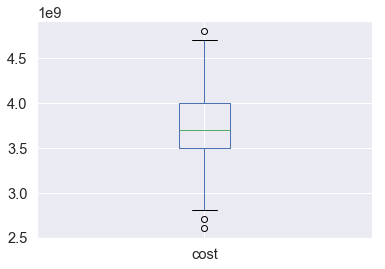

In [107]:
if SAVE_POP == 'RANDOM_CHOICE':
    print("Generate random Choices")
    # Create ranges
    submission = pd.read_csv(fpath, index_col='family_id')
    
    # create normal range 
    #arr_range = np.array([np.arange(submission.shape[0])])
    #arr_range = np.empty((NB_FIRST_POP, submission.shape[0]), dtype=np.int64)
    
    arr_pop_first_0 = \
        np.empty((NB_FIRST_POP, submission.shape[0]), dtype=np.int64)
    # generate first first choice for every families : 
    
    for fam_id in range(submission.shape[0]):
        arr_pop_first_0[0,fam_id] = choose_day_prob_optim(np.array([0]), fam_id)
    for indice in range(NB_FIRST_POP):
        arr_pop_first_0[indice] = arr_pop_first_0[0]
    
    # generated random choice for first pop around 0 + DELTA_CHOICE_RANDOM_POP
    arr_pop_first = fun_vect_mut(arr_pop_first_0, 
                                 r_pop_mut=1, 
                                 r_mut=1, 
                                 delta_choice=DELTA_CHOICE_RANDOM_POP)
    
    # Optimize first pop along one range only
    t_fit_0 = time.time()
    #best = submission['assigned_day'].values
    print("Optimizing one by one indiv along random range ...")
    arr_pop, arr_score = boost_optim_one_by_one_epochs(arr_pop_first,
                                                       n_epochs=100, 
                                                       nb_epoch_check=10,
                                                       nb_try_not_best_max=2)
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    df_cost = pd.DataFrame(data=arr_score, columns=["cost"])
    df_cost.boxplot()
    print("df_cost: ", df_cost.sort_values(by="cost").head(10))
    df_pop = pd.DataFrame(arr_pop)
    df_pop

Generate random Choices
Optimizing pop along one range only...
Timing :  740.7970812320709
df_cost:               cost
169  3.002902e+09
789  3.003441e+09
922  3.004191e+09
921  3.102918e+09
33   3.102924e+09
140  3.103571e+09
980  3.103588e+09
167  3.103617e+09
198  3.104266e+09
991  3.202892e+09


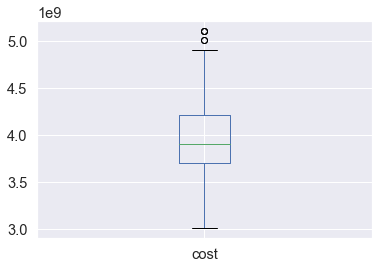

In [341]:
'''if SAVE_POP == 'RANDOM_CHOICE':
    print("Generate random Choices")
    # Create ranges
    submission = pd.read_csv(fpath, index_col='family_id')
    
    # create normal range 
    arr_range = np.array([np.arange(submission.shape[0])])
    #arr_range = np.empty((NB_FIRST_POP, submission.shape[0]), dtype=np.int64)
    
    arr_pop_first_0 = \
        np.empty((NB_FIRST_POP, submission.shape[0]), dtype=np.int64)
    # generate first first choice for every families : 
    for fam_id in range(submission.shape[0]):
        arr_pop_first_0[0,fam_id] = choose_day_prob_optim(np.array([0]), fam_id)
    for indice in range(NB_FIRST_POP):
        arr_pop_first_0[indice] = arr_pop_first_0[0]
    
    # generated random choice for first pop around 0 + DELTA_CHOICE_RANDOM_POP
    arr_pop_first = fun_vect_mut(arr_pop_first_0, 
                                 r_pop_mut=1, 
                                 r_mut=1, 
                                 delta_choice=DELTA_CHOICE_RANDOM_POP)
    
    # Optimize first pop along one range only
    t_fit_0 = time.time()
    #best = submission['assigned_day'].values
    print("Optimizing pop along one range only...")
    arr_pop, arr_score = boost_optim_one_by_one_multi(arr_pop_first, arr_range)
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    df_cost = pd.DataFrame(data=arr_score, columns=["cost"])
    df_cost.boxplot()
    print("df_cost: ", df_cost.sort_values(by="cost").head(10))
    df_pop = pd.DataFrame(arr_pop)
    df_pop'''

### Random paths method

In [104]:
#SAVE_POP = 'RANDOM_PATH' 

Generate random paths
   0     1     2     3     4     5     6     7     8     9     ...   4990  \
0  1234  4075  2654  1509    57  1312  3271  2387  3266   281  ...   3353   
1   371  3272   829  1824  1450  3882  4504  4331   190   443  ...    894   
2   515  1837  2235  1826  3655  2217   179  4592  3992  1020  ...   1699   
3  3520  1601  4737  2560  1832  3845  3991  3759   674  1099  ...   3564   
4   133   430  1130  4656  2484    49  1772   373   725  4867  ...   3590   
5  4571  1124  3122    97  1797   472   981  1594  2594   790  ...   2567   
6  3250  2669  4267   290  3406  2542   964  3685  3856  2855  ...   3498   
7  2739  4297  2611  2042  3318  2565  3852  2442  1447  4930  ...   2642   
8  1967  4109  3482  3285  3808  3630  3136  1061   487  4080  ...   2015   
9   217   534    53  3435  4319  1691  4771  2186  2567   775  ...   1105   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0  2352  1879   769  1821  1477   766  4597  4825  4937  
1  2204   250 

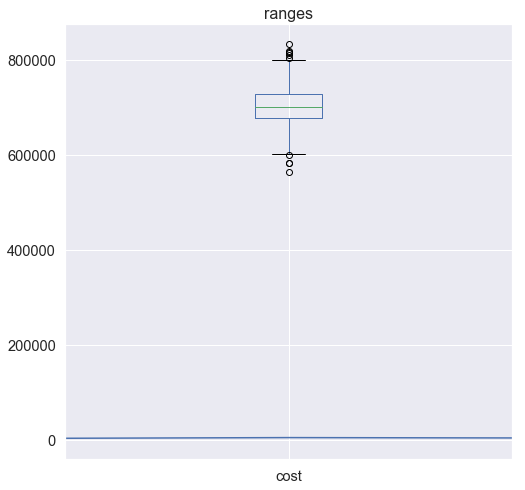

In [105]:
if SAVE_POP == 'RANDOM_PATH':
    print("Generate random paths")
    # Create ranges
    submission = pd.read_csv(fpath, index_col='family_id')
    
    # create NB_FIRST_POP random path to seek optimum
    arr_range = np.empty((NB_FIRST_POP, submission.shape[0]), dtype=np.int64)
    
    for indice in range(NB_FIRST_POP):
        arr_range[indice] = np.random.permutation(submission.shape[0])
    
    df_range = pd.DataFrame(data=arr_range)
    print(df_range.head(10))
    fig = plt.figure(figsize=(8, 8))
    plt.title("ranges")
    #for indice in range(0, df_range.shape[0]):
    plt.plot(df_range.loc[0])
    
    # create pop from submision by seeking along random paths
    t_fit_0 = time.time()
    best = submission['assigned_day'].values
    arr_pop, arr_score = boost_optim_one_by_one(best, arr_range=arr_range)
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    df_cost = pd.DataFrame(data=arr_score, columns=["cost"])
    df_cost.boxplot()
    print("df_cost: ", df_cost.sort_values(by="cost").head(10))
    df_pop = pd.DataFrame(arr_pop)
    df_pop

### 10 ranges method

In [54]:
#SAVE_POP = '10R'

In [55]:
# OPTIM VERSION 
# std pop choices : 0.578
if SAVE_POP == '10R':
    # Create ranges
    submission = pd.read_csv(fpath, index_col='family_id')
    df_range = create_seek_ranges(nb_first_seed=NB_FIRST_SEED)
    fig = plt.figure(figsize=(8, 8))
    plt.title("ranges")
    for indice in range(0, df_range.shape[0]):
        plt.plot(df_range.loc[indice])
        
    # Create baselines : optimized version
    t_fit_0 = time.time()
    # Start with the sample submission values
    submission = pd.read_csv(fpath, index_col='family_id')
    best = submission['assigned_day'].values
    arr_range = df_range.values
    arr_sub, arr_score = boost_diff_browsing_optim(best, arr_range=arr_range)
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)
    print("Info first pop of 10 :")
    _, df_des_choices_0, _ = pop_choices_info(pd.DataFrame(arr_sub))

    
    t_tot_0 = time.time()
    nb_indiv_done = 0
    nb_range = df_range.index.shape[0]
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    for i_seed in df_range.index:
        # choose number of indiv.
        nb_indiv_done += nb_indiv_curr
        if i_seed == nb_range-1:
            if NB_FIRST_POP % nb_range != 0:
                nb_indiv_curr += NB_FIRST_POP % nb_range
        nb_indiv_curr = int(nb_indiv_curr)
        print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                           nb_indiv_done))
        # load best indiv in range #i_seed
        #seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
        seed_indiv = arr_sub[i_seed]
        #print("seed_indiv.shape: ", seed_indiv.shape)
        # generate sub-pop 
        t_fit_0 = time.time()
        arr_pop_curr = generate_pop_choices_optim(seed_indiv=seed_indiv, 
                                           nb_pop=nb_indiv_curr, 
                                           r_mut=R_FIRST_MUT, 
                                           delta_choice=DELTA_CHOICE_FIRST_POP)
        t_fit_1 = time.time()
        print("Timing : ", t_fit_1 - t_fit_0)
        df_pop_curr = pd.DataFrame(arr_pop_curr)
        
        # add sub-pop to pop
        if i_seed == 0:
            df_pop = df_pop_curr
        else:
            df_pop = df_pop.append(df_pop_curr, ignore_index=True)
            
    t_tot_1 = time.time()
    print("Timing TOTAL: ", t_tot_1 - t_tot_0)
    print("df_pop.shape: ", df_pop.shape) 
    df_choices_0, df_des_choices_0, std_mean_0 = pop_choices_info(df_pop)
    print("Info for all pop: ")
    df_des_choices_0

### Save pop

In [131]:
if SAVE_POP == "10R": 
    #plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])
    
    
    path_df_pop_saved = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}_fs{}_rfm{}_dc{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP,
                    NB_FIRST_SEED, 
                    R_FIRST_MUT, 
                    DELTA_CHOICE_FIRST_POP)
    # check file already exist : 
    if os.path.isfile(path_df_pop_saved):
        path_df_pop_saved_old = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}_fs{}_rfm{}_dc{}_{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP,
                    NB_FIRST_SEED, 
                    R_FIRST_MUT, 
                    DELTA_CHOICE_FIRST_POP,
                    datetime.today().strftime('%Y_%m_%d_%H_%M_%S'))
        os.rename(path_df_pop_saved, path_df_pop_saved_old)
    # save
    joblib.dump(df_pop, path_df_pop_saved, compress=True)

In [109]:
if SAVE_POP == "RANDOM_PATH": 
    path_df_pop_saved = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP)
    # check file already exist : 
    if os.path.isfile(path_df_pop_saved):
        path_df_pop_saved_old = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}_{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP,
                    datetime.today().strftime('%Y_%m_%d_%H_%M_%S'))
        os.rename(path_df_pop_saved, path_df_pop_saved_old)
    # save
    joblib.dump(df_pop, path_df_pop_saved, compress=True)
    print(path_df_pop_saved)


../../data/df_pop_choices_RANDOM_PATH_1000.pkl


In [108]:
if SAVE_POP == "RANDOM_CHOICE": 
    path_df_pop_saved = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}_dcr{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP,
                    DELTA_CHOICE_RANDOM_POP)
    # check file already exist : 
    if os.path.isfile(path_df_pop_saved):
        path_df_pop_saved_old = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}_dcr{}_{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP,
                    DELTA_CHOICE_RANDOM_POP,
                    datetime.today().strftime('%Y_%m_%d_%H_%M_%S'))
        os.rename(path_df_pop_saved, path_df_pop_saved_old)
    # save
    joblib.dump(df_pop, path_df_pop_saved, compress=True)
    print(path_df_pop_saved)


../../data/df_pop_choices_RANDOM_CHOICE_1000_dcr1.pkl


In [134]:
if SAVE_POP == "RANDOM_MUT": 
    path_df_pop_saved = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}_rfrm{}_dcr{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP,
                    R_FIRST_RANDOM_MUT,
                    DELTA_RANDOM_MUT_POP)
    # check file already exist : 
    if os.path.isfile(path_df_pop_saved):
        path_df_pop_saved_old = PATH_TO_SAVE_DATA + \
        '/df_pop_choices_{}_{}_rfrm{}_dcr{}_{}.pkl'.format(
                    SAVE_POP,
                    NB_FIRST_POP,
                    R_FIRST_RANDOM_MUT,
                    DELTA_RANDOM_MUT_POP,
                    datetime.today().strftime('%Y_%m_%d_%H_%M_%S'))
        os.rename(path_df_pop_saved, path_df_pop_saved_old)
    # save
    joblib.dump(df_pop, path_df_pop_saved, compress=True)
    print(path_df_pop_saved)

../../data/df_pop_choices_RANDOM_MUT_1000_rfrm0.2_dcr1.pkl


## Eval with new crossing prob

### Load

##### Ranges to seek for boost mode

In [137]:
df_range = create_seek_ranges(nb_first_seed=NB_FIRST_SEED)
arr_range = df_range.values # f(num range, families)
df_range



,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1,4999,4998,4997,4996,4995,4994,4993,4992,4991,4990,...,9,8,7,6,5,4,3,2,1,0
2,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,990,991,992,993,994,995,996,997,998,999
3,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
4,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
6,1000,999,998,997,996,995,994,993,992,991,...,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001
7,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,...,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001
8,3000,2999,2998,2997,2996,2995,2994,2993,2992,2991,...,3010,3009,3008,3007,3006,3005,3004,3003,3002,3001
9,4000,3999,3998,3997,3996,3995,3994,3993,3992,3991,...,4010,4009,4008,4007,4006,4005,4004,4003,4002,4001


##### Load Pre-generate population

Loading:  ../../data/df_pop_choices_RANDOM_PATH_1000.pkl
Infos about population: 
Max Same indiv nb :  0
Mean Standard deviation over families for whole population :  1.38610852814821
Info about std:  count    5000.000000
mean        1.386109
std         1.314162
min         0.031623
25%         0.582851
50%         0.844533
75%         1.286595
max         4.908665
Name: std, dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.00000
mean,3.274000,3.281000,2.136000,0.689000,0.294000,0.285000,0.128000,4.317000,2.574000,3.476000,...,0.839000,0.774000,0.817000,0.088000,0.314000,0.031000,0.4820,0.594000,0.628000,0.08100
std,4.410485,4.427826,4.084383,2.393744,0.774703,0.578022,0.389574,4.657059,4.234909,3.417763,...,1.064994,1.122579,1.261389,0.529657,0.663207,0.260973,0.8464,1.036455,0.507813,0.39063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000,0.00000
75%,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,3.000000,3.000000,...,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0000,1.000000,1.000000,0.00000
max,10.000000,10.000000,10.000000,10.000000,4.000000,3.000000,3.000000,10.000000,10.000000,10.000000,...,5.000000,4.000000,6.000000,4.000000,3.000000,3.000000,5.0000,5.000000,2.000000,6.00000


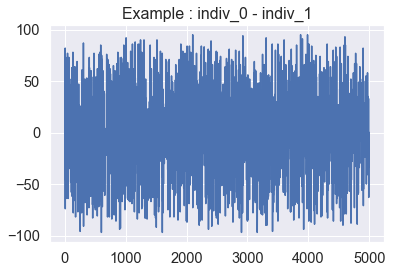

In [138]:
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob.pkl')
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))


if (SAVE_POP is None) & os.path.isfile(PATH_DF_POP):
    print("Loading: ", PATH_DF_POP)
    df_pop = joblib.load(PATH_DF_POP)
else:
    print("Loading: ", path_df_pop_saved)
    df_pop = joblib.load(path_df_pop_saved)
    
# info about first pop
print("Infos about population: ")
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])
plt.title("Example : indiv_0 - indiv_1")
print("Max Same indiv nb : ", find_max_same_indiv(df_pop.values))
_, df_des_choices_0, _ = pop_choices_info(df_pop)
df_des_choices_0

### Initialize costs

Timing:  0.1349163055419922


,cost
71,563182.123938
184,582386.521291
811,583253.332190
468,600239.091731
855,601573.240387
795,605029.530327
153,606943.500779
586,610444.979445
484,610910.226327
758,610956.241713


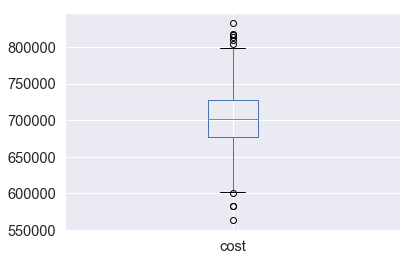

In [139]:
# create cost dataFrame for all population
'''t_1 = time.time()
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function_optim(df_pop.loc[indice].values)
print("Timing: ", time.time()-t_1)

df_cost.boxplot()

df_cost.sort_values(by="cost").head(10)'''



t_0 = time.time()
arr_pop = np.array(df_pop)
arr_score = eval_cost_vect_optim(arr_pop)
df_cost = pd.DataFrame(data=arr_score, columns=["cost"])
print("Timing: ", time.time()-t_0)
df_cost.boxplot()
df_cost.sort_values(by="cost").head(10)

### Selection probability

In [140]:
POW_SELECTION = 0.3

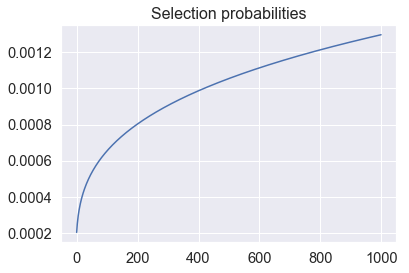

In [141]:
# Prob for indiv = inverse rank * POW_SELECTION
arr_select_prob = selection_prob(df_cost, pow_selection=POW_SELECTION)
plt.plot(np.sort(arr_select_prob))
plt.title("Selection probabilities");

### Loop over generations

GEN. #0 / cost: [563182.12393802] / nb. pop: 1000 / timing: 7.212368965148926
GEN. #1000 / cost: [548908.70116283] / nb. pop: 998 / timing: 0.13408207893371582
GEN. #2000 / cost: [541715.75591891] / nb. pop: 999 / timing: 0.14102602005004883
GEN. #3000 / cost: [453749.79310731] / nb. pop: 996 / timing: 0.14626097679138184
GEN. #4000 / cost: [386337.19205419] / nb. pop: 999 / timing: 0.18342900276184082
GEN. #5000 / cost: [346567.87279215] / nb. pop: 991 / timing: 0.15057110786437988
GEN. #6000 / cost: [313332.20402712] / nb. pop: 991 / timing: 0.13796496391296387
GEN. #7000 / cost: [284979.50545755] / nb. pop: 996 / timing: 0.1432340145111084
GEN. #8000 / cost: [259028.74979855] / nb. pop: 992 / timing: 0.15700507164001465
GEN. #9000 / cost: [243465.18316387] / nb. pop: 992 / timing: 0.1918041706085205
GEN. #10000 / cost: [229996.87275812] / nb. pop: 993 / timing: 0.1349329948425293
GEN. #11000 / cost: [218990.48824952] / nb. pop: 995 / timing: 0.34565210342407227
GEN. #12000 / cost: [

GEN. #100000 / cost: [91936.29025463] / nb. pop: 984 / timing: 0.15529084205627441
GEN. #101000 / cost: [91890.15823636] / nb. pop: 982 / timing: 0.16147303581237793
GEN. #102000 / cost: [91745.19851825] / nb. pop: 987 / timing: 0.14554500579833984
GEN. #103000 / cost: [91644.26101156] / nb. pop: 991 / timing: 0.17318010330200195
GEN. #104000 / cost: [91623.18456653] / nb. pop: 986 / timing: 0.33915090560913086
GEN. #105000 / cost: [91623.18456653] / nb. pop: 989 / timing: 0.17663979530334473
GEN. #106000 / cost: [91620.90452803] / nb. pop: 990 / timing: 0.16907215118408203
GEN. #107000 / cost: [91620.90452803] / nb. pop: 977 / timing: 0.2769458293914795
GEN. #108000 / cost: [91607.55985355] / nb. pop: 991 / timing: 0.13039112091064453
GEN. #109000 / cost: [91598.6431795] / nb. pop: 986 / timing: 0.16190576553344727
GEN. #110000 / cost: [91598.6431795] / nb. pop: 988 / timing: 0.452009916305542
GEN. #111000 / cost: [91598.6431795] / nb. pop: 979 / timing: 0.14783740043640137
GEN. #1120

END:
LAST GEN. #199999 / cost: [89924.27707458] / nb. pop: 985 / timing Total: 31206.63724708557


Text(0, 0.5, 'cost [$]')

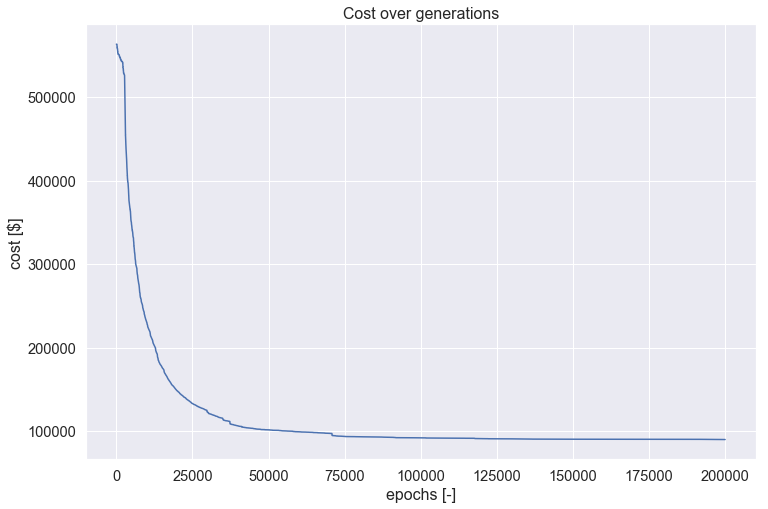

In [142]:
## HYPERPARAMETERS

# TEST NEW PARAM
NB_MAX_EPOCHS = 200000
R_POP_MUT = 0.1
R_MUT = 0.01 
DELTA_CHOICE = 2
NB_BEST_KEEP = 20 
POW_SELECTION = 0.3
flag_boost = False
boost_freq = 2000
R_CROSSOVER = 1

'''# TEST OLD PARAMS
NB_MAX_EPOCHS = 10000
R_POP_MUT = 0.1 # % population mutated at each gen. default : 0.10
R_MUT = 0.01 # % families mutated at each gen default : 0.01
DELTA_CHOICE = 2 # default : 2
NB_BEST_KEEP = 20 # NEW PARAM : how much best one to keep
POW_SELECTION = 0.3 # default 0.3
flag_boost = True
boost_freq = 2000'''

## DISPLAY PARAM
flag_prompt = False # timing information to each steps 
prompt_freq = 1000 #100 # frequency info about cost & timing 

## Other param
FIRST_COST = df_cost.sort_values(by="cost")["cost"].iloc[0]
FIRST_COST

## PREPARE LOOP
# prepare data 
nb_indiv_boost = 0
list_best_cost = []
t_fit_0 = time.time()

## LOOP OVER GENERATIONS 
for gen_id in range(0, NB_MAX_EPOCHS):
    
    t_epoch_0 = time.time()
    if flag_prompt:
        t_lost_0 = time.time()

    # keep 1st current best score 
    list_best_cost.append(df_cost.sort_values(by="cost").iloc[0]["cost"])
    

    '''df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["inv_rank"] = range(df_cost.shape[0]+1, 1, -1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    for indice in range(0, NB_BEST_KEEP):
        list_name_best.append(df_cost_sort.iloc[indice].name)
    
    df_best = df_pop.loc[list_name_best]
    df_cost_best = df_cost.loc[list_name_best]'''
    
    '''    
    # AVOID DUPLICATE INDIV
    df_best["cost"] = df_cost_best["cost"]
    df_best.drop_duplicates(subset=["cost"], inplace=True)
    df_best.drop(columns=["cost"], inplace=True)
    df_cost_best.drop_duplicates(subset=["cost"], inplace=True)
    '''

    ############
    # SELECTION  
    # calculation of probabilities for crossing next generation 
    # prob =  (1/rank)^POW_SELECTION

    # Keep the NB_BEST_KEEP best indiv.s
    arr_select_prob, df_best, df_cost_best = selection_prob(df_cost, 
      pow_selection=POW_SELECTION, df_pop=df_pop, flag_ouput=True,
      nb_best_keep=NB_BEST_KEEP)
    
    #arr_select_prob = selection_prob(df_cost, POW_SELECTION)
    #arr_select_prob = np.zeros(df_pop.shape[0])
    #arr_select_prob[df_cost_sort.index] = df_cost_sort["inv_rank"].values
    #arr_select_prob = (arr_select_prob)**POW_SELECTION 
    #arr_select_prob = arr_select_prob / np.sum(arr_select_prob)
    
    if flag_prompt:
        t_lost_1 = time.time()
        print("Timing lost: ", t_lost_1 - t_lost_0)
        
    ############
    # CROSSOVER 
    #
    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    if flag_prompt:
        t_cross_0 = time.time()
        
    arr_pop = np.array(df_pop) # df_pop = f(indiv., families)

    # crossing with more prob for best indiv.
    # number of new children = N pop - N best to keep same nb of indiv each gen.
    nb_cross = int(NB_FIRST_POP - NB_BEST_KEEP - nb_indiv_boost)
    # reset nb boost indiv
    if nb_indiv_boost > 0:
        nb_indiv_boost = 0 

    arr_pop = generate_crossing_prob(arr_pop.copy(), p=arr_select_prob, 
                                     n_indiv=nb_cross, r_cross=R_CROSSOVER)
    #print("Max Same indiv nb after crossing : ", find_max_same_indiv(arr_pop))
    if flag_prompt:
        t_cross_1 = time.time()
        print("Timing cross: ", t_cross_1 - t_cross_0)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # arr_pop or df_pop = f(indiv, family)
    if flag_prompt:
        t_mut_0 = time.time()
    arr_pop = fun_vect_mut(arr_pop, r_pop_mut=R_POP_MUT, r_mut=R_MUT, 
                delta_choice=DELTA_CHOICE)
    #print("Max Same indiv nb after mutation : ", find_max_same_indiv(arr_pop))
    
    ############    
    ## ADD the best ones
    #
    arr_pop = np.append(arr_pop, np.array(df_best), axis=0)
    # AVOID DUPLICATE INDIV 
    #arr_pop = np.unique(arr_pop, axis=0)  # replace by cost because too slow
    df_pop = pd.DataFrame(data=arr_pop)
    #print("Max Same indiv nb after add best : ", find_max_same_indiv(arr_pop))
    if flag_prompt:
        t_mut_1 = time.time()
        print("Timing mutation: ", t_mut_1 - t_mut_0)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    if flag_prompt:
        t_eval_0 = time.time()
    '''df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = \
            cost_function_optim(arr_pop[indice,:])'''
    # optim
    arr_score = eval_cost_vect_optim(arr_pop)
    df_cost = pd.DataFrame(data=arr_score, columns=["cost"])
    
    ##########
    # BOOSTING
    #
    # cost of last best submission

    if flag_boost & (gen_id % boost_freq == 0) & (gen_id > 0) :
        best = df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].values
    
        '''arr_sub, arr_score = boost_diff_browsing(arr_choice=arr_choice, 
                                             best=best, arr_range=arr_range)'''
        arr_sub, arr_score = boost_diff_browsing_optim(best=best, 
                                                       arr_range=arr_range)
    
        df_new_indiv = pd.DataFrame(data=arr_sub, columns=df_pop.columns)
        nb_indiv_boost = df_new_indiv.shape[0]
        df_pop = df_pop.append(df_new_indiv, ignore_index=True)
    
        df_score = pd.DataFrame(data=arr_score, columns=['cost'])
        df_cost = df_cost.append(df_score, ignore_index=True)
    
    ##########
    # AVOID DUPLICATES BY SAME COST : very FASTER
    # but potential diff indiv elimitated...
    #
    df_cost.drop_duplicates(subset=["cost"], inplace=True)
    df_pop = df_pop.filter(items=df_cost.index, axis=0)
    df_cost.reset_index(drop=True, inplace=True)
    df_pop.reset_index(drop=True, inplace=True)

    if flag_prompt:
        t_eval_1 = time.time()
        print("Timing eval: ", t_eval_1 - t_eval_0)
    
    ##########
    # DISPLAY
    #
    t_epoch_1 = time.time()
    if (flag_prompt) | (gen_id % prompt_freq == 0):
        print("GEN. #{} / cost: {} / nb. pop: {} / timing: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_epoch_1 - t_epoch_0))
        #print("Max Same indiv nb : ", find_max_same_indiv(arr_pop))

# timing 
t_fit_1 = time.time()
print("END:")
print("LAST GEN. #{} / cost: {} / nb. pop: {} / timing Total: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_fit_1 - t_fit_0)) 
# figure
fig = plt.figure(figsize=(12, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

In [143]:
print("How many same indiv. into population at the end : ")
find_max_same_indiv(df_pop)

How many same indiv. into population at the end : 


0

In [144]:
print("Pop Info :")
df_choices, df_des_choices, std_mean = pop_choices_info(df_pop)
df_des_choices

Pop Info :
Mean Standard deviation over families for whole population :  0.12825733191321484
Info about std:  count    5000.000000
mean        0.128257
std         0.105663
min         0.000000
25%         0.063628
50%         0.114829
75%         0.180151
max         1.031976
Name: std, dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,...,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,0.023350,0.006091,0.009137,0.003046,3.003046,0.052792,0.005076,0.013198,0.017259,3.049746,...,0.003046,0.019289,0.016244,0.007107,0.010152,0.004061,0.025381,0.015228,1.004061,0.001015
std,0.202783,0.135113,0.182902,0.095588,0.055132,0.297781,0.131342,0.145489,0.231438,0.316489,...,0.095588,0.208151,0.167902,0.138775,0.185606,0.090075,0.251753,0.158664,0.119210,0.031863
min,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,2.000000,4.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,4.000000,2.000000,4.000000,3.000000,4.000000,1.000000


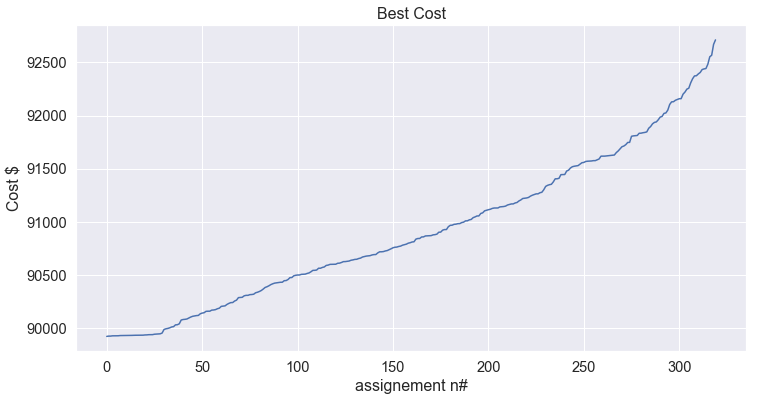

In [145]:
fig = plt.figure(figsize=(12, 6))
plt.plot(df_cost.sort_values(by="cost").head(NB_BEST_KEEP+300).values)
ax = fig.gca()
ax.set_title("Best Cost")
ax.set_ylabel("Cost $")
ax.set_xlabel('assignement n#');

In [146]:
print(df_cost.sort_values(by="cost").head(1)["cost"].values)

[89924.27707458]


### Save results

In [147]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]),
           compress=True)

# submission csv
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]
submission_final.index.name = 'family_id'
submission_final.to_csv("submission_{}.csv".format(
    df_cost.sort_values(by="cost").iloc[0,0]))           
print("Submission saved here :", "submission_{}.csv".format(
    df_cost.sort_values(by="cost").iloc[0,0]))

# SUBMISSION pickle
joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]),
           compress=True)
# list cost vs epochs 
joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]),
           compress=True)




Submission saved here : submission_89924.27707458043.csv


['../../data/list_best_cost1000_fs10_rfm0.05_dc2_rm0.1_nk_20_gen200000_s89924.27707458043.pkl']

In [148]:
#NB_FIRST_SEED = 10
#DELTA_CHOICE_FIRST_POP = 1
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
#NB_MAX_EPOCHS = 10000
#R_POP_MUT = 0.2 # % population mutated at each gen. default : 0.10
#R_MUT = 0.2 # % families mutated at each gen default : 0.01
#DELTA_CHOICE = 4 # default : 2
#NB_BEST_KEEP = 20 # NEW PARAM : how much best one to keep
#POW_SELECTION = 0.1 # default 0.3
#flag_boost = False
#boost_freq = 2000
#COMPUTERNAME
# FIRST_COST
BEST_COST = df_cost.sort_values(by="cost")["cost"].iloc[0]
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
try:
    timing = t_fit_1 - t_fit_0
except:
    timing = t_epoch_1 - t_fit_0 

nb_pop = df_pop.shape[0]
df_res = pd.DataFrame(columns=["date", "COMPUTERNAME", "FIRST_COST", 
                               "BEST_COST", "NB_MAX_EPOCHS", "timing", "nb_pop",
                              "NB_FIRST_SEED", "DELTA_CHOICE_FIRST_POP",
                              "R_FIRST_MUT", "R_POP_MUT", "R_MUT", 
                               "DELTA_CHOICE", "NB_BEST_KEEP", "POW_SELECTION",
                              "flag_boost", "boost_freq"], index=[0])

df_res["date"] = dt_string
df_res["COMPUTERNAME"] = COMPUTERNAME
df_res["FIRST_COST"] = FIRST_COST
df_res["BEST_COST"] = BEST_COST
df_res["NB_MAX_EPOCHS"] = NB_MAX_EPOCHS
df_res["timing"] = timing
df_res["nb_pop"] = df_pop.shape[0]
df_res["NB_FIRST_SEED"] = NB_FIRST_SEED
df_res["DELTA_CHOICE_FIRST_POP"] = DELTA_CHOICE_FIRST_POP
df_res["R_FIRST_MUT"] = R_FIRST_MUT
df_res["R_POP_MUT"] = R_POP_MUT
df_res["R_MUT"] = R_MUT
df_res["DELTA_CHOICE"] = DELTA_CHOICE
df_res["NB_BEST_KEEP"] = NB_BEST_KEEP
df_res["POW_SELECTION"] = POW_SELECTION
df_res["flag_boost"] = flag_boost
df_res["boost_freq"] = boost_freq
df_res.index.name = 'job'
df_res.to_csv(PATH_TO_SAVE_DATA + \
              '/res_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.csv'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                df_cost.sort_values(by="cost").iloc[0,0]))
df_res

,date,COMPUTERNAME,FIRST_COST,BEST_COST,NB_MAX_EPOCHS,timing,nb_pop,NB_FIRST_SEED,DELTA_CHOICE_FIRST_POP,R_FIRST_MUT,R_POP_MUT,R_MUT,DELTA_CHOICE,NB_BEST_KEEP,POW_SELECTION,flag_boost,boost_freq
job,,,,,,,,,,,,,,,,,
0,07/02/2020 04:47:10,MacBook-Pro-de-Gregory.local,563182.123938,89924.277075,200000,31206.637247,985,10,2,0.05,0.1,0.01,2,20,0.3,False,2000


### Explore res

In [149]:
df_pop_0 = joblib.load(PATH_DF_POP)

df_choices_0, df_des_choices_0, std_mean_0 = pop_choices_info(df_pop_0)
df_des_choices_0

Mean Standard deviation over families for whole population :  1.38610852814821
Info about std:  count    5000.000000
mean        1.386109
std         1.314162
min         0.031623
25%         0.582851
50%         0.844533
75%         1.286595
max         4.908665
Name: std, dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.00000
mean,3.274000,3.281000,2.136000,0.689000,0.294000,0.285000,0.128000,4.317000,2.574000,3.476000,...,0.839000,0.774000,0.817000,0.088000,0.314000,0.031000,0.4820,0.594000,0.628000,0.08100
std,4.410485,4.427826,4.084383,2.393744,0.774703,0.578022,0.389574,4.657059,4.234909,3.417763,...,1.064994,1.122579,1.261389,0.529657,0.663207,0.260973,0.8464,1.036455,0.507813,0.39063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000,0.00000
75%,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,3.000000,3.000000,...,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0000,1.000000,1.000000,0.00000
max,10.000000,10.000000,10.000000,10.000000,4.000000,3.000000,3.000000,10.000000,10.000000,10.000000,...,5.000000,4.000000,6.000000,4.000000,3.000000,3.000000,5.0000,5.000000,2.000000,6.00000


In [150]:
df_choices_0.loc[0].value_counts()

0     3087
1     1048
2      451
10     251
3      115
4       19
5       17
7        4
6        4
8        3
9        1
Name: 0, dtype: int64

##### Best

In [151]:
best = df_pop.loc[df_cost["cost"].idxmin()].values

In [152]:
cost_function_optim(best)

89924.27707458043

In [153]:
cost_function(best)

89924.27707458043

In [154]:
penalty, accounting_cost , daily_occupancy = cost_function(best, flag_prompt=True)

penalty for only families:  84642
daily_occupancy:  {100: 126, 99: 126, 98: 126, 97: 132, 96: 178, 95: 207, 94: 228, 93: 125, 92: 128, 91: 125, 90: 158, 89: 201, 88: 231, 87: 251, 86: 125, 85: 125, 84: 127, 83: 157, 82: 200, 81: 227, 80: 238, 79: 125, 78: 125, 77: 127, 76: 133, 75: 178, 74: 211, 73: 232, 72: 125, 71: 125, 70: 127, 69: 146, 68: 188, 67: 219, 66: 247, 65: 125, 64: 125, 63: 126, 62: 157, 61: 197, 60: 229, 59: 234, 58: 205, 57: 125, 56: 146, 55: 175, 54: 212, 53: 235, 52: 244, 51: 210, 50: 172, 49: 192, 48: 216, 47: 243, 46: 260, 45: 240, 44: 203, 43: 183, 42: 174, 41: 205, 40: 233, 39: 251, 38: 231, 37: 195, 36: 163, 35: 185, 34: 211, 33: 245, 32: 271, 31: 270, 30: 243, 29: 246, 28: 260, 27: 267, 26: 288, 25: 297, 24: 280, 23: 250, 22: 226, 21: 213, 20: 236, 19: 264, 18: 284, 17: 295, 16: 273, 15: 253, 14: 258, 13: 274, 12: 295, 11: 300, 10: 295, 9: 271, 8: 246, 7: 237, 6: 255, 5: 280, 4: 294, 3: 299, 2: 287, 1: 300}
accounting_cost:  5282.277074580428


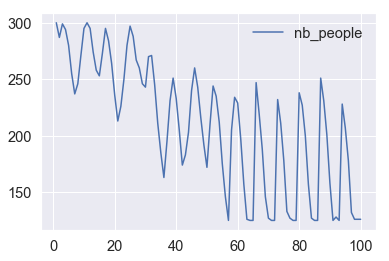

In [155]:
df_daily = pd.DataFrame(index=daily_occupancy.keys(), data=list(daily_occupancy.values()), 
             columns=['nb_people'])
#daily_occupancy.keys()
#daily_occupancy.values()
df_daily.plot()

In [156]:
df_daily.describe()

,nb_people
count,100.000000
mean,210.030000
std,56.842233
min,125.000000
25%,157.750000
50%,217.500000
75%,251.500000
max,300.000000


NameError: name 'df_prob_day' is not defined

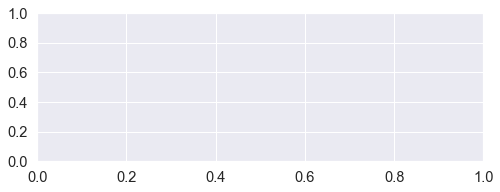

In [158]:
try:
    
    fig = plt.figure(figsize=(8, 6)) 
    ax1 = fig.add_subplot(2,1,1)
    df_prob_day["prob"].plot(ax=ax1)
    ax1.set_ylabel("prob [-]")
    ax1.set_xlabel("number of days before Christmas [days]");
    ax1.set_title("Probabilities for each days");
    ax2 = fig.add_subplot(2,1,2)
    df_daily.plot(ax=ax2)
except:
    pass

In [ ]:
arr_choices = np.zeros(best.shape[0])*np.nan
for fam_id, day_curr in enumerate(best):
    arr_choices[fam_id] = find_choice_from_day_optim(day_curr, fam_id)

df_best = pd.DataFrame(arr_choices.astype(np.int64), columns=["choice"]) 
df_best["day"] = best
df_best.describe()

In [ ]:
sns.distplot(df_best["choice"], bins=10, kde=False, rug=True)

In [ ]:
df_best["choice"].value_counts()

In [ ]:
ax = sns.countplot(x="choice", data=df_best)

##### All population

In [ ]:
df_des_choices

In [ ]:
df_des_choices.loc["std"].max()

In [ ]:

ax = []
for I in range(int(df_pop.shape[0]/200)):
    fig = plt.figure(figsize=(16, 8))
    ax_curr = fig.gca() #fig.add_subplot(int(df_pop.shape[0]/200), 1, I+1)
    ax.append(ax_curr)
    
    error_margin = \
        1.96*df_des_choices.loc["std",range(I*200, I*200+200)]/(df_pop.shape[0])**0.5
    
    plt.plot(range(I*200, I*200+200), 
             df_des_choices.loc["mean", range(I*200, I*200+200)], 'o-', alpha=0.25)
    plt.plot(range(I*200, I*200+200), 
             df_des_choices.loc["mean", range(I*200, I*200+200)] + error_margin,'.')
    plt.plot(range(I*200, I*200+200), 
             df_des_choices.loc["mean", range(I*200, I*200+200)] - error_margin,'.')


In [ ]:
fig = plt.figure()
plt.plot(des_choices.columns, des_choices.loc["min"])
ax = fig.gca()

#des_choices.loc["max"]

## output

In [ ]:
submission_final